In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=1024
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv='clf_fc1'
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']###rename and retrain C8
training_sample_X='logminmax'
switchFreq=100
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_01_dca_adv'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    


adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
    

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1':
    modelAdvC13=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,2)
    loss_adv=optimizer.optimizer_CEclf
    

if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    for fk in featureslist.keys():
        featureslist[fk] = featureslist[fk].cuda().float()
    for ak in adj_list.keys():
        adjnormlist[ak] =adjnormlist[ak].cuda()
        adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:

 
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
        
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
#     loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
    loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if 'dca' in model_str:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
#     loss_val = loss_x_val+loss_a_val
    loss_val=loss_x_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()

# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
    adj_norm=adjnormlist[training_samples_t]
    adj_label=adj_list[training_samples_t]
    features=featureslist[training_samples_t+'X_'+training_sample_X]
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if 'dca' in model_str:
        features_raw=features_raw_list[training_samples_t+'X_raw']
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 7.8594 loss_kl_train: 0.1176 loss_x_train: 7.7418 loss_a_train: 46.6838 loss_val: 7.6720 loss_x_val: 7.6720 loss_a_val: 0.8571 time: 0.3328s
control13 Epoch: 0001 loss_train: 6.5254 loss_kl_train: 0.0879 loss_x_train: 6.4375 loss_a_train: 42.2344 loss_val: 7.6097 loss_x_val: 7.6097 loss_a_val: 0.8646 time: 0.2172s
control13 Epoch: 0002 loss_train: 5.4824 loss_kl_train: 0.0787 loss_x_train: 5.4037 loss_a_train: 40.2878 loss_val: 7.4738 loss_x_val: 7.4738 loss_a_val: 0.8982 time: 0.2257s
control13 Epoch: 0003 loss_train: 4.6661 loss_kl_train: 0.0753 loss_x_train: 4.5908 loss_a_train: 39.8760 loss_val: 7.2528 loss_x_val: 7.2528 loss_a_val: 0.9798 time: 0.2207s
control13 Epoch: 0004 loss_train: 4.0580 loss_kl_train: 0.0737 loss_x_train: 3.9843 loss_a_train: 39.5419 loss_val: 7.0994 loss_x_val: 7.0994 loss_a_val: 0.9663 time: 0.2196s
control13 Epoch: 0005 loss_train: 3.5960 loss_kl_train: 0.0719 loss_x_train: 3.5241 loss_a_train: 38.6644 loss_val: 6.9987 lo

control13 Epoch: 0047 loss_train: 1.6017 loss_kl_train: 0.0354 loss_x_train: 1.5662 loss_a_train: 29.1755 loss_val: 3.1474 loss_x_val: 3.1474 loss_a_val: 16.1194 time: 0.2224s
control13 Epoch: 0048 loss_train: 1.5941 loss_kl_train: 0.0351 loss_x_train: 1.5591 loss_a_train: 29.0279 loss_val: 3.1566 loss_x_val: 3.1566 loss_a_val: 17.0438 time: 0.2225s
control13 Epoch: 0049 loss_train: 1.5866 loss_kl_train: 0.0347 loss_x_train: 1.5519 loss_a_train: 29.0213 loss_val: 3.1647 loss_x_val: 3.1647 loss_a_val: 18.0225 time: 0.2240s
control13 Epoch: 0050 loss_train: 1.5795 loss_kl_train: 0.0344 loss_x_train: 1.5452 loss_a_train: 28.8168 loss_val: 3.1681 loss_x_val: 3.1681 loss_a_val: 19.0884 time: 0.2241s
control13 Epoch: 0051 loss_train: 1.5732 loss_kl_train: 0.0340 loss_x_train: 1.5391 loss_a_train: 28.6701 loss_val: 3.1677 loss_x_val: 3.1677 loss_a_val: 20.2430 time: 0.2251s
control13 Epoch: 0052 loss_train: 1.5667 loss_kl_train: 0.0337 loss_x_train: 1.5330 loss_a_train: 28.5182 loss_val: 3.16

control13 Epoch: 0094 loss_train: 1.4358 loss_kl_train: 0.0234 loss_x_train: 1.4123 loss_a_train: 23.6914 loss_val: 3.8837 loss_x_val: 3.8837 loss_a_val: 40.0132 time: 0.2231s
control13 Epoch: 0095 loss_train: 1.4341 loss_kl_train: 0.0232 loss_x_train: 1.4109 loss_a_train: 23.5690 loss_val: 3.9084 loss_x_val: 3.9084 loss_a_val: 40.5260 time: 0.2237s
control13 Epoch: 0096 loss_train: 1.4329 loss_kl_train: 0.0231 loss_x_train: 1.4098 loss_a_train: 23.4385 loss_val: 3.9387 loss_x_val: 3.9387 loss_a_val: 41.3086 time: 0.2228s
control13 Epoch: 0097 loss_train: 1.4314 loss_kl_train: 0.0229 loss_x_train: 1.4085 loss_a_train: 23.5047 loss_val: 3.9650 loss_x_val: 3.9650 loss_a_val: 41.6972 time: 0.2239s
control13 Epoch: 0098 loss_train: 1.4299 loss_kl_train: 0.0227 loss_x_train: 1.4072 loss_a_train: 23.3744 loss_val: 3.9846 loss_x_val: 3.9846 loss_a_val: 41.8938 time: 0.2248s
control13 Epoch: 0099 loss_train: 1.4286 loss_kl_train: 0.0225 loss_x_train: 1.4060 loss_a_train: 23.2760 loss_val: 3.99

disease13 Epoch: 0141 loss_train: 1.5275 loss_kl_train: 0.0167 loss_x_train: 1.5109 loss_a_train: 23.8519 loss_val: 2.0342 loss_x_val: 2.0342 loss_a_val: 18.7695 time: 0.3093s
disease13 Epoch: 0142 loss_train: 1.5268 loss_kl_train: 0.0165 loss_x_train: 1.5103 loss_a_train: 23.7098 loss_val: 2.0286 loss_x_val: 2.0286 loss_a_val: 18.7562 time: 0.3114s
disease13 Epoch: 0143 loss_train: 1.5261 loss_kl_train: 0.0164 loss_x_train: 1.5097 loss_a_train: 23.6869 loss_val: 2.0247 loss_x_val: 2.0247 loss_a_val: 18.7254 time: 0.3101s
disease13 Epoch: 0144 loss_train: 1.5255 loss_kl_train: 0.0163 loss_x_train: 1.5092 loss_a_train: 23.6631 loss_val: 2.0237 loss_x_val: 2.0237 loss_a_val: 18.6820 time: 0.3114s
disease13 Epoch: 0145 loss_train: 1.5247 loss_kl_train: 0.0162 loss_x_train: 1.5086 loss_a_train: 23.5004 loss_val: 2.0222 loss_x_val: 2.0222 loss_a_val: 18.6163 time: 0.3111s
disease13 Epoch: 0146 loss_train: 1.5240 loss_kl_train: 0.0160 loss_x_train: 1.5079 loss_a_train: 23.4775 loss_val: 2.02

disease13 Epoch: 0188 loss_train: 1.5034 loss_kl_train: 0.0124 loss_x_train: 1.4910 loss_a_train: 21.2264 loss_val: 1.9135 loss_x_val: 1.9135 loss_a_val: 16.5722 time: 0.3150s
disease13 Epoch: 0189 loss_train: 1.5030 loss_kl_train: 0.0123 loss_x_train: 1.4907 loss_a_train: 21.2767 loss_val: 1.9128 loss_x_val: 1.9128 loss_a_val: 16.5263 time: 0.3152s
disease13 Epoch: 0190 loss_train: 1.5026 loss_kl_train: 0.0122 loss_x_train: 1.4904 loss_a_train: 21.0175 loss_val: 1.9125 loss_x_val: 1.9125 loss_a_val: 16.4785 time: 0.3118s
disease13 Epoch: 0191 loss_train: 1.5022 loss_kl_train: 0.0122 loss_x_train: 1.4901 loss_a_train: 20.9901 loss_val: 1.9107 loss_x_val: 1.9107 loss_a_val: 16.4551 time: 0.3111s
disease13 Epoch: 0192 loss_train: 1.5019 loss_kl_train: 0.0121 loss_x_train: 1.4898 loss_a_train: 20.9358 loss_val: 1.9088 loss_x_val: 1.9088 loss_a_val: 16.4275 time: 0.3149s
disease13 Epoch: 0193 loss_train: 1.5017 loss_kl_train: 0.0121 loss_x_train: 1.4896 loss_a_train: 20.9849 loss_val: 1.90

disease8 Epoch: 0235 loss_train: 1.3043 loss_kl_train: 0.0142 loss_x_train: 1.2901 loss_a_train: 19.3709 loss_val: 1.5127 loss_x_val: 1.5127 loss_a_val: 10.4193 time: 0.2070s
disease8 Epoch: 0236 loss_train: 1.3039 loss_kl_train: 0.0140 loss_x_train: 1.2899 loss_a_train: 19.2260 loss_val: 1.5123 loss_x_val: 1.5123 loss_a_val: 10.4711 time: 0.2097s
disease8 Epoch: 0237 loss_train: 1.3035 loss_kl_train: 0.0139 loss_x_train: 1.2897 loss_a_train: 19.1732 loss_val: 1.5121 loss_x_val: 1.5121 loss_a_val: 10.5056 time: 0.2092s
disease8 Epoch: 0238 loss_train: 1.3034 loss_kl_train: 0.0137 loss_x_train: 1.2896 loss_a_train: 19.1323 loss_val: 1.5115 loss_x_val: 1.5115 loss_a_val: 10.5244 time: 0.2088s
disease8 Epoch: 0239 loss_train: 1.3029 loss_kl_train: 0.0136 loss_x_train: 1.2893 loss_a_train: 18.9638 loss_val: 1.5115 loss_x_val: 1.5115 loss_a_val: 10.5356 time: 0.2066s
disease8 Epoch: 0240 loss_train: 1.3026 loss_kl_train: 0.0134 loss_x_train: 1.2892 loss_a_train: 18.9617 loss_val: 1.5113 los

disease8 Epoch: 0282 loss_train: 1.2929 loss_kl_train: 0.0095 loss_x_train: 1.2834 loss_a_train: 16.9569 loss_val: 1.5290 loss_x_val: 1.5290 loss_a_val: 9.3111 time: 0.2070s
disease8 Epoch: 0283 loss_train: 1.2928 loss_kl_train: 0.0094 loss_x_train: 1.2833 loss_a_train: 16.9386 loss_val: 1.5289 loss_x_val: 1.5289 loss_a_val: 9.3026 time: 0.2071s
disease8 Epoch: 0284 loss_train: 1.2926 loss_kl_train: 0.0094 loss_x_train: 1.2832 loss_a_train: 16.8996 loss_val: 1.5285 loss_x_val: 1.5285 loss_a_val: 9.2997 time: 0.2103s
disease8 Epoch: 0285 loss_train: 1.2923 loss_kl_train: 0.0093 loss_x_train: 1.2830 loss_a_train: 16.9310 loss_val: 1.5280 loss_x_val: 1.5280 loss_a_val: 9.2944 time: 0.2089s
disease8 Epoch: 0286 loss_train: 1.2922 loss_kl_train: 0.0092 loss_x_train: 1.2830 loss_a_train: 16.8470 loss_val: 1.5276 loss_x_val: 1.5276 loss_a_val: 9.2863 time: 0.2078s
disease8 Epoch: 0287 loss_train: 1.2919 loss_kl_train: 0.0092 loss_x_train: 1.2827 loss_a_train: 16.8248 loss_val: 1.5275 loss_x_v

control8 Epoch: 0330 loss_train: 1.4322 loss_kl_train: 0.0081 loss_x_train: 1.4241 loss_a_train: 16.3999 loss_val: 1.6080 loss_x_val: 1.6080 loss_a_val: 5.2824 time: 0.2371s
control8 Epoch: 0331 loss_train: 1.4319 loss_kl_train: 0.0081 loss_x_train: 1.4238 loss_a_train: 16.3054 loss_val: 1.6071 loss_x_val: 1.6071 loss_a_val: 5.3334 time: 0.2332s
control8 Epoch: 0332 loss_train: 1.4317 loss_kl_train: 0.0080 loss_x_train: 1.4237 loss_a_train: 16.2493 loss_val: 1.6063 loss_x_val: 1.6063 loss_a_val: 5.3947 time: 0.2383s
control8 Epoch: 0333 loss_train: 1.4315 loss_kl_train: 0.0079 loss_x_train: 1.4236 loss_a_train: 16.2870 loss_val: 1.6054 loss_x_val: 1.6054 loss_a_val: 5.4597 time: 0.2336s
control8 Epoch: 0334 loss_train: 1.4314 loss_kl_train: 0.0079 loss_x_train: 1.4235 loss_a_train: 16.3006 loss_val: 1.6041 loss_x_val: 1.6041 loss_a_val: 5.5189 time: 0.2380s
control8 Epoch: 0335 loss_train: 1.4312 loss_kl_train: 0.0078 loss_x_train: 1.4233 loss_a_train: 16.3110 loss_val: 1.6028 loss_x_v

control8 Epoch: 0378 loss_train: 1.4244 loss_kl_train: 0.0061 loss_x_train: 1.4183 loss_a_train: 15.4417 loss_val: 1.5901 loss_x_val: 1.5901 loss_a_val: 4.8945 time: 0.2363s
control8 Epoch: 0379 loss_train: 1.4243 loss_kl_train: 0.0061 loss_x_train: 1.4182 loss_a_train: 15.3562 loss_val: 1.5903 loss_x_val: 1.5903 loss_a_val: 4.8780 time: 0.2371s
control8 Epoch: 0380 loss_train: 1.4242 loss_kl_train: 0.0061 loss_x_train: 1.4181 loss_a_train: 15.3596 loss_val: 1.5907 loss_x_val: 1.5907 loss_a_val: 4.8634 time: 0.2392s
control8 Epoch: 0381 loss_train: 1.4242 loss_kl_train: 0.0060 loss_x_train: 1.4181 loss_a_train: 15.2719 loss_val: 1.5909 loss_x_val: 1.5909 loss_a_val: 4.8501 time: 0.2350s
control8 Epoch: 0382 loss_train: 1.4239 loss_kl_train: 0.0060 loss_x_train: 1.4179 loss_a_train: 15.4369 loss_val: 1.5912 loss_x_val: 1.5912 loss_a_val: 4.8347 time: 0.2370s
control8 Epoch: 0383 loss_train: 1.4238 loss_kl_train: 0.0060 loss_x_train: 1.4179 loss_a_train: 15.3013 loss_val: 1.5913 loss_x_v

control13 Epoch: 0425 loss_train: 1.3417 loss_kl_train: 0.0050 loss_x_train: 1.3367 loss_a_train: 14.5898 loss_val: 1.4978 loss_x_val: 1.4978 loss_a_val: 4.1918 time: 0.2288s
control13 Epoch: 0426 loss_train: 1.3415 loss_kl_train: 0.0049 loss_x_train: 1.3366 loss_a_train: 14.6084 loss_val: 1.4972 loss_x_val: 1.4972 loss_a_val: 4.1862 time: 0.2248s
control13 Epoch: 0427 loss_train: 1.3415 loss_kl_train: 0.0049 loss_x_train: 1.3367 loss_a_train: 14.5537 loss_val: 1.4959 loss_x_val: 1.4959 loss_a_val: 4.1913 time: 0.2273s
control13 Epoch: 0428 loss_train: 1.3412 loss_kl_train: 0.0049 loss_x_train: 1.3364 loss_a_train: 14.5516 loss_val: 1.4943 loss_x_val: 1.4943 loss_a_val: 4.2121 time: 0.2259s
control13 Epoch: 0429 loss_train: 1.3410 loss_kl_train: 0.0048 loss_x_train: 1.3362 loss_a_train: 14.4931 loss_val: 1.4927 loss_x_val: 1.4927 loss_a_val: 4.2411 time: 0.2254s
control13 Epoch: 0430 loss_train: 1.3410 loss_kl_train: 0.0048 loss_x_train: 1.3362 loss_a_train: 14.5294 loss_val: 1.4908 lo

control13 Epoch: 0472 loss_train: 1.3370 loss_kl_train: 0.0041 loss_x_train: 1.3329 loss_a_train: 14.1801 loss_val: 1.4814 loss_x_val: 1.4814 loss_a_val: 4.2655 time: 0.2265s
control13 Epoch: 0473 loss_train: 1.3368 loss_kl_train: 0.0040 loss_x_train: 1.3327 loss_a_train: 14.2689 loss_val: 1.4816 loss_x_val: 1.4816 loss_a_val: 4.2589 time: 0.2250s
control13 Epoch: 0474 loss_train: 1.3367 loss_kl_train: 0.0040 loss_x_train: 1.3326 loss_a_train: 14.1424 loss_val: 1.4815 loss_x_val: 1.4815 loss_a_val: 4.2452 time: 0.2265s
control13 Epoch: 0475 loss_train: 1.3366 loss_kl_train: 0.0040 loss_x_train: 1.3326 loss_a_train: 14.1921 loss_val: 1.4812 loss_x_val: 1.4812 loss_a_val: 4.2347 time: 0.2271s
control13 Epoch: 0476 loss_train: 1.3365 loss_kl_train: 0.0040 loss_x_train: 1.3325 loss_a_train: 14.1408 loss_val: 1.4809 loss_x_val: 1.4809 loss_a_val: 4.2219 time: 0.2283s
control13 Epoch: 0477 loss_train: 1.3365 loss_kl_train: 0.0040 loss_x_train: 1.3325 loss_a_train: 14.1632 loss_val: 1.4805 lo

disease13 Epoch: 0519 loss_train: 1.4660 loss_kl_train: 0.0033 loss_x_train: 1.4627 loss_a_train: 14.2129 loss_val: 1.5896 loss_x_val: 1.5896 loss_a_val: 3.8971 time: 0.3178s
disease13 Epoch: 0520 loss_train: 1.4658 loss_kl_train: 0.0033 loss_x_train: 1.4624 loss_a_train: 14.2555 loss_val: 1.5906 loss_x_val: 1.5906 loss_a_val: 3.8824 time: 0.3123s
disease13 Epoch: 0521 loss_train: 1.4656 loss_kl_train: 0.0033 loss_x_train: 1.4623 loss_a_train: 14.1874 loss_val: 1.5916 loss_x_val: 1.5916 loss_a_val: 3.8499 time: 0.3087s
disease13 Epoch: 0522 loss_train: 1.4656 loss_kl_train: 0.0033 loss_x_train: 1.4623 loss_a_train: 14.1833 loss_val: 1.5925 loss_x_val: 1.5925 loss_a_val: 3.8112 time: 0.3127s
disease13 Epoch: 0523 loss_train: 1.4654 loss_kl_train: 0.0033 loss_x_train: 1.4621 loss_a_train: 14.1866 loss_val: 1.5930 loss_x_val: 1.5930 loss_a_val: 3.7737 time: 0.3175s
disease13 Epoch: 0524 loss_train: 1.4652 loss_kl_train: 0.0033 loss_x_train: 1.4619 loss_a_train: 14.2457 loss_val: 1.5932 lo

disease13 Epoch: 0566 loss_train: 1.4616 loss_kl_train: 0.0031 loss_x_train: 1.4586 loss_a_train: 13.9849 loss_val: 1.5754 loss_x_val: 1.5754 loss_a_val: 3.6606 time: 0.3141s
disease13 Epoch: 0567 loss_train: 1.4615 loss_kl_train: 0.0031 loss_x_train: 1.4584 loss_a_train: 14.0043 loss_val: 1.5748 loss_x_val: 1.5748 loss_a_val: 3.6605 time: 0.3159s
disease13 Epoch: 0568 loss_train: 1.4614 loss_kl_train: 0.0031 loss_x_train: 1.4583 loss_a_train: 13.9677 loss_val: 1.5743 loss_x_val: 1.5743 loss_a_val: 3.6604 time: 0.3138s
disease13 Epoch: 0569 loss_train: 1.4614 loss_kl_train: 0.0031 loss_x_train: 1.4583 loss_a_train: 13.9229 loss_val: 1.5738 loss_x_val: 1.5738 loss_a_val: 3.6562 time: 0.3125s
disease13 Epoch: 0570 loss_train: 1.4613 loss_kl_train: 0.0031 loss_x_train: 1.4582 loss_a_train: 14.0225 loss_val: 1.5733 loss_x_val: 1.5733 loss_a_val: 3.6509 time: 0.3131s
disease13 Epoch: 0571 loss_train: 1.4613 loss_kl_train: 0.0031 loss_x_train: 1.4582 loss_a_train: 14.0546 loss_val: 1.5733 lo

disease8 Epoch: 0613 loss_train: 1.2729 loss_kl_train: 0.0041 loss_x_train: 1.2689 loss_a_train: 14.0101 loss_val: 1.3346 loss_x_val: 1.3346 loss_a_val: 3.5324 time: 0.2116s
disease8 Epoch: 0614 loss_train: 1.2727 loss_kl_train: 0.0041 loss_x_train: 1.2686 loss_a_train: 14.0557 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 3.5346 time: 0.2113s
disease8 Epoch: 0615 loss_train: 1.2726 loss_kl_train: 0.0040 loss_x_train: 1.2686 loss_a_train: 14.0521 loss_val: 1.3378 loss_x_val: 1.3378 loss_a_val: 3.5376 time: 0.2085s
disease8 Epoch: 0616 loss_train: 1.2723 loss_kl_train: 0.0040 loss_x_train: 1.2683 loss_a_train: 14.0078 loss_val: 1.3395 loss_x_val: 1.3395 loss_a_val: 3.5339 time: 0.2098s
disease8 Epoch: 0617 loss_train: 1.2722 loss_kl_train: 0.0040 loss_x_train: 1.2682 loss_a_train: 14.0186 loss_val: 1.3409 loss_x_val: 1.3409 loss_a_val: 3.5120 time: 0.2113s
disease8 Epoch: 0618 loss_train: 1.2721 loss_kl_train: 0.0040 loss_x_train: 1.2681 loss_a_train: 13.9769 loss_val: 1.3422 loss_x_v

disease8 Epoch: 0661 loss_train: 1.2686 loss_kl_train: 0.0032 loss_x_train: 1.2654 loss_a_train: 13.7032 loss_val: 1.3335 loss_x_val: 1.3335 loss_a_val: 3.3059 time: 0.2073s
disease8 Epoch: 0662 loss_train: 1.2685 loss_kl_train: 0.0032 loss_x_train: 1.2653 loss_a_train: 13.7219 loss_val: 1.3338 loss_x_val: 1.3338 loss_a_val: 3.2993 time: 0.2121s
disease8 Epoch: 0663 loss_train: 1.2685 loss_kl_train: 0.0032 loss_x_train: 1.2653 loss_a_train: 13.7062 loss_val: 1.3341 loss_x_val: 1.3341 loss_a_val: 3.3018 time: 0.2103s
disease8 Epoch: 0664 loss_train: 1.2685 loss_kl_train: 0.0032 loss_x_train: 1.2653 loss_a_train: 13.7344 loss_val: 1.3343 loss_x_val: 1.3343 loss_a_val: 3.3040 time: 0.2083s
disease8 Epoch: 0665 loss_train: 1.2684 loss_kl_train: 0.0032 loss_x_train: 1.2652 loss_a_train: 13.6830 loss_val: 1.3345 loss_x_val: 1.3345 loss_a_val: 3.3079 time: 0.2072s
disease8 Epoch: 0666 loss_train: 1.2684 loss_kl_train: 0.0032 loss_x_train: 1.2652 loss_a_train: 13.7123 loss_val: 1.3346 loss_x_v

control8 Epoch: 0709 loss_train: 1.4114 loss_kl_train: 0.0029 loss_x_train: 1.4085 loss_a_train: 13.6647 loss_val: 1.4815 loss_x_val: 1.4815 loss_a_val: 2.5887 time: 0.2370s
control8 Epoch: 0710 loss_train: 1.4112 loss_kl_train: 0.0029 loss_x_train: 1.4082 loss_a_train: 13.6351 loss_val: 1.4823 loss_x_val: 1.4823 loss_a_val: 2.6918 time: 0.2400s
control8 Epoch: 0711 loss_train: 1.4112 loss_kl_train: 0.0029 loss_x_train: 1.4083 loss_a_train: 13.5944 loss_val: 1.4828 loss_x_val: 1.4828 loss_a_val: 2.8006 time: 0.2377s
control8 Epoch: 0712 loss_train: 1.4108 loss_kl_train: 0.0029 loss_x_train: 1.4079 loss_a_train: 13.6775 loss_val: 1.4833 loss_x_val: 1.4833 loss_a_val: 2.8981 time: 0.2380s
control8 Epoch: 0713 loss_train: 1.4107 loss_kl_train: 0.0029 loss_x_train: 1.4078 loss_a_train: 13.7024 loss_val: 1.4839 loss_x_val: 1.4839 loss_a_val: 2.9681 time: 0.2370s
control8 Epoch: 0714 loss_train: 1.4105 loss_kl_train: 0.0029 loss_x_train: 1.4076 loss_a_train: 13.5911 loss_val: 1.4844 loss_x_v

control8 Epoch: 0757 loss_train: 1.4070 loss_kl_train: 0.0027 loss_x_train: 1.4043 loss_a_train: 13.5094 loss_val: 1.4755 loss_x_val: 1.4755 loss_a_val: 2.4715 time: 0.2357s
control8 Epoch: 0758 loss_train: 1.4069 loss_kl_train: 0.0027 loss_x_train: 1.4042 loss_a_train: 13.4363 loss_val: 1.4754 loss_x_val: 1.4754 loss_a_val: 2.4710 time: 0.2402s
control8 Epoch: 0759 loss_train: 1.4069 loss_kl_train: 0.0027 loss_x_train: 1.4042 loss_a_train: 13.4980 loss_val: 1.4755 loss_x_val: 1.4755 loss_a_val: 2.4727 time: 0.2359s
control8 Epoch: 0760 loss_train: 1.4068 loss_kl_train: 0.0027 loss_x_train: 1.4041 loss_a_train: 13.5214 loss_val: 1.4759 loss_x_val: 1.4759 loss_a_val: 2.4726 time: 0.2380s
control8 Epoch: 0761 loss_train: 1.4068 loss_kl_train: 0.0027 loss_x_train: 1.4041 loss_a_train: 13.4080 loss_val: 1.4762 loss_x_val: 1.4762 loss_a_val: 2.4735 time: 0.2373s
control8 Epoch: 0762 loss_train: 1.4068 loss_kl_train: 0.0027 loss_x_train: 1.4041 loss_a_train: 13.4349 loss_val: 1.4761 loss_x_v

control13 Epoch: 0805 loss_train: 1.3291 loss_kl_train: 0.0025 loss_x_train: 1.3267 loss_a_train: 13.2682 loss_val: 1.3786 loss_x_val: 1.3786 loss_a_val: 2.0795 time: 0.2287s
control13 Epoch: 0806 loss_train: 1.3291 loss_kl_train: 0.0025 loss_x_train: 1.3266 loss_a_train: 13.2555 loss_val: 1.3778 loss_x_val: 1.3778 loss_a_val: 2.1280 time: 0.2253s
control13 Epoch: 0807 loss_train: 1.3289 loss_kl_train: 0.0024 loss_x_train: 1.3264 loss_a_train: 13.1799 loss_val: 1.3773 loss_x_val: 1.3773 loss_a_val: 2.1954 time: 0.2278s
control13 Epoch: 0808 loss_train: 1.3287 loss_kl_train: 0.0024 loss_x_train: 1.3262 loss_a_train: 13.2409 loss_val: 1.3773 loss_x_val: 1.3773 loss_a_val: 2.2726 time: 0.2276s
control13 Epoch: 0809 loss_train: 1.3285 loss_kl_train: 0.0024 loss_x_train: 1.3261 loss_a_train: 13.2172 loss_val: 1.3775 loss_x_val: 1.3775 loss_a_val: 2.3518 time: 0.2245s
control13 Epoch: 0810 loss_train: 1.3284 loss_kl_train: 0.0024 loss_x_train: 1.3260 loss_a_train: 13.2403 loss_val: 1.3781 lo

control13 Epoch: 0852 loss_train: 1.3253 loss_kl_train: 0.0022 loss_x_train: 1.3230 loss_a_train: 13.1491 loss_val: 1.3799 loss_x_val: 1.3799 loss_a_val: 2.4253 time: 0.2273s
control13 Epoch: 0853 loss_train: 1.3252 loss_kl_train: 0.0022 loss_x_train: 1.3229 loss_a_train: 13.1091 loss_val: 1.3797 loss_x_val: 1.3797 loss_a_val: 2.4196 time: 0.2281s
control13 Epoch: 0854 loss_train: 1.3252 loss_kl_train: 0.0022 loss_x_train: 1.3229 loss_a_train: 13.1251 loss_val: 1.3798 loss_x_val: 1.3798 loss_a_val: 2.4168 time: 0.2245s
control13 Epoch: 0855 loss_train: 1.3252 loss_kl_train: 0.0022 loss_x_train: 1.3229 loss_a_train: 13.0975 loss_val: 1.3799 loss_x_val: 1.3799 loss_a_val: 2.4159 time: 0.2290s
control13 Epoch: 0856 loss_train: 1.3252 loss_kl_train: 0.0022 loss_x_train: 1.3230 loss_a_train: 13.1120 loss_val: 1.3799 loss_x_val: 1.3799 loss_a_val: 2.4121 time: 0.2269s
control13 Epoch: 0857 loss_train: 1.3252 loss_kl_train: 0.0022 loss_x_train: 1.3229 loss_a_train: 13.1903 loss_val: 1.3801 lo

control13 Epoch: 0899 loss_train: 1.3239 loss_kl_train: 0.0021 loss_x_train: 1.3218 loss_a_train: 13.0602 loss_val: 1.3771 loss_x_val: 1.3771 loss_a_val: 2.4039 time: 0.2272s
disease13 Epoch: 0900 loss_train: 1.4566 loss_kl_train: 0.0018 loss_x_train: 1.4548 loss_a_train: 13.2330 loss_val: 1.5120 loss_x_val: 1.5120 loss_a_val: 2.1151 time: 0.3111s
disease13 Epoch: 0901 loss_train: 1.4563 loss_kl_train: 0.0018 loss_x_train: 1.4545 loss_a_train: 13.2451 loss_val: 1.5106 loss_x_val: 1.5106 loss_a_val: 2.0162 time: 0.3183s
disease13 Epoch: 0902 loss_train: 1.4561 loss_kl_train: 0.0018 loss_x_train: 1.4543 loss_a_train: 13.2989 loss_val: 1.5093 loss_x_val: 1.5093 loss_a_val: 1.9432 time: 0.3149s
disease13 Epoch: 0903 loss_train: 1.4556 loss_kl_train: 0.0018 loss_x_train: 1.4538 loss_a_train: 13.2586 loss_val: 1.5092 loss_x_val: 1.5092 loss_a_val: 1.9042 time: 0.3123s
disease13 Epoch: 0904 loss_train: 1.4556 loss_kl_train: 0.0018 loss_x_train: 1.4538 loss_a_train: 13.3049 loss_val: 1.5096 lo

disease13 Epoch: 0946 loss_train: 1.4520 loss_kl_train: 0.0019 loss_x_train: 1.4501 loss_a_train: 13.1570 loss_val: 1.5046 loss_x_val: 1.5046 loss_a_val: 2.3686 time: 0.3176s
disease13 Epoch: 0947 loss_train: 1.4520 loss_kl_train: 0.0019 loss_x_train: 1.4500 loss_a_train: 13.1348 loss_val: 1.5047 loss_x_val: 1.5047 loss_a_val: 2.3791 time: 0.3193s
disease13 Epoch: 0948 loss_train: 1.4520 loss_kl_train: 0.0019 loss_x_train: 1.4500 loss_a_train: 13.2056 loss_val: 1.5046 loss_x_val: 1.5046 loss_a_val: 2.3919 time: 0.3153s
disease13 Epoch: 0949 loss_train: 1.4519 loss_kl_train: 0.0019 loss_x_train: 1.4500 loss_a_train: 13.1642 loss_val: 1.5045 loss_x_val: 1.5045 loss_a_val: 2.4028 time: 0.3133s
disease13 Epoch: 0950 loss_train: 1.4518 loss_kl_train: 0.0019 loss_x_train: 1.4499 loss_a_train: 13.1663 loss_val: 1.5044 loss_x_val: 1.5044 loss_a_val: 2.4100 time: 0.3166s
disease13 Epoch: 0951 loss_train: 1.4519 loss_kl_train: 0.0019 loss_x_train: 1.4499 loss_a_train: 13.1563 loss_val: 1.5046 lo

disease13 Epoch: 0993 loss_train: 1.4505 loss_kl_train: 0.0020 loss_x_train: 1.4485 loss_a_train: 13.1540 loss_val: 1.5006 loss_x_val: 1.5006 loss_a_val: 2.4503 time: 0.3113s
disease13 Epoch: 0994 loss_train: 1.4504 loss_kl_train: 0.0020 loss_x_train: 1.4485 loss_a_train: 13.1245 loss_val: 1.5004 loss_x_val: 1.5004 loss_a_val: 2.4493 time: 0.3146s
disease13 Epoch: 0995 loss_train: 1.4504 loss_kl_train: 0.0020 loss_x_train: 1.4484 loss_a_train: 13.1446 loss_val: 1.5003 loss_x_val: 1.5003 loss_a_val: 2.4511 time: 0.3177s
disease13 Epoch: 0996 loss_train: 1.4504 loss_kl_train: 0.0020 loss_x_train: 1.4484 loss_a_train: 13.1769 loss_val: 1.5001 loss_x_val: 1.5001 loss_a_val: 2.4542 time: 0.3130s
disease13 Epoch: 0997 loss_train: 1.4503 loss_kl_train: 0.0020 loss_x_train: 1.4483 loss_a_train: 13.0682 loss_val: 1.4999 loss_x_val: 1.4999 loss_a_val: 2.4533 time: 0.3151s
disease13 Epoch: 0998 loss_train: 1.4504 loss_kl_train: 0.0020 loss_x_train: 1.4484 loss_a_train: 13.1782 loss_val: 1.5000 lo

disease8 Epoch: 1041 loss_train: 1.2617 loss_kl_train: 0.0023 loss_x_train: 1.2595 loss_a_train: 13.1726 loss_val: 1.2836 loss_x_val: 1.2836 loss_a_val: 2.4442 time: 0.2055s
disease8 Epoch: 1042 loss_train: 1.2617 loss_kl_train: 0.0023 loss_x_train: 1.2595 loss_a_train: 13.1689 loss_val: 1.2836 loss_x_val: 1.2836 loss_a_val: 2.4303 time: 0.2081s
disease8 Epoch: 1043 loss_train: 1.2618 loss_kl_train: 0.0022 loss_x_train: 1.2595 loss_a_train: 13.1315 loss_val: 1.2837 loss_x_val: 1.2837 loss_a_val: 2.4202 time: 0.2090s
disease8 Epoch: 1044 loss_train: 1.2616 loss_kl_train: 0.0022 loss_x_train: 1.2594 loss_a_train: 13.2006 loss_val: 1.2837 loss_x_val: 1.2837 loss_a_val: 2.4085 time: 0.2120s
disease8 Epoch: 1045 loss_train: 1.2617 loss_kl_train: 0.0022 loss_x_train: 1.2594 loss_a_train: 13.1316 loss_val: 1.2835 loss_x_val: 1.2835 loss_a_val: 2.3984 time: 0.2108s
disease8 Epoch: 1046 loss_train: 1.2616 loss_kl_train: 0.0022 loss_x_train: 1.2594 loss_a_train: 13.1347 loss_val: 1.2830 loss_x_v

disease8 Epoch: 1089 loss_train: 1.2605 loss_kl_train: 0.0021 loss_x_train: 1.2585 loss_a_train: 13.0414 loss_val: 1.2824 loss_x_val: 1.2824 loss_a_val: 2.3914 time: 0.2094s
disease8 Epoch: 1090 loss_train: 1.2606 loss_kl_train: 0.0021 loss_x_train: 1.2585 loss_a_train: 13.0692 loss_val: 1.2821 loss_x_val: 1.2821 loss_a_val: 2.3805 time: 0.2120s
disease8 Epoch: 1091 loss_train: 1.2605 loss_kl_train: 0.0021 loss_x_train: 1.2584 loss_a_train: 13.1150 loss_val: 1.2821 loss_x_val: 1.2821 loss_a_val: 2.3760 time: 0.2052s
disease8 Epoch: 1092 loss_train: 1.2605 loss_kl_train: 0.0021 loss_x_train: 1.2584 loss_a_train: 13.1205 loss_val: 1.2821 loss_x_val: 1.2821 loss_a_val: 2.3728 time: 0.2112s
disease8 Epoch: 1093 loss_train: 1.2604 loss_kl_train: 0.0021 loss_x_train: 1.2584 loss_a_train: 13.1298 loss_val: 1.2818 loss_x_val: 1.2818 loss_a_val: 2.3722 time: 0.2102s
disease8 Epoch: 1094 loss_train: 1.2604 loss_kl_train: 0.0021 loss_x_train: 1.2583 loss_a_train: 13.1275 loss_val: 1.2814 loss_x_v

control8 Epoch: 1137 loss_train: 1.4010 loss_kl_train: 0.0020 loss_x_train: 1.3990 loss_a_train: 13.0203 loss_val: 1.4329 loss_x_val: 1.4329 loss_a_val: 2.0422 time: 0.2360s
control8 Epoch: 1138 loss_train: 1.4010 loss_kl_train: 0.0020 loss_x_train: 1.3989 loss_a_train: 13.1065 loss_val: 1.4330 loss_x_val: 1.4330 loss_a_val: 2.0365 time: 0.2409s
control8 Epoch: 1139 loss_train: 1.4010 loss_kl_train: 0.0020 loss_x_train: 1.3990 loss_a_train: 13.0325 loss_val: 1.4331 loss_x_val: 1.4331 loss_a_val: 2.0322 time: 0.2369s
control8 Epoch: 1140 loss_train: 1.4008 loss_kl_train: 0.0020 loss_x_train: 1.3988 loss_a_train: 13.0934 loss_val: 1.4332 loss_x_val: 1.4332 loss_a_val: 2.0256 time: 0.2428s
control8 Epoch: 1141 loss_train: 1.4008 loss_kl_train: 0.0020 loss_x_train: 1.3988 loss_a_train: 13.0463 loss_val: 1.4332 loss_x_val: 1.4332 loss_a_val: 2.0185 time: 0.2357s
control8 Epoch: 1142 loss_train: 1.4008 loss_kl_train: 0.0020 loss_x_train: 1.3987 loss_a_train: 13.0212 loss_val: 1.4332 loss_x_v

control8 Epoch: 1185 loss_train: 1.3997 loss_kl_train: 0.0020 loss_x_train: 1.3977 loss_a_train: 13.0390 loss_val: 1.4315 loss_x_val: 1.4315 loss_a_val: 2.0186 time: 0.2353s
control8 Epoch: 1186 loss_train: 1.3995 loss_kl_train: 0.0020 loss_x_train: 1.3975 loss_a_train: 12.9714 loss_val: 1.4314 loss_x_val: 1.4314 loss_a_val: 2.0198 time: 0.2383s
control8 Epoch: 1187 loss_train: 1.3995 loss_kl_train: 0.0020 loss_x_train: 1.3975 loss_a_train: 12.9929 loss_val: 1.4315 loss_x_val: 1.4315 loss_a_val: 2.0264 time: 0.2394s
control8 Epoch: 1188 loss_train: 1.3996 loss_kl_train: 0.0020 loss_x_train: 1.3976 loss_a_train: 13.1030 loss_val: 1.4315 loss_x_val: 1.4315 loss_a_val: 2.0292 time: 0.2365s
control8 Epoch: 1189 loss_train: 1.3996 loss_kl_train: 0.0020 loss_x_train: 1.3976 loss_a_train: 13.0353 loss_val: 1.4315 loss_x_val: 1.4315 loss_a_val: 2.0311 time: 0.2395s
control8 Epoch: 1190 loss_train: 1.3994 loss_kl_train: 0.0020 loss_x_train: 1.3974 loss_a_train: 13.0279 loss_val: 1.4314 loss_x_v

control13 Epoch: 1232 loss_train: 1.3208 loss_kl_train: 0.0018 loss_x_train: 1.3190 loss_a_train: 12.9084 loss_val: 1.3478 loss_x_val: 1.3478 loss_a_val: 2.0650 time: 0.2272s
control13 Epoch: 1233 loss_train: 1.3208 loss_kl_train: 0.0018 loss_x_train: 1.3189 loss_a_train: 12.8861 loss_val: 1.3479 loss_x_val: 1.3479 loss_a_val: 2.0679 time: 0.2287s
control13 Epoch: 1234 loss_train: 1.3207 loss_kl_train: 0.0018 loss_x_train: 1.3189 loss_a_train: 12.8851 loss_val: 1.3478 loss_x_val: 1.3478 loss_a_val: 2.0642 time: 0.2248s
control13 Epoch: 1235 loss_train: 1.3207 loss_kl_train: 0.0019 loss_x_train: 1.3189 loss_a_train: 12.8453 loss_val: 1.3478 loss_x_val: 1.3478 loss_a_val: 2.0575 time: 0.2319s
control13 Epoch: 1236 loss_train: 1.3207 loss_kl_train: 0.0019 loss_x_train: 1.3188 loss_a_train: 12.8292 loss_val: 1.3480 loss_x_val: 1.3480 loss_a_val: 2.0485 time: 0.2258s
control13 Epoch: 1237 loss_train: 1.3206 loss_kl_train: 0.0019 loss_x_train: 1.3188 loss_a_train: 12.9086 loss_val: 1.3481 lo

control13 Epoch: 1279 loss_train: 1.3196 loss_kl_train: 0.0018 loss_x_train: 1.3177 loss_a_train: 12.8457 loss_val: 1.3475 loss_x_val: 1.3475 loss_a_val: 1.9168 time: 0.2303s
control13 Epoch: 1280 loss_train: 1.3196 loss_kl_train: 0.0018 loss_x_train: 1.3178 loss_a_train: 12.8634 loss_val: 1.3474 loss_x_val: 1.3474 loss_a_val: 1.9208 time: 0.2252s
control13 Epoch: 1281 loss_train: 1.3196 loss_kl_train: 0.0018 loss_x_train: 1.3178 loss_a_train: 12.7878 loss_val: 1.3474 loss_x_val: 1.3474 loss_a_val: 1.9257 time: 0.2228s
control13 Epoch: 1282 loss_train: 1.3197 loss_kl_train: 0.0018 loss_x_train: 1.3178 loss_a_train: 12.8942 loss_val: 1.3474 loss_x_val: 1.3474 loss_a_val: 1.9279 time: 0.2281s
control13 Epoch: 1283 loss_train: 1.3196 loss_kl_train: 0.0018 loss_x_train: 1.3177 loss_a_train: 12.7736 loss_val: 1.3475 loss_x_val: 1.3475 loss_a_val: 1.9332 time: 0.2295s
control13 Epoch: 1284 loss_train: 1.3196 loss_kl_train: 0.0018 loss_x_train: 1.3178 loss_a_train: 12.8624 loss_val: 1.3473 lo

disease13 Epoch: 1326 loss_train: 1.4481 loss_kl_train: 0.0015 loss_x_train: 1.4465 loss_a_train: 12.8941 loss_val: 1.4781 loss_x_val: 1.4781 loss_a_val: 2.0075 time: 0.3160s
disease13 Epoch: 1327 loss_train: 1.4480 loss_kl_train: 0.0015 loss_x_train: 1.4464 loss_a_train: 12.9131 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 2.0211 time: 0.3125s
disease13 Epoch: 1328 loss_train: 1.4479 loss_kl_train: 0.0016 loss_x_train: 1.4463 loss_a_train: 12.8147 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 2.0396 time: 0.3139s
disease13 Epoch: 1329 loss_train: 1.4478 loss_kl_train: 0.0016 loss_x_train: 1.4463 loss_a_train: 12.9473 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 2.0618 time: 0.3141s
disease13 Epoch: 1330 loss_train: 1.4478 loss_kl_train: 0.0016 loss_x_train: 1.4462 loss_a_train: 12.8885 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 2.0814 time: 0.3178s
disease13 Epoch: 1331 loss_train: 1.4478 loss_kl_train: 0.0016 loss_x_train: 1.4462 loss_a_train: 12.8915 loss_val: 1.4782 lo

disease13 Epoch: 1373 loss_train: 1.4464 loss_kl_train: 0.0017 loss_x_train: 1.4447 loss_a_train: 12.9292 loss_val: 1.4757 loss_x_val: 1.4757 loss_a_val: 2.0067 time: 0.3148s
disease13 Epoch: 1374 loss_train: 1.4464 loss_kl_train: 0.0017 loss_x_train: 1.4447 loss_a_train: 12.9589 loss_val: 1.4757 loss_x_val: 1.4757 loss_a_val: 2.0107 time: 0.3174s
disease13 Epoch: 1375 loss_train: 1.4465 loss_kl_train: 0.0017 loss_x_train: 1.4447 loss_a_train: 12.9138 loss_val: 1.4758 loss_x_val: 1.4758 loss_a_val: 2.0162 time: 0.3125s
disease13 Epoch: 1376 loss_train: 1.4464 loss_kl_train: 0.0017 loss_x_train: 1.4447 loss_a_train: 12.9071 loss_val: 1.4755 loss_x_val: 1.4755 loss_a_val: 2.0162 time: 0.3150s
disease13 Epoch: 1377 loss_train: 1.4464 loss_kl_train: 0.0017 loss_x_train: 1.4447 loss_a_train: 12.9536 loss_val: 1.4755 loss_x_val: 1.4755 loss_a_val: 2.0168 time: 0.3112s
disease13 Epoch: 1378 loss_train: 1.4463 loss_kl_train: 0.0017 loss_x_train: 1.4446 loss_a_train: 12.8820 loss_val: 1.4756 lo

disease8 Epoch: 1420 loss_train: 1.2591 loss_kl_train: 0.0020 loss_x_train: 1.2570 loss_a_train: 12.9573 loss_val: 1.2636 loss_x_val: 1.2636 loss_a_val: 2.0674 time: 0.2082s
disease8 Epoch: 1421 loss_train: 1.2590 loss_kl_train: 0.0020 loss_x_train: 1.2570 loss_a_train: 12.9279 loss_val: 1.2635 loss_x_val: 1.2635 loss_a_val: 2.0325 time: 0.2083s
disease8 Epoch: 1422 loss_train: 1.2590 loss_kl_train: 0.0020 loss_x_train: 1.2570 loss_a_train: 13.0074 loss_val: 1.2636 loss_x_val: 1.2636 loss_a_val: 2.0079 time: 0.2082s
disease8 Epoch: 1423 loss_train: 1.2589 loss_kl_train: 0.0020 loss_x_train: 1.2569 loss_a_train: 12.9465 loss_val: 1.2635 loss_x_val: 1.2635 loss_a_val: 1.9930 time: 0.2078s
disease8 Epoch: 1424 loss_train: 1.2588 loss_kl_train: 0.0020 loss_x_train: 1.2568 loss_a_train: 12.9075 loss_val: 1.2633 loss_x_val: 1.2633 loss_a_val: 1.9839 time: 0.2129s
disease8 Epoch: 1425 loss_train: 1.2588 loss_kl_train: 0.0020 loss_x_train: 1.2568 loss_a_train: 12.8675 loss_val: 1.2633 loss_x_v

disease8 Epoch: 1468 loss_train: 1.2575 loss_kl_train: 0.0019 loss_x_train: 1.2556 loss_a_train: 13.0146 loss_val: 1.2631 loss_x_val: 1.2631 loss_a_val: 1.9698 time: 0.2116s
disease8 Epoch: 1469 loss_train: 1.2576 loss_kl_train: 0.0019 loss_x_train: 1.2557 loss_a_train: 12.9828 loss_val: 1.2632 loss_x_val: 1.2632 loss_a_val: 1.9738 time: 0.2070s
disease8 Epoch: 1470 loss_train: 1.2575 loss_kl_train: 0.0019 loss_x_train: 1.2556 loss_a_train: 12.8926 loss_val: 1.2632 loss_x_val: 1.2632 loss_a_val: 1.9825 time: 0.2083s
disease8 Epoch: 1471 loss_train: 1.2575 loss_kl_train: 0.0019 loss_x_train: 1.2556 loss_a_train: 12.9301 loss_val: 1.2632 loss_x_val: 1.2632 loss_a_val: 1.9882 time: 0.2044s
disease8 Epoch: 1472 loss_train: 1.2574 loss_kl_train: 0.0019 loss_x_train: 1.2555 loss_a_train: 12.9953 loss_val: 1.2632 loss_x_val: 1.2632 loss_a_val: 1.9888 time: 0.2089s
disease8 Epoch: 1473 loss_train: 1.2575 loss_kl_train: 0.0019 loss_x_train: 1.2556 loss_a_train: 12.8905 loss_val: 1.2631 loss_x_v

control8 Epoch: 1516 loss_train: 1.3985 loss_kl_train: 0.0017 loss_x_train: 1.3968 loss_a_train: 12.9766 loss_val: 1.4172 loss_x_val: 1.4172 loss_a_val: 2.0238 time: 0.2357s
control8 Epoch: 1517 loss_train: 1.3985 loss_kl_train: 0.0017 loss_x_train: 1.3968 loss_a_train: 12.8646 loss_val: 1.4171 loss_x_val: 1.4171 loss_a_val: 1.9713 time: 0.2382s
control8 Epoch: 1518 loss_train: 1.3985 loss_kl_train: 0.0017 loss_x_train: 1.3968 loss_a_train: 12.8799 loss_val: 1.4171 loss_x_val: 1.4171 loss_a_val: 1.9198 time: 0.2372s
control8 Epoch: 1519 loss_train: 1.3983 loss_kl_train: 0.0017 loss_x_train: 1.3966 loss_a_train: 12.9081 loss_val: 1.4170 loss_x_val: 1.4170 loss_a_val: 1.8756 time: 0.2412s
control8 Epoch: 1520 loss_train: 1.3982 loss_kl_train: 0.0017 loss_x_train: 1.3965 loss_a_train: 12.8689 loss_val: 1.4168 loss_x_val: 1.4168 loss_a_val: 1.8405 time: 0.2371s
control8 Epoch: 1521 loss_train: 1.3982 loss_kl_train: 0.0017 loss_x_train: 1.3965 loss_a_train: 12.9275 loss_val: 1.4165 loss_x_v

control8 Epoch: 1564 loss_train: 1.3967 loss_kl_train: 0.0019 loss_x_train: 1.3949 loss_a_train: 12.8626 loss_val: 1.4151 loss_x_val: 1.4151 loss_a_val: 1.7980 time: 0.2351s
control8 Epoch: 1565 loss_train: 1.3967 loss_kl_train: 0.0019 loss_x_train: 1.3948 loss_a_train: 12.9143 loss_val: 1.4151 loss_x_val: 1.4151 loss_a_val: 1.7976 time: 0.2413s
control8 Epoch: 1566 loss_train: 1.3967 loss_kl_train: 0.0019 loss_x_train: 1.3948 loss_a_train: 12.8465 loss_val: 1.4151 loss_x_val: 1.4151 loss_a_val: 1.7967 time: 0.2361s
control8 Epoch: 1567 loss_train: 1.3967 loss_kl_train: 0.0019 loss_x_train: 1.3948 loss_a_train: 12.8900 loss_val: 1.4152 loss_x_val: 1.4152 loss_a_val: 1.7927 time: 0.2377s
control8 Epoch: 1568 loss_train: 1.3966 loss_kl_train: 0.0019 loss_x_train: 1.3948 loss_a_train: 12.8499 loss_val: 1.4151 loss_x_val: 1.4151 loss_a_val: 1.7892 time: 0.2397s
control8 Epoch: 1569 loss_train: 1.3967 loss_kl_train: 0.0019 loss_x_train: 1.3948 loss_a_train: 12.8214 loss_val: 1.4150 loss_x_v

control13 Epoch: 1612 loss_train: 1.3194 loss_kl_train: 0.0017 loss_x_train: 1.3176 loss_a_train: 12.7305 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 1.8717 time: 0.2282s
control13 Epoch: 1613 loss_train: 1.3192 loss_kl_train: 0.0017 loss_x_train: 1.3175 loss_a_train: 12.6771 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 1.8866 time: 0.2298s
control13 Epoch: 1614 loss_train: 1.3190 loss_kl_train: 0.0017 loss_x_train: 1.3173 loss_a_train: 12.7047 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 1.8893 time: 0.2252s
control13 Epoch: 1615 loss_train: 1.3190 loss_kl_train: 0.0017 loss_x_train: 1.3172 loss_a_train: 12.7133 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 1.8840 time: 0.2300s
control13 Epoch: 1616 loss_train: 1.3188 loss_kl_train: 0.0017 loss_x_train: 1.3171 loss_a_train: 12.7438 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 1.8693 time: 0.2260s
control13 Epoch: 1617 loss_train: 1.3188 loss_kl_train: 0.0017 loss_x_train: 1.3171 loss_a_train: 12.7694 loss_val: 1.3352 lo

control13 Epoch: 1659 loss_train: 1.3173 loss_kl_train: 0.0017 loss_x_train: 1.3156 loss_a_train: 12.7956 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 1.7029 time: 0.2289s
control13 Epoch: 1660 loss_train: 1.3172 loss_kl_train: 0.0017 loss_x_train: 1.3155 loss_a_train: 12.7218 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 1.7020 time: 0.2248s
control13 Epoch: 1661 loss_train: 1.3173 loss_kl_train: 0.0017 loss_x_train: 1.3155 loss_a_train: 12.7373 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 1.6979 time: 0.2226s
control13 Epoch: 1662 loss_train: 1.3172 loss_kl_train: 0.0017 loss_x_train: 1.3155 loss_a_train: 12.7347 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 1.6893 time: 0.2273s
control13 Epoch: 1663 loss_train: 1.3172 loss_kl_train: 0.0017 loss_x_train: 1.3154 loss_a_train: 12.7221 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 1.6783 time: 0.2287s
control13 Epoch: 1664 loss_train: 1.3172 loss_kl_train: 0.0017 loss_x_train: 1.3155 loss_a_train: 12.7036 loss_val: 1.3349 lo

disease13 Epoch: 1706 loss_train: 1.4468 loss_kl_train: 0.0013 loss_x_train: 1.4455 loss_a_train: 12.8275 loss_val: 1.4672 loss_x_val: 1.4672 loss_a_val: 1.6226 time: 0.3121s
disease13 Epoch: 1707 loss_train: 1.4467 loss_kl_train: 0.0013 loss_x_train: 1.4454 loss_a_train: 12.8939 loss_val: 1.4669 loss_x_val: 1.4669 loss_a_val: 1.6841 time: 0.3158s
disease13 Epoch: 1708 loss_train: 1.4467 loss_kl_train: 0.0013 loss_x_train: 1.4454 loss_a_train: 12.7923 loss_val: 1.4668 loss_x_val: 1.4668 loss_a_val: 1.7630 time: 0.3112s
disease13 Epoch: 1709 loss_train: 1.4466 loss_kl_train: 0.0013 loss_x_train: 1.4453 loss_a_train: 12.8315 loss_val: 1.4671 loss_x_val: 1.4671 loss_a_val: 1.8581 time: 0.3161s
disease13 Epoch: 1710 loss_train: 1.4464 loss_kl_train: 0.0013 loss_x_train: 1.4451 loss_a_train: 12.8632 loss_val: 1.4673 loss_x_val: 1.4673 loss_a_val: 1.9623 time: 0.3160s
disease13 Epoch: 1711 loss_train: 1.4463 loss_kl_train: 0.0013 loss_x_train: 1.4449 loss_a_train: 12.8664 loss_val: 1.4673 lo

disease13 Epoch: 1753 loss_train: 1.4442 loss_kl_train: 0.0016 loss_x_train: 1.4426 loss_a_train: 12.8618 loss_val: 1.4654 loss_x_val: 1.4654 loss_a_val: 1.7802 time: 0.3136s
disease13 Epoch: 1754 loss_train: 1.4442 loss_kl_train: 0.0016 loss_x_train: 1.4426 loss_a_train: 12.8424 loss_val: 1.4652 loss_x_val: 1.4652 loss_a_val: 1.7799 time: 0.3176s
disease13 Epoch: 1755 loss_train: 1.4441 loss_kl_train: 0.0016 loss_x_train: 1.4425 loss_a_train: 12.7996 loss_val: 1.4652 loss_x_val: 1.4652 loss_a_val: 1.7820 time: 0.3176s
disease13 Epoch: 1756 loss_train: 1.4441 loss_kl_train: 0.0016 loss_x_train: 1.4425 loss_a_train: 12.7960 loss_val: 1.4653 loss_x_val: 1.4653 loss_a_val: 1.7832 time: 0.3165s
disease13 Epoch: 1757 loss_train: 1.4441 loss_kl_train: 0.0016 loss_x_train: 1.4425 loss_a_train: 12.7589 loss_val: 1.4653 loss_x_val: 1.4653 loss_a_val: 1.7861 time: 0.3186s
disease13 Epoch: 1758 loss_train: 1.4441 loss_kl_train: 0.0016 loss_x_train: 1.4424 loss_a_train: 12.8126 loss_val: 1.4652 lo

disease8 Epoch: 1800 loss_train: 1.2601 loss_kl_train: 0.0020 loss_x_train: 1.2581 loss_a_train: 12.8411 loss_val: 1.2576 loss_x_val: 1.2576 loss_a_val: 2.1972 time: 0.2135s
disease8 Epoch: 1801 loss_train: 1.2598 loss_kl_train: 0.0020 loss_x_train: 1.2578 loss_a_train: 12.8989 loss_val: 1.2575 loss_x_val: 1.2575 loss_a_val: 2.0930 time: 0.2048s
disease8 Epoch: 1802 loss_train: 1.2595 loss_kl_train: 0.0020 loss_x_train: 1.2575 loss_a_train: 12.9494 loss_val: 1.2567 loss_x_val: 1.2567 loss_a_val: 2.0158 time: 0.2091s
disease8 Epoch: 1803 loss_train: 1.2593 loss_kl_train: 0.0020 loss_x_train: 1.2573 loss_a_train: 12.8561 loss_val: 1.2559 loss_x_val: 1.2559 loss_a_val: 1.9942 time: 0.2102s
disease8 Epoch: 1804 loss_train: 1.2590 loss_kl_train: 0.0020 loss_x_train: 1.2570 loss_a_train: 12.8493 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 2.0095 time: 0.2106s
disease8 Epoch: 1805 loss_train: 1.2589 loss_kl_train: 0.0020 loss_x_train: 1.2569 loss_a_train: 12.8678 loss_val: 1.2550 loss_x_v

disease8 Epoch: 1848 loss_train: 1.2559 loss_kl_train: 0.0018 loss_x_train: 1.2540 loss_a_train: 12.9187 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 1.7849 time: 0.2121s
disease8 Epoch: 1849 loss_train: 1.2558 loss_kl_train: 0.0018 loss_x_train: 1.2539 loss_a_train: 12.8832 loss_val: 1.2553 loss_x_val: 1.2553 loss_a_val: 1.7790 time: 0.2094s
disease8 Epoch: 1850 loss_train: 1.2558 loss_kl_train: 0.0018 loss_x_train: 1.2540 loss_a_train: 12.9084 loss_val: 1.2553 loss_x_val: 1.2553 loss_a_val: 1.7759 time: 0.2084s
disease8 Epoch: 1851 loss_train: 1.2558 loss_kl_train: 0.0018 loss_x_train: 1.2539 loss_a_train: 12.8500 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 1.7763 time: 0.2048s
disease8 Epoch: 1852 loss_train: 1.2558 loss_kl_train: 0.0018 loss_x_train: 1.2540 loss_a_train: 12.8829 loss_val: 1.2553 loss_x_val: 1.2553 loss_a_val: 1.7760 time: 0.2084s
disease8 Epoch: 1853 loss_train: 1.2557 loss_kl_train: 0.0018 loss_x_train: 1.2539 loss_a_train: 12.8903 loss_val: 1.2553 loss_x_v

disease8 Epoch: 1896 loss_train: 1.2552 loss_kl_train: 0.0018 loss_x_train: 1.2534 loss_a_train: 12.8937 loss_val: 1.2555 loss_x_val: 1.2555 loss_a_val: 1.7799 time: 0.2082s
disease8 Epoch: 1897 loss_train: 1.2551 loss_kl_train: 0.0018 loss_x_train: 1.2534 loss_a_train: 12.8374 loss_val: 1.2555 loss_x_val: 1.2555 loss_a_val: 1.7811 time: 0.2099s
disease8 Epoch: 1898 loss_train: 1.2552 loss_kl_train: 0.0018 loss_x_train: 1.2534 loss_a_train: 12.9149 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 1.7777 time: 0.2123s
disease8 Epoch: 1899 loss_train: 1.2552 loss_kl_train: 0.0018 loss_x_train: 1.2534 loss_a_train: 12.8391 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 1.7745 time: 0.2101s
control8 Epoch: 1900 loss_train: 1.3989 loss_kl_train: 0.0016 loss_x_train: 1.3974 loss_a_train: 12.8143 loss_val: 1.4093 loss_x_val: 1.4093 loss_a_val: 1.6407 time: 0.2361s
control8 Epoch: 1901 loss_train: 1.3986 loss_kl_train: 0.0016 loss_x_train: 1.3971 loss_a_train: 12.8457 loss_val: 1.4087 loss_x_v

control8 Epoch: 1944 loss_train: 1.3950 loss_kl_train: 0.0018 loss_x_train: 1.3932 loss_a_train: 12.7490 loss_val: 1.4081 loss_x_val: 1.4081 loss_a_val: 1.6771 time: 0.2371s
control8 Epoch: 1945 loss_train: 1.3950 loss_kl_train: 0.0018 loss_x_train: 1.3932 loss_a_train: 12.8431 loss_val: 1.4082 loss_x_val: 1.4082 loss_a_val: 1.6818 time: 0.2419s
control8 Epoch: 1946 loss_train: 1.3950 loss_kl_train: 0.0018 loss_x_train: 1.3932 loss_a_train: 12.7962 loss_val: 1.4082 loss_x_val: 1.4082 loss_a_val: 1.6825 time: 0.2349s
control8 Epoch: 1947 loss_train: 1.3949 loss_kl_train: 0.0018 loss_x_train: 1.3931 loss_a_train: 12.8125 loss_val: 1.4082 loss_x_val: 1.4082 loss_a_val: 1.6813 time: 0.2379s
control8 Epoch: 1948 loss_train: 1.3949 loss_kl_train: 0.0018 loss_x_train: 1.3930 loss_a_train: 12.7946 loss_val: 1.4082 loss_x_val: 1.4082 loss_a_val: 1.6766 time: 0.2369s
control8 Epoch: 1949 loss_train: 1.3949 loss_kl_train: 0.0018 loss_x_train: 1.3931 loss_a_train: 12.8343 loss_val: 1.4081 loss_x_v

control8 Epoch: 1992 loss_train: 1.3942 loss_kl_train: 0.0018 loss_x_train: 1.3924 loss_a_train: 12.7275 loss_val: 1.4081 loss_x_val: 1.4081 loss_a_val: 1.6569 time: 0.2368s
control8 Epoch: 1993 loss_train: 1.3943 loss_kl_train: 0.0018 loss_x_train: 1.3925 loss_a_train: 12.8124 loss_val: 1.4081 loss_x_val: 1.4081 loss_a_val: 1.6610 time: 0.2417s
control8 Epoch: 1994 loss_train: 1.3942 loss_kl_train: 0.0018 loss_x_train: 1.3924 loss_a_train: 12.7546 loss_val: 1.4080 loss_x_val: 1.4080 loss_a_val: 1.6639 time: 0.2357s
control8 Epoch: 1995 loss_train: 1.3943 loss_kl_train: 0.0018 loss_x_train: 1.3925 loss_a_train: 12.7769 loss_val: 1.4081 loss_x_val: 1.4081 loss_a_val: 1.6643 time: 0.2386s
control8 Epoch: 1996 loss_train: 1.3942 loss_kl_train: 0.0018 loss_x_train: 1.3924 loss_a_train: 12.7606 loss_val: 1.4081 loss_x_val: 1.4081 loss_a_val: 1.6630 time: 0.2388s
control8 Epoch: 1997 loss_train: 1.3942 loss_kl_train: 0.0018 loss_x_train: 1.3924 loss_a_train: 12.6930 loss_val: 1.4081 loss_x_v

control13 Epoch: 2039 loss_train: 1.3160 loss_kl_train: 0.0017 loss_x_train: 1.3143 loss_a_train: 12.7602 loss_val: 1.3297 loss_x_val: 1.3297 loss_a_val: 1.6327 time: 0.2245s
control13 Epoch: 2040 loss_train: 1.3159 loss_kl_train: 0.0017 loss_x_train: 1.3142 loss_a_train: 12.7264 loss_val: 1.3297 loss_x_val: 1.3297 loss_a_val: 1.6201 time: 0.2279s
control13 Epoch: 2041 loss_train: 1.3159 loss_kl_train: 0.0017 loss_x_train: 1.3142 loss_a_train: 12.7027 loss_val: 1.3297 loss_x_val: 1.3297 loss_a_val: 1.6109 time: 0.2218s
control13 Epoch: 2042 loss_train: 1.3159 loss_kl_train: 0.0017 loss_x_train: 1.3142 loss_a_train: 12.7061 loss_val: 1.3296 loss_x_val: 1.3296 loss_a_val: 1.6022 time: 0.2293s
control13 Epoch: 2043 loss_train: 1.3158 loss_kl_train: 0.0017 loss_x_train: 1.3141 loss_a_train: 12.7189 loss_val: 1.3296 loss_x_val: 1.3296 loss_a_val: 1.5909 time: 0.2246s
control13 Epoch: 2044 loss_train: 1.3158 loss_kl_train: 0.0017 loss_x_train: 1.3141 loss_a_train: 12.6797 loss_val: 1.3296 lo

control13 Epoch: 2086 loss_train: 1.3153 loss_kl_train: 0.0017 loss_x_train: 1.3136 loss_a_train: 12.7190 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 1.5525 time: 0.2237s
control13 Epoch: 2087 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.7121 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 1.5522 time: 0.2261s
control13 Epoch: 2088 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.7264 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 1.5535 time: 0.2273s
control13 Epoch: 2089 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.7661 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 1.5543 time: 0.2249s
control13 Epoch: 2090 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.7751 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 1.5526 time: 0.2277s
control13 Epoch: 2091 loss_train: 1.3153 loss_kl_train: 0.0017 loss_x_train: 1.3136 loss_a_train: 12.7599 loss_val: 1.3298 lo

disease13 Epoch: 2133 loss_train: 1.4429 loss_kl_train: 0.0015 loss_x_train: 1.4413 loss_a_train: 12.7481 loss_val: 1.4608 loss_x_val: 1.4608 loss_a_val: 1.7181 time: 0.3196s
disease13 Epoch: 2134 loss_train: 1.4428 loss_kl_train: 0.0016 loss_x_train: 1.4412 loss_a_train: 12.6902 loss_val: 1.4607 loss_x_val: 1.4607 loss_a_val: 1.7114 time: 0.3172s
disease13 Epoch: 2135 loss_train: 1.4428 loss_kl_train: 0.0016 loss_x_train: 1.4413 loss_a_train: 12.7339 loss_val: 1.4607 loss_x_val: 1.4607 loss_a_val: 1.7041 time: 0.3151s
disease13 Epoch: 2136 loss_train: 1.4427 loss_kl_train: 0.0016 loss_x_train: 1.4412 loss_a_train: 12.7982 loss_val: 1.4606 loss_x_val: 1.4606 loss_a_val: 1.6951 time: 0.3154s
disease13 Epoch: 2137 loss_train: 1.4428 loss_kl_train: 0.0016 loss_x_train: 1.4412 loss_a_train: 12.8087 loss_val: 1.4606 loss_x_val: 1.4606 loss_a_val: 1.6895 time: 0.3165s
disease13 Epoch: 2138 loss_train: 1.4427 loss_kl_train: 0.0016 loss_x_train: 1.4411 loss_a_train: 12.7877 loss_val: 1.4606 lo

disease13 Epoch: 2180 loss_train: 1.4419 loss_kl_train: 0.0017 loss_x_train: 1.4403 loss_a_train: 12.7627 loss_val: 1.4602 loss_x_val: 1.4602 loss_a_val: 1.6792 time: 0.3177s
disease13 Epoch: 2181 loss_train: 1.4419 loss_kl_train: 0.0017 loss_x_train: 1.4403 loss_a_train: 12.7748 loss_val: 1.4602 loss_x_val: 1.4602 loss_a_val: 1.6788 time: 0.3090s
disease13 Epoch: 2182 loss_train: 1.4419 loss_kl_train: 0.0017 loss_x_train: 1.4402 loss_a_train: 12.7552 loss_val: 1.4601 loss_x_val: 1.4601 loss_a_val: 1.6772 time: 0.3127s
disease13 Epoch: 2183 loss_train: 1.4419 loss_kl_train: 0.0017 loss_x_train: 1.4403 loss_a_train: 12.7703 loss_val: 1.4601 loss_x_val: 1.4601 loss_a_val: 1.6775 time: 0.3151s
disease13 Epoch: 2184 loss_train: 1.4419 loss_kl_train: 0.0017 loss_x_train: 1.4402 loss_a_train: 12.7711 loss_val: 1.4602 loss_x_val: 1.4602 loss_a_val: 1.6789 time: 0.3165s
disease13 Epoch: 2185 loss_train: 1.4420 loss_kl_train: 0.0017 loss_x_train: 1.4403 loss_a_train: 12.7560 loss_val: 1.4602 lo

disease8 Epoch: 2227 loss_train: 1.2549 loss_kl_train: 0.0018 loss_x_train: 1.2531 loss_a_train: 12.8391 loss_val: 1.2517 loss_x_val: 1.2517 loss_a_val: 1.7046 time: 0.2127s
disease8 Epoch: 2228 loss_train: 1.2550 loss_kl_train: 0.0019 loss_x_train: 1.2531 loss_a_train: 12.7987 loss_val: 1.2517 loss_x_val: 1.2517 loss_a_val: 1.7038 time: 0.2094s
disease8 Epoch: 2229 loss_train: 1.2549 loss_kl_train: 0.0019 loss_x_train: 1.2531 loss_a_train: 12.8118 loss_val: 1.2518 loss_x_val: 1.2518 loss_a_val: 1.7017 time: 0.2100s
disease8 Epoch: 2230 loss_train: 1.2548 loss_kl_train: 0.0019 loss_x_train: 1.2529 loss_a_train: 12.7939 loss_val: 1.2519 loss_x_val: 1.2519 loss_a_val: 1.6945 time: 0.2096s
disease8 Epoch: 2231 loss_train: 1.2549 loss_kl_train: 0.0019 loss_x_train: 1.2530 loss_a_train: 12.8731 loss_val: 1.2519 loss_x_val: 1.2519 loss_a_val: 1.6881 time: 0.2041s
disease8 Epoch: 2232 loss_train: 1.2548 loss_kl_train: 0.0019 loss_x_train: 1.2530 loss_a_train: 12.8555 loss_val: 1.2519 loss_x_v

disease8 Epoch: 2275 loss_train: 1.2540 loss_kl_train: 0.0018 loss_x_train: 1.2523 loss_a_train: 12.8755 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 1.6254 time: 0.2131s
disease8 Epoch: 2276 loss_train: 1.2540 loss_kl_train: 0.0018 loss_x_train: 1.2522 loss_a_train: 12.8011 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 1.6231 time: 0.2106s
disease8 Epoch: 2277 loss_train: 1.2540 loss_kl_train: 0.0018 loss_x_train: 1.2522 loss_a_train: 12.7953 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 1.6211 time: 0.2078s
disease8 Epoch: 2278 loss_train: 1.2540 loss_kl_train: 0.0018 loss_x_train: 1.2522 loss_a_train: 12.8775 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 1.6194 time: 0.2070s
disease8 Epoch: 2279 loss_train: 1.2541 loss_kl_train: 0.0018 loss_x_train: 1.2523 loss_a_train: 12.8565 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 1.6203 time: 0.2133s
disease8 Epoch: 2280 loss_train: 1.2541 loss_kl_train: 0.0018 loss_x_train: 1.2523 loss_a_train: 12.8401 loss_val: 1.2520 loss_x_v

control8 Epoch: 2323 loss_train: 1.3943 loss_kl_train: 0.0017 loss_x_train: 1.3926 loss_a_train: 12.7599 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.6173 time: 0.2365s
control8 Epoch: 2324 loss_train: 1.3942 loss_kl_train: 0.0017 loss_x_train: 1.3925 loss_a_train: 12.6526 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.6234 time: 0.2414s
control8 Epoch: 2325 loss_train: 1.3942 loss_kl_train: 0.0017 loss_x_train: 1.3924 loss_a_train: 12.7941 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.6309 time: 0.2380s
control8 Epoch: 2326 loss_train: 1.3940 loss_kl_train: 0.0017 loss_x_train: 1.3923 loss_a_train: 12.7065 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.6370 time: 0.2427s
control8 Epoch: 2327 loss_train: 1.3940 loss_kl_train: 0.0018 loss_x_train: 1.3922 loss_a_train: 12.6997 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.6414 time: 0.2382s
control8 Epoch: 2328 loss_train: 1.3940 loss_kl_train: 0.0018 loss_x_train: 1.3922 loss_a_train: 12.7481 loss_val: 1.4045 loss_x_v

control8 Epoch: 2371 loss_train: 1.3930 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.7646 loss_val: 1.4044 loss_x_val: 1.4044 loss_a_val: 1.5567 time: 0.2318s
control8 Epoch: 2372 loss_train: 1.3931 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.6912 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.5608 time: 0.2411s
control8 Epoch: 2373 loss_train: 1.3931 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.7440 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.5649 time: 0.2366s
control8 Epoch: 2374 loss_train: 1.3931 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.7530 loss_val: 1.4044 loss_x_val: 1.4044 loss_a_val: 1.5717 time: 0.2355s
control8 Epoch: 2375 loss_train: 1.3931 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.6728 loss_val: 1.4045 loss_x_val: 1.4045 loss_a_val: 1.5768 time: 0.2373s
control8 Epoch: 2376 loss_train: 1.3930 loss_kl_train: 0.0018 loss_x_train: 1.3913 loss_a_train: 12.7143 loss_val: 1.4045 loss_x_v

control13 Epoch: 2418 loss_train: 1.3156 loss_kl_train: 0.0017 loss_x_train: 1.3139 loss_a_train: 12.7326 loss_val: 1.3267 loss_x_val: 1.3267 loss_a_val: 1.6525 time: 0.2261s
control13 Epoch: 2419 loss_train: 1.3155 loss_kl_train: 0.0017 loss_x_train: 1.3138 loss_a_train: 12.6484 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 1.6451 time: 0.2277s
control13 Epoch: 2420 loss_train: 1.3154 loss_kl_train: 0.0017 loss_x_train: 1.3137 loss_a_train: 12.5683 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 1.6397 time: 0.2289s
control13 Epoch: 2421 loss_train: 1.3153 loss_kl_train: 0.0017 loss_x_train: 1.3136 loss_a_train: 12.6608 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 1.6381 time: 0.2244s
control13 Epoch: 2422 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.6537 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 1.6377 time: 0.2248s
control13 Epoch: 2423 loss_train: 1.3152 loss_kl_train: 0.0017 loss_x_train: 1.3135 loss_a_train: 12.7016 loss_val: 1.3267 lo

control13 Epoch: 2465 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.6781 loss_val: 1.3272 loss_x_val: 1.3272 loss_a_val: 1.4439 time: 0.2245s
control13 Epoch: 2466 loss_train: 1.3143 loss_kl_train: 0.0017 loss_x_train: 1.3126 loss_a_train: 12.6703 loss_val: 1.3272 loss_x_val: 1.3272 loss_a_val: 1.4425 time: 0.2280s
control13 Epoch: 2467 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.6291 loss_val: 1.3272 loss_x_val: 1.3272 loss_a_val: 1.4387 time: 0.2282s
control13 Epoch: 2468 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.6718 loss_val: 1.3272 loss_x_val: 1.3272 loss_a_val: 1.4339 time: 0.2246s
control13 Epoch: 2469 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.6569 loss_val: 1.3272 loss_x_val: 1.3272 loss_a_val: 1.4292 time: 0.2274s
control13 Epoch: 2470 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.6122 loss_val: 1.3272 lo

disease13 Epoch: 2512 loss_train: 1.4428 loss_kl_train: 0.0014 loss_x_train: 1.4415 loss_a_train: 12.7174 loss_val: 1.4593 loss_x_val: 1.4593 loss_a_val: 1.9649 time: 0.3175s
disease13 Epoch: 2513 loss_train: 1.4428 loss_kl_train: 0.0014 loss_x_train: 1.4414 loss_a_train: 12.7727 loss_val: 1.4593 loss_x_val: 1.4593 loss_a_val: 1.9947 time: 0.3158s
disease13 Epoch: 2514 loss_train: 1.4425 loss_kl_train: 0.0014 loss_x_train: 1.4412 loss_a_train: 12.6845 loss_val: 1.4593 loss_x_val: 1.4593 loss_a_val: 1.9998 time: 0.3209s
disease13 Epoch: 2515 loss_train: 1.4425 loss_kl_train: 0.0014 loss_x_train: 1.4411 loss_a_train: 12.6713 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 1.9790 time: 0.3130s
disease13 Epoch: 2516 loss_train: 1.4425 loss_kl_train: 0.0014 loss_x_train: 1.4411 loss_a_train: 12.7301 loss_val: 1.4589 loss_x_val: 1.4589 loss_a_val: 1.9469 time: 0.3143s
disease13 Epoch: 2517 loss_train: 1.4423 loss_kl_train: 0.0014 loss_x_train: 1.4409 loss_a_train: 12.7293 loss_val: 1.4586 lo

disease13 Epoch: 2559 loss_train: 1.4410 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.7470 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 1.6320 time: 0.3172s
disease13 Epoch: 2560 loss_train: 1.4409 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.7410 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 1.6300 time: 0.3211s
disease13 Epoch: 2561 loss_train: 1.4410 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.7502 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 1.6271 time: 0.3122s
disease13 Epoch: 2562 loss_train: 1.4409 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.7667 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 1.6232 time: 0.3191s
disease13 Epoch: 2563 loss_train: 1.4409 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.8590 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 1.6176 time: 0.3175s
disease13 Epoch: 2564 loss_train: 1.4409 loss_kl_train: 0.0017 loss_x_train: 1.4393 loss_a_train: 12.7765 loss_val: 1.4578 lo

disease8 Epoch: 2606 loss_train: 1.2558 loss_kl_train: 0.0019 loss_x_train: 1.2539 loss_a_train: 12.7252 loss_val: 1.2503 loss_x_val: 1.2503 loss_a_val: 1.7910 time: 0.2086s
disease8 Epoch: 2607 loss_train: 1.2559 loss_kl_train: 0.0019 loss_x_train: 1.2540 loss_a_train: 12.7976 loss_val: 1.2502 loss_x_val: 1.2502 loss_a_val: 1.8238 time: 0.2125s
disease8 Epoch: 2608 loss_train: 1.2556 loss_kl_train: 0.0019 loss_x_train: 1.2537 loss_a_train: 12.8019 loss_val: 1.2502 loss_x_val: 1.2502 loss_a_val: 1.8522 time: 0.2091s
disease8 Epoch: 2609 loss_train: 1.2554 loss_kl_train: 0.0019 loss_x_train: 1.2535 loss_a_train: 12.7647 loss_val: 1.2502 loss_x_val: 1.2502 loss_a_val: 1.8722 time: 0.2080s
disease8 Epoch: 2610 loss_train: 1.2554 loss_kl_train: 0.0019 loss_x_train: 1.2535 loss_a_train: 12.7381 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.8837 time: 0.2085s
disease8 Epoch: 2611 loss_train: 1.2552 loss_kl_train: 0.0019 loss_x_train: 1.2533 loss_a_train: 12.7620 loss_val: 1.2500 loss_x_v

disease8 Epoch: 2654 loss_train: 1.2533 loss_kl_train: 0.0018 loss_x_train: 1.2515 loss_a_train: 12.8083 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.5542 time: 0.2092s
disease8 Epoch: 2655 loss_train: 1.2533 loss_kl_train: 0.0018 loss_x_train: 1.2515 loss_a_train: 12.7701 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.5460 time: 0.2080s
disease8 Epoch: 2656 loss_train: 1.2533 loss_kl_train: 0.0018 loss_x_train: 1.2515 loss_a_train: 12.8417 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.5397 time: 0.2090s
disease8 Epoch: 2657 loss_train: 1.2532 loss_kl_train: 0.0018 loss_x_train: 1.2514 loss_a_train: 12.8588 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.5324 time: 0.2114s
disease8 Epoch: 2658 loss_train: 1.2533 loss_kl_train: 0.0018 loss_x_train: 1.2515 loss_a_train: 12.7802 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 1.5261 time: 0.2117s
disease8 Epoch: 2659 loss_train: 1.2532 loss_kl_train: 0.0018 loss_x_train: 1.2514 loss_a_train: 12.7827 loss_val: 1.2502 loss_x_v

control8 Epoch: 2702 loss_train: 1.3954 loss_kl_train: 0.0015 loss_x_train: 1.3939 loss_a_train: 12.7430 loss_val: 1.4037 loss_x_val: 1.4037 loss_a_val: 1.5264 time: 0.2371s
control8 Epoch: 2703 loss_train: 1.3953 loss_kl_train: 0.0015 loss_x_train: 1.3937 loss_a_train: 12.7389 loss_val: 1.4038 loss_x_val: 1.4038 loss_a_val: 1.5489 time: 0.2381s
control8 Epoch: 2704 loss_train: 1.3951 loss_kl_train: 0.0015 loss_x_train: 1.3936 loss_a_train: 12.7440 loss_val: 1.4035 loss_x_val: 1.4035 loss_a_val: 1.5792 time: 0.2395s
control8 Epoch: 2705 loss_train: 1.3950 loss_kl_train: 0.0015 loss_x_train: 1.3934 loss_a_train: 12.6998 loss_val: 1.4035 loss_x_val: 1.4035 loss_a_val: 1.6223 time: 0.2364s
control8 Epoch: 2706 loss_train: 1.3949 loss_kl_train: 0.0015 loss_x_train: 1.3933 loss_a_train: 12.7411 loss_val: 1.4036 loss_x_val: 1.4036 loss_a_val: 1.6695 time: 0.2413s
control8 Epoch: 2707 loss_train: 1.3947 loss_kl_train: 0.0015 loss_x_train: 1.3931 loss_a_train: 12.6812 loss_val: 1.4036 loss_x_v

control8 Epoch: 2750 loss_train: 1.3923 loss_kl_train: 0.0018 loss_x_train: 1.3905 loss_a_train: 12.7692 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 1.5132 time: 0.2428s
control8 Epoch: 2751 loss_train: 1.3923 loss_kl_train: 0.0018 loss_x_train: 1.3905 loss_a_train: 12.6972 loss_val: 1.4026 loss_x_val: 1.4026 loss_a_val: 1.5176 time: 0.2375s
control8 Epoch: 2752 loss_train: 1.3923 loss_kl_train: 0.0018 loss_x_train: 1.3905 loss_a_train: 12.7529 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 1.5209 time: 0.2391s
control8 Epoch: 2753 loss_train: 1.3922 loss_kl_train: 0.0018 loss_x_train: 1.3904 loss_a_train: 12.8085 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 1.5213 time: 0.2370s
control8 Epoch: 2754 loss_train: 1.3923 loss_kl_train: 0.0018 loss_x_train: 1.3905 loss_a_train: 12.7989 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 1.5237 time: 0.2387s
control8 Epoch: 2755 loss_train: 1.3922 loss_kl_train: 0.0018 loss_x_train: 1.3904 loss_a_train: 12.7537 loss_val: 1.4026 loss_x_v

control8 Epoch: 2798 loss_train: 1.3918 loss_kl_train: 0.0018 loss_x_train: 1.3901 loss_a_train: 12.7705 loss_val: 1.4026 loss_x_val: 1.4026 loss_a_val: 1.4982 time: 0.2371s
control8 Epoch: 2799 loss_train: 1.3918 loss_kl_train: 0.0018 loss_x_train: 1.3901 loss_a_train: 12.7499 loss_val: 1.4026 loss_x_val: 1.4026 loss_a_val: 1.4988 time: 0.2376s
control13 Epoch: 2800 loss_train: 1.3167 loss_kl_train: 0.0017 loss_x_train: 1.3150 loss_a_train: 12.6370 loss_val: 1.3260 loss_x_val: 1.3260 loss_a_val: 1.3675 time: 0.2261s
control13 Epoch: 2801 loss_train: 1.3167 loss_kl_train: 0.0017 loss_x_train: 1.3150 loss_a_train: 12.6450 loss_val: 1.3260 loss_x_val: 1.3260 loss_a_val: 1.3604 time: 0.2225s
control13 Epoch: 2802 loss_train: 1.3164 loss_kl_train: 0.0017 loss_x_train: 1.3147 loss_a_train: 12.6374 loss_val: 1.3259 loss_x_val: 1.3259 loss_a_val: 1.3590 time: 0.2276s
control13 Epoch: 2803 loss_train: 1.3162 loss_kl_train: 0.0017 loss_x_train: 1.3146 loss_a_train: 12.6844 loss_val: 1.3259 loss

control13 Epoch: 2845 loss_train: 1.3136 loss_kl_train: 0.0018 loss_x_train: 1.3119 loss_a_train: 12.6722 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.4281 time: 0.2262s
control13 Epoch: 2846 loss_train: 1.3136 loss_kl_train: 0.0018 loss_x_train: 1.3119 loss_a_train: 12.6424 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.4208 time: 0.2289s
control13 Epoch: 2847 loss_train: 1.3136 loss_kl_train: 0.0018 loss_x_train: 1.3118 loss_a_train: 12.6381 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.4141 time: 0.2251s
control13 Epoch: 2848 loss_train: 1.3135 loss_kl_train: 0.0018 loss_x_train: 1.3118 loss_a_train: 12.6697 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.4078 time: 0.2275s
control13 Epoch: 2849 loss_train: 1.3135 loss_kl_train: 0.0018 loss_x_train: 1.3118 loss_a_train: 12.6090 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.4050 time: 0.2294s
control13 Epoch: 2850 loss_train: 1.3135 loss_kl_train: 0.0017 loss_x_train: 1.3118 loss_a_train: 12.6503 loss_val: 1.3256 lo

control13 Epoch: 2892 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6087 loss_val: 1.3259 loss_x_val: 1.3259 loss_a_val: 1.4043 time: 0.2277s
control13 Epoch: 2893 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6785 loss_val: 1.3258 loss_x_val: 1.3258 loss_a_val: 1.4039 time: 0.2268s
control13 Epoch: 2894 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6688 loss_val: 1.3259 loss_x_val: 1.3259 loss_a_val: 1.4005 time: 0.2245s
control13 Epoch: 2895 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6302 loss_val: 1.3259 loss_x_val: 1.3259 loss_a_val: 1.3962 time: 0.2276s
control13 Epoch: 2896 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6766 loss_val: 1.3259 loss_x_val: 1.3259 loss_a_val: 1.3905 time: 0.2252s
control13 Epoch: 2897 loss_train: 1.3131 loss_kl_train: 0.0017 loss_x_train: 1.3114 loss_a_train: 12.6086 loss_val: 1.3259 lo

disease13 Epoch: 2939 loss_train: 1.4404 loss_kl_train: 0.0016 loss_x_train: 1.4387 loss_a_train: 12.7562 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.5955 time: 0.3158s
disease13 Epoch: 2940 loss_train: 1.4403 loss_kl_train: 0.0016 loss_x_train: 1.4387 loss_a_train: 12.7449 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.5943 time: 0.3204s
disease13 Epoch: 2941 loss_train: 1.4403 loss_kl_train: 0.0016 loss_x_train: 1.4387 loss_a_train: 12.7653 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.5921 time: 0.3130s
disease13 Epoch: 2942 loss_train: 1.4403 loss_kl_train: 0.0016 loss_x_train: 1.4386 loss_a_train: 12.7486 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.5876 time: 0.3198s
disease13 Epoch: 2943 loss_train: 1.4403 loss_kl_train: 0.0016 loss_x_train: 1.4386 loss_a_train: 12.7223 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.5827 time: 0.3199s
disease13 Epoch: 2944 loss_train: 1.4402 loss_kl_train: 0.0016 loss_x_train: 1.4386 loss_a_train: 12.6966 loss_val: 1.4565 lo

disease13 Epoch: 2986 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.7683 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.5431 time: 0.3159s
disease13 Epoch: 2987 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.7736 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.5434 time: 0.3188s
disease13 Epoch: 2988 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.6820 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.5451 time: 0.3156s
disease13 Epoch: 2989 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.6620 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.5479 time: 0.3174s
disease13 Epoch: 2990 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.6908 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.5509 time: 0.3217s
disease13 Epoch: 2991 loss_train: 1.4397 loss_kl_train: 0.0017 loss_x_train: 1.4380 loss_a_train: 12.7763 loss_val: 1.4564 lo

disease8 Epoch: 3034 loss_train: 1.2530 loss_kl_train: 0.0019 loss_x_train: 1.2511 loss_a_train: 12.7414 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.5283 time: 0.2073s
disease8 Epoch: 3035 loss_train: 1.2528 loss_kl_train: 0.0018 loss_x_train: 1.2510 loss_a_train: 12.8222 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.5294 time: 0.2096s
disease8 Epoch: 3036 loss_train: 1.2529 loss_kl_train: 0.0018 loss_x_train: 1.2510 loss_a_train: 12.7989 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.5328 time: 0.2085s
disease8 Epoch: 3037 loss_train: 1.2528 loss_kl_train: 0.0018 loss_x_train: 1.2509 loss_a_train: 12.8398 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.5375 time: 0.2095s
disease8 Epoch: 3038 loss_train: 1.2528 loss_kl_train: 0.0018 loss_x_train: 1.2509 loss_a_train: 12.8329 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.5403 time: 0.2081s
disease8 Epoch: 3039 loss_train: 1.2527 loss_kl_train: 0.0018 loss_x_train: 1.2509 loss_a_train: 12.7731 loss_val: 1.2489 loss_x_v

disease8 Epoch: 3082 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2504 loss_a_train: 12.8254 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.4462 time: 0.2125s
disease8 Epoch: 3083 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2505 loss_a_train: 12.8148 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.4465 time: 0.2079s
disease8 Epoch: 3084 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2505 loss_a_train: 12.8467 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.4477 time: 0.2083s
disease8 Epoch: 3085 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2505 loss_a_train: 12.7992 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.4482 time: 0.2128s
disease8 Epoch: 3086 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2505 loss_a_train: 12.7803 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.4484 time: 0.2094s
disease8 Epoch: 3087 loss_train: 1.2522 loss_kl_train: 0.0018 loss_x_train: 1.2504 loss_a_train: 12.8351 loss_val: 1.2491 loss_x_v

control8 Epoch: 3130 loss_train: 1.3919 loss_kl_train: 0.0018 loss_x_train: 1.3901 loss_a_train: 12.6965 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.5167 time: 0.2400s
control8 Epoch: 3131 loss_train: 1.3919 loss_kl_train: 0.0018 loss_x_train: 1.3900 loss_a_train: 12.6921 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.5087 time: 0.2372s
control8 Epoch: 3132 loss_train: 1.3919 loss_kl_train: 0.0018 loss_x_train: 1.3901 loss_a_train: 12.6803 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.4976 time: 0.2401s
control8 Epoch: 3133 loss_train: 1.3919 loss_kl_train: 0.0018 loss_x_train: 1.3901 loss_a_train: 12.6897 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.4874 time: 0.2365s
control8 Epoch: 3134 loss_train: 1.3919 loss_kl_train: 0.0018 loss_x_train: 1.3900 loss_a_train: 12.7845 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.4780 time: 0.2419s
control8 Epoch: 3135 loss_train: 1.3918 loss_kl_train: 0.0018 loss_x_train: 1.3900 loss_a_train: 12.7221 loss_val: 1.4012 loss_x_v

control8 Epoch: 3178 loss_train: 1.3912 loss_kl_train: 0.0018 loss_x_train: 1.3894 loss_a_train: 12.7251 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.4434 time: 0.2408s
control8 Epoch: 3179 loss_train: 1.3912 loss_kl_train: 0.0018 loss_x_train: 1.3894 loss_a_train: 12.6168 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.4412 time: 0.2378s
control8 Epoch: 3180 loss_train: 1.3912 loss_kl_train: 0.0018 loss_x_train: 1.3893 loss_a_train: 12.7616 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.4371 time: 0.2416s
control8 Epoch: 3181 loss_train: 1.3912 loss_kl_train: 0.0018 loss_x_train: 1.3894 loss_a_train: 12.6606 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.4366 time: 0.2401s
control8 Epoch: 3182 loss_train: 1.3912 loss_kl_train: 0.0018 loss_x_train: 1.3894 loss_a_train: 12.6957 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.4360 time: 0.2362s
control8 Epoch: 3183 loss_train: 1.3911 loss_kl_train: 0.0018 loss_x_train: 1.3893 loss_a_train: 12.6556 loss_val: 1.4014 loss_x_v

control13 Epoch: 3225 loss_train: 1.3133 loss_kl_train: 0.0017 loss_x_train: 1.3116 loss_a_train: 12.6256 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.5006 time: 0.2247s
control13 Epoch: 3226 loss_train: 1.3134 loss_kl_train: 0.0017 loss_x_train: 1.3117 loss_a_train: 12.6275 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.4999 time: 0.2278s
control13 Epoch: 3227 loss_train: 1.3133 loss_kl_train: 0.0017 loss_x_train: 1.3116 loss_a_train: 12.6449 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.4989 time: 0.2270s
control13 Epoch: 3228 loss_train: 1.3133 loss_kl_train: 0.0017 loss_x_train: 1.3115 loss_a_train: 12.6777 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.4943 time: 0.2255s
control13 Epoch: 3229 loss_train: 1.3133 loss_kl_train: 0.0018 loss_x_train: 1.3115 loss_a_train: 12.6107 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.4884 time: 0.2311s
control13 Epoch: 3230 loss_train: 1.3132 loss_kl_train: 0.0018 loss_x_train: 1.3114 loss_a_train: 12.6127 loss_val: 1.3246 lo

control13 Epoch: 3272 loss_train: 1.3126 loss_kl_train: 0.0017 loss_x_train: 1.3108 loss_a_train: 12.7345 loss_val: 1.3248 loss_x_val: 1.3248 loss_a_val: 1.3674 time: 0.2287s
control13 Epoch: 3273 loss_train: 1.3126 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.6267 loss_val: 1.3248 loss_x_val: 1.3248 loss_a_val: 1.3640 time: 0.2257s
control13 Epoch: 3274 loss_train: 1.3126 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.7202 loss_val: 1.3248 loss_x_val: 1.3248 loss_a_val: 1.3588 time: 0.2306s
control13 Epoch: 3275 loss_train: 1.3126 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.6583 loss_val: 1.3248 loss_x_val: 1.3248 loss_a_val: 1.3537 time: 0.2267s
control13 Epoch: 3276 loss_train: 1.3126 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.5790 loss_val: 1.3248 loss_x_val: 1.3248 loss_a_val: 1.3496 time: 0.2269s
control13 Epoch: 3277 loss_train: 1.3125 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.6924 loss_val: 1.3248 lo

disease13 Epoch: 3319 loss_train: 1.4403 loss_kl_train: 0.0015 loss_x_train: 1.4388 loss_a_train: 12.7198 loss_val: 1.4559 loss_x_val: 1.4559 loss_a_val: 1.7702 time: 0.3177s
disease13 Epoch: 3320 loss_train: 1.4403 loss_kl_train: 0.0015 loss_x_train: 1.4388 loss_a_train: 12.6869 loss_val: 1.4559 loss_x_val: 1.4559 loss_a_val: 1.7394 time: 0.3188s
disease13 Epoch: 3321 loss_train: 1.4402 loss_kl_train: 0.0015 loss_x_train: 1.4387 loss_a_train: 12.6637 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 1.7113 time: 0.3129s
disease13 Epoch: 3322 loss_train: 1.4401 loss_kl_train: 0.0015 loss_x_train: 1.4385 loss_a_train: 12.6938 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 1.6849 time: 0.3197s
disease13 Epoch: 3323 loss_train: 1.4401 loss_kl_train: 0.0015 loss_x_train: 1.4385 loss_a_train: 12.6917 loss_val: 1.4559 loss_x_val: 1.4559 loss_a_val: 1.6593 time: 0.3173s
disease13 Epoch: 3324 loss_train: 1.4401 loss_kl_train: 0.0016 loss_x_train: 1.4385 loss_a_train: 12.7213 loss_val: 1.4559 lo

disease13 Epoch: 3366 loss_train: 1.4392 loss_kl_train: 0.0017 loss_x_train: 1.4375 loss_a_train: 12.6962 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5512 time: 0.3206s
disease13 Epoch: 3367 loss_train: 1.4392 loss_kl_train: 0.0017 loss_x_train: 1.4375 loss_a_train: 12.7585 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5447 time: 0.3204s
disease13 Epoch: 3368 loss_train: 1.4392 loss_kl_train: 0.0017 loss_x_train: 1.4375 loss_a_train: 12.7351 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5392 time: 0.3156s
disease13 Epoch: 3369 loss_train: 1.4391 loss_kl_train: 0.0017 loss_x_train: 1.4374 loss_a_train: 12.6842 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5334 time: 0.3227s
disease13 Epoch: 3370 loss_train: 1.4391 loss_kl_train: 0.0017 loss_x_train: 1.4374 loss_a_train: 12.7031 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5300 time: 0.3142s
disease13 Epoch: 3371 loss_train: 1.4391 loss_kl_train: 0.0017 loss_x_train: 1.4374 loss_a_train: 12.7207 loss_val: 1.4555 lo

disease8 Epoch: 3413 loss_train: 1.2534 loss_kl_train: 0.0019 loss_x_train: 1.2515 loss_a_train: 12.8672 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.6802 time: 0.2105s
disease8 Epoch: 3414 loss_train: 1.2534 loss_kl_train: 0.0019 loss_x_train: 1.2516 loss_a_train: 12.8451 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.6574 time: 0.2062s
disease8 Epoch: 3415 loss_train: 1.2532 loss_kl_train: 0.0019 loss_x_train: 1.2513 loss_a_train: 12.7475 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.6311 time: 0.2081s
disease8 Epoch: 3416 loss_train: 1.2532 loss_kl_train: 0.0019 loss_x_train: 1.2513 loss_a_train: 12.7468 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 1.6062 time: 0.2124s
disease8 Epoch: 3417 loss_train: 1.2531 loss_kl_train: 0.0019 loss_x_train: 1.2512 loss_a_train: 12.8268 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.5835 time: 0.2112s
disease8 Epoch: 3418 loss_train: 1.2529 loss_kl_train: 0.0019 loss_x_train: 1.2510 loss_a_train: 12.8464 loss_val: 1.2482 loss_x_v

disease8 Epoch: 3461 loss_train: 1.2518 loss_kl_train: 0.0018 loss_x_train: 1.2500 loss_a_train: 12.7553 loss_val: 1.2484 loss_x_val: 1.2484 loss_a_val: 1.4526 time: 0.2085s
disease8 Epoch: 3462 loss_train: 1.2518 loss_kl_train: 0.0018 loss_x_train: 1.2500 loss_a_train: 12.7813 loss_val: 1.2484 loss_x_val: 1.2484 loss_a_val: 1.4440 time: 0.2092s
disease8 Epoch: 3463 loss_train: 1.2518 loss_kl_train: 0.0018 loss_x_train: 1.2500 loss_a_train: 12.7068 loss_val: 1.2485 loss_x_val: 1.2485 loss_a_val: 1.4361 time: 0.2090s
disease8 Epoch: 3464 loss_train: 1.2518 loss_kl_train: 0.0018 loss_x_train: 1.2500 loss_a_train: 12.7439 loss_val: 1.2484 loss_x_val: 1.2484 loss_a_val: 1.4277 time: 0.2096s
disease8 Epoch: 3465 loss_train: 1.2518 loss_kl_train: 0.0018 loss_x_train: 1.2500 loss_a_train: 12.7839 loss_val: 1.2485 loss_x_val: 1.2485 loss_a_val: 1.4214 time: 0.2116s
disease8 Epoch: 3466 loss_train: 1.2517 loss_kl_train: 0.0018 loss_x_train: 1.2499 loss_a_train: 12.7666 loss_val: 1.2485 loss_x_v

control8 Epoch: 3509 loss_train: 1.3928 loss_kl_train: 0.0016 loss_x_train: 1.3912 loss_a_train: 12.6482 loss_val: 1.4012 loss_x_val: 1.4012 loss_a_val: 1.7086 time: 0.2437s
control8 Epoch: 3510 loss_train: 1.3927 loss_kl_train: 0.0016 loss_x_train: 1.3911 loss_a_train: 12.6695 loss_val: 1.4011 loss_x_val: 1.4011 loss_a_val: 1.7188 time: 0.2368s
control8 Epoch: 3511 loss_train: 1.3924 loss_kl_train: 0.0016 loss_x_train: 1.3908 loss_a_train: 12.6952 loss_val: 1.4011 loss_x_val: 1.4011 loss_a_val: 1.7174 time: 0.2329s
control8 Epoch: 3512 loss_train: 1.3923 loss_kl_train: 0.0017 loss_x_train: 1.3907 loss_a_train: 12.6268 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 1.7035 time: 0.2429s
control8 Epoch: 3513 loss_train: 1.3922 loss_kl_train: 0.0017 loss_x_train: 1.3906 loss_a_train: 12.7264 loss_val: 1.4009 loss_x_val: 1.4009 loss_a_val: 1.6802 time: 0.2407s
control8 Epoch: 3514 loss_train: 1.3921 loss_kl_train: 0.0017 loss_x_train: 1.3904 loss_a_train: 12.6538 loss_val: 1.4007 loss_x_v

control8 Epoch: 3557 loss_train: 1.3908 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.7142 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.4329 time: 0.2389s
control8 Epoch: 3558 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.6392 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.4306 time: 0.2396s
control8 Epoch: 3559 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.7421 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.4289 time: 0.2392s
control8 Epoch: 3560 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.7047 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.4269 time: 0.2371s
control8 Epoch: 3561 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.7048 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.4231 time: 0.2327s
control8 Epoch: 3562 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3888 loss_a_train: 12.6669 loss_val: 1.4005 loss_x_v

control13 Epoch: 3605 loss_train: 1.3144 loss_kl_train: 0.0017 loss_x_train: 1.3127 loss_a_train: 12.5960 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.3675 time: 0.2284s
control13 Epoch: 3606 loss_train: 1.3141 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.5817 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.3937 time: 0.2245s
control13 Epoch: 3607 loss_train: 1.3142 loss_kl_train: 0.0017 loss_x_train: 1.3125 loss_a_train: 12.5654 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.4212 time: 0.2315s
control13 Epoch: 3608 loss_train: 1.3139 loss_kl_train: 0.0017 loss_x_train: 1.3122 loss_a_train: 12.5924 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.4461 time: 0.2255s
control13 Epoch: 3609 loss_train: 1.3139 loss_kl_train: 0.0017 loss_x_train: 1.3122 loss_a_train: 12.6636 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.4698 time: 0.2278s
control13 Epoch: 3610 loss_train: 1.3138 loss_kl_train: 0.0017 loss_x_train: 1.3121 loss_a_train: 12.6662 loss_val: 1.3238 lo

control13 Epoch: 3652 loss_train: 1.3122 loss_kl_train: 0.0018 loss_x_train: 1.3104 loss_a_train: 12.5996 loss_val: 1.3242 loss_x_val: 1.3242 loss_a_val: 1.3322 time: 0.2257s
control13 Epoch: 3653 loss_train: 1.3122 loss_kl_train: 0.0018 loss_x_train: 1.3104 loss_a_train: 12.6042 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.3364 time: 0.2260s
control13 Epoch: 3654 loss_train: 1.3122 loss_kl_train: 0.0018 loss_x_train: 1.3104 loss_a_train: 12.6162 loss_val: 1.3242 loss_x_val: 1.3242 loss_a_val: 1.3415 time: 0.2277s
control13 Epoch: 3655 loss_train: 1.3122 loss_kl_train: 0.0018 loss_x_train: 1.3104 loss_a_train: 12.7137 loss_val: 1.3242 loss_x_val: 1.3242 loss_a_val: 1.3471 time: 0.2292s
control13 Epoch: 3656 loss_train: 1.3121 loss_kl_train: 0.0018 loss_x_train: 1.3104 loss_a_train: 12.6731 loss_val: 1.3242 loss_x_val: 1.3242 loss_a_val: 1.3519 time: 0.2245s
control13 Epoch: 3657 loss_train: 1.3121 loss_kl_train: 0.0018 loss_x_train: 1.3103 loss_a_train: 12.5692 loss_val: 1.3242 lo

control13 Epoch: 3699 loss_train: 1.3118 loss_kl_train: 0.0018 loss_x_train: 1.3101 loss_a_train: 12.5535 loss_val: 1.3244 loss_x_val: 1.3244 loss_a_val: 1.3133 time: 0.2252s
disease13 Epoch: 3700 loss_train: 1.4418 loss_kl_train: 0.0013 loss_x_train: 1.4405 loss_a_train: 12.6937 loss_val: 1.4569 loss_x_val: 1.4569 loss_a_val: 1.4305 time: 0.3167s
disease13 Epoch: 3701 loss_train: 1.4420 loss_kl_train: 0.0013 loss_x_train: 1.4407 loss_a_train: 12.6708 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.4117 time: 0.3107s
disease13 Epoch: 3702 loss_train: 1.4416 loss_kl_train: 0.0013 loss_x_train: 1.4403 loss_a_train: 12.7057 loss_val: 1.4560 loss_x_val: 1.4560 loss_a_val: 1.4077 time: 0.3116s
disease13 Epoch: 3703 loss_train: 1.4413 loss_kl_train: 0.0013 loss_x_train: 1.4400 loss_a_train: 12.6811 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 1.4095 time: 0.3126s
disease13 Epoch: 3704 loss_train: 1.4411 loss_kl_train: 0.0013 loss_x_train: 1.4398 loss_a_train: 12.6800 loss_val: 1.4555 lo

disease13 Epoch: 3746 loss_train: 1.4388 loss_kl_train: 0.0017 loss_x_train: 1.4371 loss_a_train: 12.7411 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.5479 time: 0.3175s
disease13 Epoch: 3747 loss_train: 1.4388 loss_kl_train: 0.0017 loss_x_train: 1.4371 loss_a_train: 12.7305 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.5439 time: 0.3189s
disease13 Epoch: 3748 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.7342 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5378 time: 0.3177s
disease13 Epoch: 3749 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.7454 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.5297 time: 0.3221s
disease13 Epoch: 3750 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.7314 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.5232 time: 0.3178s
disease13 Epoch: 3751 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.7046 loss_val: 1.4549 lo

disease13 Epoch: 3793 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4366 loss_a_train: 12.6803 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5351 time: 0.3165s
disease13 Epoch: 3794 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4366 loss_a_train: 12.7071 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5368 time: 0.3183s
disease13 Epoch: 3795 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4365 loss_a_train: 12.7429 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5391 time: 0.3156s
disease13 Epoch: 3796 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4366 loss_a_train: 12.7540 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5379 time: 0.3199s
disease13 Epoch: 3797 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4366 loss_a_train: 12.6627 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.5376 time: 0.3126s
disease13 Epoch: 3798 loss_train: 1.4383 loss_kl_train: 0.0017 loss_x_train: 1.4366 loss_a_train: 12.7446 loss_val: 1.4548 lo

disease8 Epoch: 3841 loss_train: 1.2516 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.8624 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4949 time: 0.2086s
disease8 Epoch: 3842 loss_train: 1.2515 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.7442 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4928 time: 0.2094s
disease8 Epoch: 3843 loss_train: 1.2515 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.8170 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4899 time: 0.2070s
disease8 Epoch: 3844 loss_train: 1.2515 loss_kl_train: 0.0019 loss_x_train: 1.2496 loss_a_train: 12.7143 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4859 time: 0.2127s
disease8 Epoch: 3845 loss_train: 1.2515 loss_kl_train: 0.0019 loss_x_train: 1.2496 loss_a_train: 12.7965 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4833 time: 0.2096s
disease8 Epoch: 3846 loss_train: 1.2515 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.7675 loss_val: 1.2480 loss_x_v

disease8 Epoch: 3889 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.7964 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.4152 time: 0.2092s
disease8 Epoch: 3890 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.8043 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.4141 time: 0.2082s
disease8 Epoch: 3891 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.8166 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.4119 time: 0.2045s
disease8 Epoch: 3892 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.8175 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.4092 time: 0.2087s
disease8 Epoch: 3893 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.7425 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.4083 time: 0.2108s
disease8 Epoch: 3894 loss_train: 1.2511 loss_kl_train: 0.0018 loss_x_train: 1.2493 loss_a_train: 12.8324 loss_val: 1.2480 loss_x_v

control8 Epoch: 3937 loss_train: 1.3905 loss_kl_train: 0.0019 loss_x_train: 1.3886 loss_a_train: 12.7147 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.4511 time: 0.2421s
control8 Epoch: 3938 loss_train: 1.3905 loss_kl_train: 0.0019 loss_x_train: 1.3887 loss_a_train: 12.7106 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.4421 time: 0.2404s
control8 Epoch: 3939 loss_train: 1.3905 loss_kl_train: 0.0019 loss_x_train: 1.3886 loss_a_train: 12.7597 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.4353 time: 0.2384s
control8 Epoch: 3940 loss_train: 1.3904 loss_kl_train: 0.0019 loss_x_train: 1.3885 loss_a_train: 12.7159 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.4286 time: 0.2441s
control8 Epoch: 3941 loss_train: 1.3904 loss_kl_train: 0.0019 loss_x_train: 1.3885 loss_a_train: 12.6795 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.4242 time: 0.2375s
control8 Epoch: 3942 loss_train: 1.3905 loss_kl_train: 0.0019 loss_x_train: 1.3886 loss_a_train: 12.6184 loss_val: 1.3999 loss_x_v

control8 Epoch: 3985 loss_train: 1.3899 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.6927 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.3961 time: 0.2400s
control8 Epoch: 3986 loss_train: 1.3899 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.7301 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.3934 time: 0.2399s
control8 Epoch: 3987 loss_train: 1.3900 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.6704 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.3891 time: 0.2373s
control8 Epoch: 3988 loss_train: 1.3900 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.6991 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.3867 time: 0.2411s
control8 Epoch: 3989 loss_train: 1.3899 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.6717 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.3846 time: 0.2382s
control8 Epoch: 3990 loss_train: 1.3900 loss_kl_train: 0.0018 loss_x_train: 1.3881 loss_a_train: 12.6629 loss_val: 1.4000 loss_x_v

control13 Epoch: 4032 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.5651 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.4034 time: 0.2247s
control13 Epoch: 4033 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.6126 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.3995 time: 0.2301s
control13 Epoch: 4034 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.6604 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.3952 time: 0.2256s
control13 Epoch: 4035 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.6704 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.3916 time: 0.2267s
control13 Epoch: 4036 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.6144 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.3868 time: 0.2307s
control13 Epoch: 4037 loss_train: 1.3120 loss_kl_train: 0.0018 loss_x_train: 1.3102 loss_a_train: 12.6837 loss_val: 1.3236 lo

control13 Epoch: 4079 loss_train: 1.3114 loss_kl_train: 0.0018 loss_x_train: 1.3096 loss_a_train: 12.5989 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.3234 time: 0.2278s
control13 Epoch: 4080 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3097 loss_a_train: 12.6315 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.3195 time: 0.2253s
control13 Epoch: 4081 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3096 loss_a_train: 12.5904 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.3167 time: 0.2270s
control13 Epoch: 4082 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3097 loss_a_train: 12.7050 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.3123 time: 0.2242s
control13 Epoch: 4083 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3096 loss_a_train: 12.6145 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.3073 time: 0.2263s
control13 Epoch: 4084 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3097 loss_a_train: 12.6198 loss_val: 1.3238 lo

disease13 Epoch: 4126 loss_train: 1.4388 loss_kl_train: 0.0017 loss_x_train: 1.4371 loss_a_train: 12.6690 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.5796 time: 0.3207s
disease13 Epoch: 4127 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.6755 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.5586 time: 0.3156s
disease13 Epoch: 4128 loss_train: 1.4387 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 12.7144 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.5440 time: 0.3209s
disease13 Epoch: 4129 loss_train: 1.4386 loss_kl_train: 0.0017 loss_x_train: 1.4369 loss_a_train: 12.7463 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.5346 time: 0.3161s
disease13 Epoch: 4130 loss_train: 1.4386 loss_kl_train: 0.0017 loss_x_train: 1.4369 loss_a_train: 12.6527 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.5338 time: 0.3113s
disease13 Epoch: 4131 loss_train: 1.4386 loss_kl_train: 0.0017 loss_x_train: 1.4369 loss_a_train: 12.6940 loss_val: 1.4545 lo

disease13 Epoch: 4173 loss_train: 1.4380 loss_kl_train: 0.0017 loss_x_train: 1.4362 loss_a_train: 12.6654 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 1.5412 time: 0.3127s
disease13 Epoch: 4174 loss_train: 1.4379 loss_kl_train: 0.0017 loss_x_train: 1.4362 loss_a_train: 12.7705 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 1.5349 time: 0.3232s
disease13 Epoch: 4175 loss_train: 1.4379 loss_kl_train: 0.0017 loss_x_train: 1.4362 loss_a_train: 12.7536 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.5300 time: 0.3122s
disease13 Epoch: 4176 loss_train: 1.4379 loss_kl_train: 0.0017 loss_x_train: 1.4361 loss_a_train: 12.7037 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 1.5253 time: 0.3156s
disease13 Epoch: 4177 loss_train: 1.4379 loss_kl_train: 0.0017 loss_x_train: 1.4362 loss_a_train: 12.7767 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.5210 time: 0.3178s
disease13 Epoch: 4178 loss_train: 1.4379 loss_kl_train: 0.0017 loss_x_train: 1.4362 loss_a_train: 12.7315 loss_val: 1.4543 lo

disease8 Epoch: 4220 loss_train: 1.2519 loss_kl_train: 0.0019 loss_x_train: 1.2499 loss_a_train: 12.7908 loss_val: 1.2477 loss_x_val: 1.2477 loss_a_val: 1.6057 time: 0.2085s
disease8 Epoch: 4221 loss_train: 1.2518 loss_kl_train: 0.0019 loss_x_train: 1.2499 loss_a_train: 12.7454 loss_val: 1.2477 loss_x_val: 1.2477 loss_a_val: 1.6015 time: 0.2046s
disease8 Epoch: 4222 loss_train: 1.2518 loss_kl_train: 0.0019 loss_x_train: 1.2498 loss_a_train: 12.8197 loss_val: 1.2478 loss_x_val: 1.2478 loss_a_val: 1.5952 time: 0.2087s
disease8 Epoch: 4223 loss_train: 1.2516 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.7584 loss_val: 1.2477 loss_x_val: 1.2477 loss_a_val: 1.5909 time: 0.2102s
disease8 Epoch: 4224 loss_train: 1.2516 loss_kl_train: 0.0019 loss_x_train: 1.2497 loss_a_train: 12.7347 loss_val: 1.2478 loss_x_val: 1.2478 loss_a_val: 1.5898 time: 0.2114s
disease8 Epoch: 4225 loss_train: 1.2516 loss_kl_train: 0.0019 loss_x_train: 1.2496 loss_a_train: 12.7765 loss_val: 1.2478 loss_x_v

disease8 Epoch: 4268 loss_train: 1.2508 loss_kl_train: 0.0018 loss_x_train: 1.2490 loss_a_train: 12.6684 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4497 time: 0.2082s
disease8 Epoch: 4269 loss_train: 1.2509 loss_kl_train: 0.0018 loss_x_train: 1.2490 loss_a_train: 12.8146 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4499 time: 0.2093s
disease8 Epoch: 4270 loss_train: 1.2508 loss_kl_train: 0.0018 loss_x_train: 1.2490 loss_a_train: 12.7996 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4471 time: 0.2095s
disease8 Epoch: 4271 loss_train: 1.2508 loss_kl_train: 0.0018 loss_x_train: 1.2490 loss_a_train: 12.7107 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4422 time: 0.2046s
disease8 Epoch: 4272 loss_train: 1.2508 loss_kl_train: 0.0018 loss_x_train: 1.2489 loss_a_train: 12.8562 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 1.4348 time: 0.2097s
disease8 Epoch: 4273 loss_train: 1.2507 loss_kl_train: 0.0018 loss_x_train: 1.2489 loss_a_train: 12.8013 loss_val: 1.2479 loss_x_v

control8 Epoch: 4316 loss_train: 1.3908 loss_kl_train: 0.0018 loss_x_train: 1.3891 loss_a_train: 12.7091 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.5501 time: 0.2439s
control8 Epoch: 4317 loss_train: 1.3908 loss_kl_train: 0.0018 loss_x_train: 1.3890 loss_a_train: 12.7206 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.5437 time: 0.2367s
control8 Epoch: 4318 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.7025 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.5385 time: 0.2410s
control8 Epoch: 4319 loss_train: 1.3907 loss_kl_train: 0.0018 loss_x_train: 1.3889 loss_a_train: 12.6764 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.5365 time: 0.2395s
control8 Epoch: 4320 loss_train: 1.3906 loss_kl_train: 0.0018 loss_x_train: 1.3888 loss_a_train: 12.6594 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.5344 time: 0.2385s
control8 Epoch: 4321 loss_train: 1.3906 loss_kl_train: 0.0018 loss_x_train: 1.3888 loss_a_train: 12.6684 loss_val: 1.3996 loss_x_v

control8 Epoch: 4364 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6874 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.4004 time: 0.2401s
control8 Epoch: 4365 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6897 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.3999 time: 0.2384s
control8 Epoch: 4366 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.7208 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.4004 time: 0.2410s
control8 Epoch: 4367 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6610 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.4014 time: 0.2382s
control8 Epoch: 4368 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6740 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.4019 time: 0.2427s
control8 Epoch: 4369 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6937 loss_val: 1.3995 loss_x_v

control13 Epoch: 4412 loss_train: 1.3126 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.6322 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.4624 time: 0.2299s
control13 Epoch: 4413 loss_train: 1.3125 loss_kl_train: 0.0018 loss_x_train: 1.3107 loss_a_train: 12.6195 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.4685 time: 0.2296s
control13 Epoch: 4414 loss_train: 1.3125 loss_kl_train: 0.0018 loss_x_train: 1.3108 loss_a_train: 12.6106 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.4721 time: 0.2236s
control13 Epoch: 4415 loss_train: 1.3124 loss_kl_train: 0.0018 loss_x_train: 1.3106 loss_a_train: 12.5637 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.4699 time: 0.2283s
control13 Epoch: 4416 loss_train: 1.3123 loss_kl_train: 0.0018 loss_x_train: 1.3106 loss_a_train: 12.5839 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.4643 time: 0.2279s
control13 Epoch: 4417 loss_train: 1.3122 loss_kl_train: 0.0018 loss_x_train: 1.3105 loss_a_train: 12.5789 loss_val: 1.3231 lo

control13 Epoch: 4459 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3095 loss_a_train: 12.6820 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3161 time: 0.2313s
control13 Epoch: 4460 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.5954 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3178 time: 0.2258s
control13 Epoch: 4461 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.6288 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3186 time: 0.2247s
control13 Epoch: 4462 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.6444 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3185 time: 0.2282s
control13 Epoch: 4463 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.5682 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3180 time: 0.2311s
control13 Epoch: 4464 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3093 loss_a_train: 12.5697 loss_val: 1.3235 lo

disease13 Epoch: 4506 loss_train: 1.4397 loss_kl_train: 0.0014 loss_x_train: 1.4384 loss_a_train: 12.7161 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.5180 time: 0.3127s
disease13 Epoch: 4507 loss_train: 1.4397 loss_kl_train: 0.0014 loss_x_train: 1.4384 loss_a_train: 12.6189 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.5691 time: 0.3151s
disease13 Epoch: 4508 loss_train: 1.4396 loss_kl_train: 0.0014 loss_x_train: 1.4382 loss_a_train: 12.6592 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.6186 time: 0.3167s
disease13 Epoch: 4509 loss_train: 1.4394 loss_kl_train: 0.0014 loss_x_train: 1.4380 loss_a_train: 12.6717 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.6680 time: 0.3203s
disease13 Epoch: 4510 loss_train: 1.4395 loss_kl_train: 0.0014 loss_x_train: 1.4380 loss_a_train: 12.6636 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.7108 time: 0.3175s
disease13 Epoch: 4511 loss_train: 1.4393 loss_kl_train: 0.0015 loss_x_train: 1.4378 loss_a_train: 12.7680 loss_val: 1.4549 lo

disease13 Epoch: 4553 loss_train: 1.4377 loss_kl_train: 0.0017 loss_x_train: 1.4360 loss_a_train: 12.6886 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5344 time: 0.3123s
disease13 Epoch: 4554 loss_train: 1.4377 loss_kl_train: 0.0018 loss_x_train: 1.4359 loss_a_train: 12.6696 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5384 time: 0.3159s
disease13 Epoch: 4555 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4359 loss_a_train: 12.7201 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5428 time: 0.3186s
disease13 Epoch: 4556 loss_train: 1.4377 loss_kl_train: 0.0017 loss_x_train: 1.4359 loss_a_train: 12.6927 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5445 time: 0.3162s
disease13 Epoch: 4557 loss_train: 1.4377 loss_kl_train: 0.0017 loss_x_train: 1.4359 loss_a_train: 12.7055 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5479 time: 0.3176s
disease13 Epoch: 4558 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4358 loss_a_train: 12.7445 loss_val: 1.4541 lo

disease8 Epoch: 4600 loss_train: 1.2541 loss_kl_train: 0.0020 loss_x_train: 1.2521 loss_a_train: 12.7400 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.7699 time: 0.2152s
disease8 Epoch: 4601 loss_train: 1.2546 loss_kl_train: 0.0020 loss_x_train: 1.2526 loss_a_train: 12.7258 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.6752 time: 0.2056s
disease8 Epoch: 4602 loss_train: 1.2539 loss_kl_train: 0.0020 loss_x_train: 1.2519 loss_a_train: 12.7229 loss_val: 1.2477 loss_x_val: 1.2477 loss_a_val: 1.6326 time: 0.2083s
disease8 Epoch: 4603 loss_train: 1.2535 loss_kl_train: 0.0020 loss_x_train: 1.2515 loss_a_train: 12.7760 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6304 time: 0.2100s
disease8 Epoch: 4604 loss_train: 1.2533 loss_kl_train: 0.0020 loss_x_train: 1.2513 loss_a_train: 12.6713 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 1.6428 time: 0.2119s
disease8 Epoch: 4605 loss_train: 1.2533 loss_kl_train: 0.0020 loss_x_train: 1.2513 loss_a_train: 12.7078 loss_val: 1.2477 loss_x_v

disease8 Epoch: 4648 loss_train: 1.2507 loss_kl_train: 0.0019 loss_x_train: 1.2488 loss_a_train: 12.8127 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4846 time: 0.2115s
disease8 Epoch: 4649 loss_train: 1.2506 loss_kl_train: 0.0019 loss_x_train: 1.2487 loss_a_train: 12.7338 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4818 time: 0.2082s
disease8 Epoch: 4650 loss_train: 1.2506 loss_kl_train: 0.0019 loss_x_train: 1.2488 loss_a_train: 12.7436 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4815 time: 0.2086s
disease8 Epoch: 4651 loss_train: 1.2507 loss_kl_train: 0.0019 loss_x_train: 1.2488 loss_a_train: 12.8116 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4803 time: 0.2057s
disease8 Epoch: 4652 loss_train: 1.2507 loss_kl_train: 0.0019 loss_x_train: 1.2488 loss_a_train: 12.8627 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4814 time: 0.2099s
disease8 Epoch: 4653 loss_train: 1.2506 loss_kl_train: 0.0019 loss_x_train: 1.2487 loss_a_train: 12.7372 loss_val: 1.2475 loss_x_v

disease8 Epoch: 4696 loss_train: 1.2504 loss_kl_train: 0.0018 loss_x_train: 1.2485 loss_a_train: 12.7047 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4217 time: 0.2086s
disease8 Epoch: 4697 loss_train: 1.2503 loss_kl_train: 0.0018 loss_x_train: 1.2485 loss_a_train: 12.7467 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4211 time: 0.2106s
disease8 Epoch: 4698 loss_train: 1.2503 loss_kl_train: 0.0018 loss_x_train: 1.2485 loss_a_train: 12.7158 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4218 time: 0.2091s
disease8 Epoch: 4699 loss_train: 1.2503 loss_kl_train: 0.0018 loss_x_train: 1.2485 loss_a_train: 12.6868 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4221 time: 0.2088s
control8 Epoch: 4700 loss_train: 1.3926 loss_kl_train: 0.0016 loss_x_train: 1.3910 loss_a_train: 12.6663 loss_val: 1.4006 loss_x_val: 1.4006 loss_a_val: 1.5171 time: 0.2397s
control8 Epoch: 4701 loss_train: 1.3927 loss_kl_train: 0.0016 loss_x_train: 1.3911 loss_a_train: 12.6436 loss_val: 1.4000 loss_x_v

control8 Epoch: 4744 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6952 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.4157 time: 0.2410s
control8 Epoch: 4745 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6760 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.4142 time: 0.2414s
control8 Epoch: 4746 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6746 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.4115 time: 0.2374s
control8 Epoch: 4747 loss_train: 1.3894 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6310 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.4107 time: 0.2444s
control8 Epoch: 4748 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6270 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.4088 time: 0.2377s
control8 Epoch: 4749 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6968 loss_val: 1.3993 loss_x_v

control8 Epoch: 4792 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3873 loss_a_train: 12.7109 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.3977 time: 0.2448s
control8 Epoch: 4793 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3873 loss_a_train: 12.6462 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.3997 time: 0.2392s
control8 Epoch: 4794 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3873 loss_a_train: 12.6561 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.3995 time: 0.2442s
control8 Epoch: 4795 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3872 loss_a_train: 12.6633 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.3969 time: 0.2395s
control8 Epoch: 4796 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3872 loss_a_train: 12.7085 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.3919 time: 0.2406s
control8 Epoch: 4797 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3872 loss_a_train: 12.6091 loss_val: 1.3993 loss_x_v

control13 Epoch: 4839 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3093 loss_a_train: 12.5679 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3384 time: 0.2301s
control13 Epoch: 4840 loss_train: 1.3112 loss_kl_train: 0.0019 loss_x_train: 1.3093 loss_a_train: 12.6571 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3318 time: 0.2269s
control13 Epoch: 4841 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3093 loss_a_train: 12.6313 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3257 time: 0.2274s
control13 Epoch: 4842 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3092 loss_a_train: 12.6511 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3209 time: 0.2254s
control13 Epoch: 4843 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3092 loss_a_train: 12.6271 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3174 time: 0.2315s
control13 Epoch: 4844 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3092 loss_a_train: 12.5767 loss_val: 1.3233 lo

control13 Epoch: 4886 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.6276 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3140 time: 0.2288s
control13 Epoch: 4887 loss_train: 1.3107 loss_kl_train: 0.0019 loss_x_train: 1.3088 loss_a_train: 12.6272 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3117 time: 0.2288s
control13 Epoch: 4888 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.6681 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3119 time: 0.2258s
control13 Epoch: 4889 loss_train: 1.3107 loss_kl_train: 0.0019 loss_x_train: 1.3089 loss_a_train: 12.6737 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.3124 time: 0.2299s
control13 Epoch: 4890 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.6055 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.3140 time: 0.2246s
control13 Epoch: 4891 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.6349 loss_val: 1.3233 lo

disease13 Epoch: 4933 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4359 loss_a_train: 12.6490 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5343 time: 0.3139s
disease13 Epoch: 4934 loss_train: 1.4377 loss_kl_train: 0.0017 loss_x_train: 1.4360 loss_a_train: 12.6785 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.5368 time: 0.3229s
disease13 Epoch: 4935 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4359 loss_a_train: 12.7092 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5428 time: 0.3109s
disease13 Epoch: 4936 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4358 loss_a_train: 12.6942 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5471 time: 0.3136s
disease13 Epoch: 4937 loss_train: 1.4376 loss_kl_train: 0.0017 loss_x_train: 1.4358 loss_a_train: 12.6978 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.5490 time: 0.3190s
disease13 Epoch: 4938 loss_train: 1.4375 loss_kl_train: 0.0017 loss_x_train: 1.4358 loss_a_train: 12.6831 loss_val: 1.4537 lo

disease13 Epoch: 4980 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.7162 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.5158 time: 0.3180s
disease13 Epoch: 4981 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.6929 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5190 time: 0.3108s
disease13 Epoch: 4982 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.6913 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5224 time: 0.3125s
disease13 Epoch: 4983 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.7208 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.5249 time: 0.3171s
disease13 Epoch: 4984 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.7322 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5236 time: 0.3188s
disease13 Epoch: 4985 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 12.7089 loss_val: 1.4538 lo

disease8 Epoch: 5027 loss_train: 1.2508 loss_kl_train: 0.0020 loss_x_train: 1.2488 loss_a_train: 12.7887 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5884 time: 0.2090s
disease8 Epoch: 5028 loss_train: 1.2508 loss_kl_train: 0.0020 loss_x_train: 1.2488 loss_a_train: 12.8555 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5839 time: 0.2090s
disease8 Epoch: 5029 loss_train: 1.2508 loss_kl_train: 0.0020 loss_x_train: 1.2488 loss_a_train: 12.7374 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5803 time: 0.2099s
disease8 Epoch: 5030 loss_train: 1.2507 loss_kl_train: 0.0020 loss_x_train: 1.2487 loss_a_train: 12.7072 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5757 time: 0.2125s
disease8 Epoch: 5031 loss_train: 1.2506 loss_kl_train: 0.0020 loss_x_train: 1.2487 loss_a_train: 12.7198 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5695 time: 0.2072s
disease8 Epoch: 5032 loss_train: 1.2507 loss_kl_train: 0.0020 loss_x_train: 1.2487 loss_a_train: 12.7116 loss_val: 1.2474 loss_x_v

disease8 Epoch: 5075 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2482 loss_a_train: 12.8265 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4607 time: 0.2089s
disease8 Epoch: 5076 loss_train: 1.2502 loss_kl_train: 0.0019 loss_x_train: 1.2483 loss_a_train: 12.6825 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4612 time: 0.2087s
disease8 Epoch: 5077 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2482 loss_a_train: 12.7559 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4610 time: 0.2092s
disease8 Epoch: 5078 loss_train: 1.2502 loss_kl_train: 0.0019 loss_x_train: 1.2483 loss_a_train: 12.8302 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.4600 time: 0.2127s
disease8 Epoch: 5079 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2483 loss_a_train: 12.7935 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4581 time: 0.2094s
disease8 Epoch: 5080 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2483 loss_a_train: 12.8014 loss_val: 1.2475 loss_x_v

control8 Epoch: 5123 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6816 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4872 time: 0.2428s
control8 Epoch: 5124 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6837 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4784 time: 0.2397s
control8 Epoch: 5125 loss_train: 1.3897 loss_kl_train: 0.0019 loss_x_train: 1.3878 loss_a_train: 12.6221 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4729 time: 0.2413s
control8 Epoch: 5126 loss_train: 1.3896 loss_kl_train: 0.0019 loss_x_train: 1.3877 loss_a_train: 12.6373 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4681 time: 0.2414s
control8 Epoch: 5127 loss_train: 1.3896 loss_kl_train: 0.0019 loss_x_train: 1.3877 loss_a_train: 12.6434 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4645 time: 0.2387s
control8 Epoch: 5128 loss_train: 1.3895 loss_kl_train: 0.0019 loss_x_train: 1.3876 loss_a_train: 12.6073 loss_val: 1.3991 loss_x_v

control8 Epoch: 5171 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.7466 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.3886 time: 0.2413s
control8 Epoch: 5172 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6765 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.3813 time: 0.2377s
control8 Epoch: 5173 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6436 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.3743 time: 0.2402s
control8 Epoch: 5174 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6418 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.3678 time: 0.2404s
control8 Epoch: 5175 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6519 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.3653 time: 0.2378s
control8 Epoch: 5176 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6859 loss_val: 1.3991 loss_x_v

control13 Epoch: 5218 loss_train: 1.3114 loss_kl_train: 0.0018 loss_x_train: 1.3096 loss_a_train: 12.5985 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.4242 time: 0.2313s
control13 Epoch: 5219 loss_train: 1.3114 loss_kl_train: 0.0018 loss_x_train: 1.3096 loss_a_train: 12.5687 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.4187 time: 0.2283s
control13 Epoch: 5220 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3095 loss_a_train: 12.5645 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.4131 time: 0.2245s
control13 Epoch: 5221 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3095 loss_a_train: 12.5935 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.4070 time: 0.2225s
control13 Epoch: 5222 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.6271 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.3994 time: 0.2280s
control13 Epoch: 5223 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.5692 loss_val: 1.3230 lo

control13 Epoch: 5265 loss_train: 1.3106 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.5870 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.3053 time: 0.2261s
control13 Epoch: 5266 loss_train: 1.3106 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.6851 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.3051 time: 0.2279s
control13 Epoch: 5267 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.6340 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.3021 time: 0.2290s
control13 Epoch: 5268 loss_train: 1.3106 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.6338 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.3004 time: 0.2245s
control13 Epoch: 5269 loss_train: 1.3105 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.6252 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.2988 time: 0.2315s
control13 Epoch: 5270 loss_train: 1.3106 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.6110 loss_val: 1.3231 lo

disease13 Epoch: 5312 loss_train: 1.4383 loss_kl_train: 0.0015 loss_x_train: 1.4368 loss_a_train: 12.5868 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.7292 time: 0.3156s
disease13 Epoch: 5313 loss_train: 1.4382 loss_kl_train: 0.0015 loss_x_train: 1.4367 loss_a_train: 12.6074 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 1.7474 time: 0.3175s
disease13 Epoch: 5314 loss_train: 1.4381 loss_kl_train: 0.0016 loss_x_train: 1.4366 loss_a_train: 12.6768 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 1.7534 time: 0.3139s
disease13 Epoch: 5315 loss_train: 1.4381 loss_kl_train: 0.0016 loss_x_train: 1.4365 loss_a_train: 12.6824 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.7459 time: 0.3209s
disease13 Epoch: 5316 loss_train: 1.4381 loss_kl_train: 0.0016 loss_x_train: 1.4365 loss_a_train: 12.6934 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.7355 time: 0.3124s
disease13 Epoch: 5317 loss_train: 1.4380 loss_kl_train: 0.0016 loss_x_train: 1.4364 loss_a_train: 12.6792 loss_val: 1.4543 lo

disease13 Epoch: 5359 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4352 loss_a_train: 12.6314 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.5129 time: 0.3202s
disease13 Epoch: 5360 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.6999 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.5102 time: 0.3178s
disease13 Epoch: 5361 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4352 loss_a_train: 12.6547 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.5084 time: 0.3123s
disease13 Epoch: 5362 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.7279 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.5068 time: 0.3180s
disease13 Epoch: 5363 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4352 loss_a_train: 12.6897 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.5057 time: 0.3169s
disease13 Epoch: 5364 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.6921 loss_val: 1.4536 lo

disease8 Epoch: 5406 loss_train: 1.2522 loss_kl_train: 0.0020 loss_x_train: 1.2503 loss_a_train: 12.7912 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6257 time: 0.2074s
disease8 Epoch: 5407 loss_train: 1.2523 loss_kl_train: 0.0020 loss_x_train: 1.2504 loss_a_train: 12.8251 loss_val: 1.2477 loss_x_val: 1.2477 loss_a_val: 1.6253 time: 0.2127s
disease8 Epoch: 5408 loss_train: 1.2521 loss_kl_train: 0.0020 loss_x_train: 1.2502 loss_a_train: 12.7335 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.6335 time: 0.2108s
disease8 Epoch: 5409 loss_train: 1.2517 loss_kl_train: 0.0020 loss_x_train: 1.2497 loss_a_train: 12.7123 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.6459 time: 0.2084s
disease8 Epoch: 5410 loss_train: 1.2519 loss_kl_train: 0.0020 loss_x_train: 1.2500 loss_a_train: 12.7342 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.6531 time: 0.2069s
disease8 Epoch: 5411 loss_train: 1.2516 loss_kl_train: 0.0020 loss_x_train: 1.2497 loss_a_train: 12.7679 loss_val: 1.2470 loss_x_v

disease8 Epoch: 5454 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2482 loss_a_train: 12.7322 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4991 time: 0.2098s
disease8 Epoch: 5455 loss_train: 1.2500 loss_kl_train: 0.0019 loss_x_train: 1.2481 loss_a_train: 12.8268 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4918 time: 0.2091s
disease8 Epoch: 5456 loss_train: 1.2501 loss_kl_train: 0.0019 loss_x_train: 1.2482 loss_a_train: 12.7468 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4862 time: 0.2131s
disease8 Epoch: 5457 loss_train: 1.2500 loss_kl_train: 0.0019 loss_x_train: 1.2481 loss_a_train: 12.8239 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4776 time: 0.2116s
disease8 Epoch: 5458 loss_train: 1.2500 loss_kl_train: 0.0019 loss_x_train: 1.2481 loss_a_train: 12.7489 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4695 time: 0.2080s
disease8 Epoch: 5459 loss_train: 1.2500 loss_kl_train: 0.0019 loss_x_train: 1.2481 loss_a_train: 12.7824 loss_val: 1.2474 loss_x_v

control8 Epoch: 5502 loss_train: 1.3914 loss_kl_train: 0.0016 loss_x_train: 1.3898 loss_a_train: 12.7020 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.4702 time: 0.2387s
control8 Epoch: 5503 loss_train: 1.3913 loss_kl_train: 0.0016 loss_x_train: 1.3897 loss_a_train: 12.6658 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.4401 time: 0.2435s
control8 Epoch: 5504 loss_train: 1.3911 loss_kl_train: 0.0016 loss_x_train: 1.3895 loss_a_train: 12.6519 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.4277 time: 0.2369s
control8 Epoch: 5505 loss_train: 1.3909 loss_kl_train: 0.0016 loss_x_train: 1.3893 loss_a_train: 12.5919 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.4323 time: 0.2407s
control8 Epoch: 5506 loss_train: 1.3908 loss_kl_train: 0.0017 loss_x_train: 1.3892 loss_a_train: 12.6578 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.4483 time: 0.2381s
control8 Epoch: 5507 loss_train: 1.3907 loss_kl_train: 0.0017 loss_x_train: 1.3891 loss_a_train: 12.6618 loss_val: 1.3989 loss_x_v

control8 Epoch: 5550 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.5741 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.4123 time: 0.2362s
control8 Epoch: 5551 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6683 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.4123 time: 0.2364s
control8 Epoch: 5552 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6504 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.4110 time: 0.2378s
control8 Epoch: 5553 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.7298 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.4138 time: 0.2399s
control8 Epoch: 5554 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6918 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.4175 time: 0.2388s
control8 Epoch: 5555 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6925 loss_val: 1.3988 loss_x_v

control8 Epoch: 5598 loss_train: 1.3886 loss_kl_train: 0.0019 loss_x_train: 1.3866 loss_a_train: 12.7510 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.3941 time: 0.2387s
control8 Epoch: 5599 loss_train: 1.3886 loss_kl_train: 0.0019 loss_x_train: 1.3866 loss_a_train: 12.6319 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.3928 time: 0.2395s
control13 Epoch: 5600 loss_train: 1.3127 loss_kl_train: 0.0018 loss_x_train: 1.3109 loss_a_train: 12.5855 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.2953 time: 0.2257s
control13 Epoch: 5601 loss_train: 1.3130 loss_kl_train: 0.0018 loss_x_train: 1.3112 loss_a_train: 12.5700 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 1.2936 time: 0.2211s
control13 Epoch: 5602 loss_train: 1.3127 loss_kl_train: 0.0018 loss_x_train: 1.3110 loss_a_train: 12.5442 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2952 time: 0.2301s
control13 Epoch: 5603 loss_train: 1.3125 loss_kl_train: 0.0018 loss_x_train: 1.3107 loss_a_train: 12.5140 loss_val: 1.3229 loss

control13 Epoch: 5645 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.5944 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3041 time: 0.2249s
control13 Epoch: 5646 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.6507 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3047 time: 0.2309s
control13 Epoch: 5647 loss_train: 1.3104 loss_kl_train: 0.0019 loss_x_train: 1.3086 loss_a_train: 12.6691 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3043 time: 0.2278s
control13 Epoch: 5648 loss_train: 1.3104 loss_kl_train: 0.0019 loss_x_train: 1.3086 loss_a_train: 12.5994 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3040 time: 0.2268s
control13 Epoch: 5649 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3086 loss_a_train: 12.5593 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3066 time: 0.2307s
control13 Epoch: 5650 loss_train: 1.3104 loss_kl_train: 0.0019 loss_x_train: 1.3086 loss_a_train: 12.6433 loss_val: 1.3229 lo

control13 Epoch: 5692 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.5468 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2827 time: 0.2269s
control13 Epoch: 5693 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.6098 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.2800 time: 0.2267s
control13 Epoch: 5694 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.6381 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2823 time: 0.2313s
control13 Epoch: 5695 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.6678 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.2844 time: 0.2257s
control13 Epoch: 5696 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.5925 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.2891 time: 0.2263s
control13 Epoch: 5697 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 12.6531 loss_val: 1.3231 lo

disease13 Epoch: 5739 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4352 loss_a_train: 12.6966 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5268 time: 0.3229s
disease13 Epoch: 5740 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.7054 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.5244 time: 0.3165s
disease13 Epoch: 5741 loss_train: 1.4368 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.7063 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5243 time: 0.3102s
disease13 Epoch: 5742 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.6773 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5270 time: 0.3217s
disease13 Epoch: 5743 loss_train: 1.4368 loss_kl_train: 0.0018 loss_x_train: 1.4350 loss_a_train: 12.7340 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5319 time: 0.3191s
disease13 Epoch: 5744 loss_train: 1.4369 loss_kl_train: 0.0018 loss_x_train: 1.4351 loss_a_train: 12.6728 loss_val: 1.4534 lo

disease13 Epoch: 5786 loss_train: 1.4365 loss_kl_train: 0.0018 loss_x_train: 1.4347 loss_a_train: 12.7431 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5167 time: 0.3164s
disease13 Epoch: 5787 loss_train: 1.4364 loss_kl_train: 0.0018 loss_x_train: 1.4347 loss_a_train: 12.6639 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.5150 time: 0.3130s
disease13 Epoch: 5788 loss_train: 1.4365 loss_kl_train: 0.0018 loss_x_train: 1.4347 loss_a_train: 12.6843 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5144 time: 0.3155s
disease13 Epoch: 5789 loss_train: 1.4365 loss_kl_train: 0.0018 loss_x_train: 1.4347 loss_a_train: 12.7070 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5149 time: 0.3179s
disease13 Epoch: 5790 loss_train: 1.4364 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6249 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.5154 time: 0.3192s
disease13 Epoch: 5791 loss_train: 1.4365 loss_kl_train: 0.0018 loss_x_train: 1.4347 loss_a_train: 12.7605 loss_val: 1.4535 lo

disease8 Epoch: 5834 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7890 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5588 time: 0.2135s
disease8 Epoch: 5835 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7658 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5539 time: 0.2098s
disease8 Epoch: 5836 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7635 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5494 time: 0.2089s
disease8 Epoch: 5837 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7717 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.5462 time: 0.2073s
disease8 Epoch: 5838 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7602 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5440 time: 0.2140s
disease8 Epoch: 5839 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.7481 loss_val: 1.2474 loss_x_v

disease8 Epoch: 5882 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2478 loss_a_train: 12.7436 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4294 time: 0.2078s
disease8 Epoch: 5883 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7910 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4300 time: 0.2091s
disease8 Epoch: 5884 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.6896 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4333 time: 0.2129s
disease8 Epoch: 5885 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7628 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4356 time: 0.2113s
disease8 Epoch: 5886 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7506 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4409 time: 0.2078s
disease8 Epoch: 5887 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7356 loss_val: 1.2474 loss_x_v

control8 Epoch: 5930 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6484 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4625 time: 0.2386s
control8 Epoch: 5931 loss_train: 1.3890 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6519 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4659 time: 0.2423s
control8 Epoch: 5932 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6507 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4669 time: 0.2378s
control8 Epoch: 5933 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6881 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4644 time: 0.2441s
control8 Epoch: 5934 loss_train: 1.3889 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6717 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4598 time: 0.2403s
control8 Epoch: 5935 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6278 loss_val: 1.3986 loss_x_v

control8 Epoch: 5978 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6393 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.3716 time: 0.2369s
control8 Epoch: 5979 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6848 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.3719 time: 0.2400s
control8 Epoch: 5980 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6642 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.3721 time: 0.2388s
control8 Epoch: 5981 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6053 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.3732 time: 0.2381s
control8 Epoch: 5982 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.7147 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.3748 time: 0.2381s
control8 Epoch: 5983 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6175 loss_val: 1.3986 loss_x_v

control13 Epoch: 6025 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.6071 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3412 time: 0.2304s
control13 Epoch: 6026 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3088 loss_a_train: 12.6520 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3411 time: 0.2287s
control13 Epoch: 6027 loss_train: 1.3106 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.5899 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.3411 time: 0.2256s
control13 Epoch: 6028 loss_train: 1.3106 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.5960 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.3404 time: 0.2317s
control13 Epoch: 6029 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.5829 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.3404 time: 0.2271s
control13 Epoch: 6030 loss_train: 1.3105 loss_kl_train: 0.0019 loss_x_train: 1.3087 loss_a_train: 12.5379 loss_val: 1.3228 lo

control13 Epoch: 6072 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.5981 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2780 time: 0.2312s
control13 Epoch: 6073 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.6729 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2779 time: 0.2279s
control13 Epoch: 6074 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5910 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2767 time: 0.2263s
control13 Epoch: 6075 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.6752 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2746 time: 0.2293s
control13 Epoch: 6076 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5708 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2706 time: 0.2265s
control13 Epoch: 6077 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5799 loss_val: 1.3228 lo

disease13 Epoch: 6119 loss_train: 1.4373 loss_kl_train: 0.0017 loss_x_train: 1.4356 loss_a_train: 12.6706 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.6342 time: 0.3270s
disease13 Epoch: 6120 loss_train: 1.4372 loss_kl_train: 0.0017 loss_x_train: 1.4356 loss_a_train: 12.6675 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.6150 time: 0.3137s
disease13 Epoch: 6121 loss_train: 1.4372 loss_kl_train: 0.0017 loss_x_train: 1.4356 loss_a_train: 12.6773 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.5991 time: 0.3180s
disease13 Epoch: 6122 loss_train: 1.4372 loss_kl_train: 0.0017 loss_x_train: 1.4355 loss_a_train: 12.6965 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5830 time: 0.3192s
disease13 Epoch: 6123 loss_train: 1.4371 loss_kl_train: 0.0017 loss_x_train: 1.4354 loss_a_train: 12.6473 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.5682 time: 0.3204s
disease13 Epoch: 6124 loss_train: 1.4371 loss_kl_train: 0.0017 loss_x_train: 1.4354 loss_a_train: 12.6534 loss_val: 1.4537 lo

disease13 Epoch: 6166 loss_train: 1.4364 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6964 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5094 time: 0.3224s
disease13 Epoch: 6167 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.6836 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5119 time: 0.3158s
disease13 Epoch: 6168 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.6703 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5148 time: 0.3212s
disease13 Epoch: 6169 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.7121 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5139 time: 0.3161s
disease13 Epoch: 6170 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6309 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5102 time: 0.3124s
disease13 Epoch: 6171 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6514 loss_val: 1.4534 lo

disease8 Epoch: 6213 loss_train: 1.2510 loss_kl_train: 0.0020 loss_x_train: 1.2490 loss_a_train: 12.7816 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.6361 time: 0.2125s
disease8 Epoch: 6214 loss_train: 1.2509 loss_kl_train: 0.0020 loss_x_train: 1.2489 loss_a_train: 12.7894 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.6393 time: 0.2106s
disease8 Epoch: 6215 loss_train: 1.2507 loss_kl_train: 0.0020 loss_x_train: 1.2487 loss_a_train: 12.7229 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.6459 time: 0.2074s
disease8 Epoch: 6216 loss_train: 1.2508 loss_kl_train: 0.0020 loss_x_train: 1.2488 loss_a_train: 12.6993 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6502 time: 0.2090s
disease8 Epoch: 6217 loss_train: 1.2506 loss_kl_train: 0.0020 loss_x_train: 1.2486 loss_a_train: 12.7074 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6512 time: 0.2130s
disease8 Epoch: 6218 loss_train: 1.2505 loss_kl_train: 0.0020 loss_x_train: 1.2485 loss_a_train: 12.7442 loss_val: 1.2473 loss_x_v

disease8 Epoch: 6261 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7437 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4665 time: 0.2068s
disease8 Epoch: 6262 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7379 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4629 time: 0.2126s
disease8 Epoch: 6263 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7215 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4589 time: 0.2112s
disease8 Epoch: 6264 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7962 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4571 time: 0.2090s
disease8 Epoch: 6265 loss_train: 1.2495 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.6797 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4561 time: 0.2099s
disease8 Epoch: 6266 loss_train: 1.2495 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7570 loss_val: 1.2474 loss_x_v

control8 Epoch: 6309 loss_train: 1.3899 loss_kl_train: 0.0017 loss_x_train: 1.3882 loss_a_train: 12.6155 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4920 time: 0.2392s
control8 Epoch: 6310 loss_train: 1.3910 loss_kl_train: 0.0017 loss_x_train: 1.3893 loss_a_train: 12.6833 loss_val: 1.4016 loss_x_val: 1.4016 loss_a_val: 1.5209 time: 0.2397s
control8 Epoch: 6311 loss_train: 1.3924 loss_kl_train: 0.0018 loss_x_train: 1.3906 loss_a_train: 12.6492 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.5424 time: 0.2380s
control8 Epoch: 6312 loss_train: 1.3904 loss_kl_train: 0.0018 loss_x_train: 1.3886 loss_a_train: 12.6838 loss_val: 1.4018 loss_x_val: 1.4018 loss_a_val: 1.5389 time: 0.2385s
control8 Epoch: 6313 loss_train: 1.3944 loss_kl_train: 0.0018 loss_x_train: 1.3926 loss_a_train: 12.6970 loss_val: 1.4040 loss_x_val: 1.4040 loss_a_val: 1.4872 time: 0.2442s
control8 Epoch: 6314 loss_train: 1.3967 loss_kl_train: 0.0018 loss_x_train: 1.3949 loss_a_train: 12.6116 loss_val: 1.4005 loss_x_v

control8 Epoch: 6357 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6291 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4976 time: 0.2427s
control8 Epoch: 6358 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.7072 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4963 time: 0.2372s
control8 Epoch: 6359 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6272 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4945 time: 0.2442s
control8 Epoch: 6360 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6636 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4916 time: 0.2375s
control8 Epoch: 6361 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3865 loss_a_train: 12.6338 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4885 time: 0.2364s
control8 Epoch: 6362 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6377 loss_val: 1.3986 loss_x_v

control13 Epoch: 6405 loss_train: 1.3116 loss_kl_train: 0.0018 loss_x_train: 1.3098 loss_a_train: 12.5564 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3145 time: 0.2313s
control13 Epoch: 6406 loss_train: 1.3114 loss_kl_train: 0.0018 loss_x_train: 1.3097 loss_a_train: 12.5242 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3308 time: 0.2255s
control13 Epoch: 6407 loss_train: 1.3115 loss_kl_train: 0.0018 loss_x_train: 1.3097 loss_a_train: 12.5858 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3484 time: 0.2286s
control13 Epoch: 6408 loss_train: 1.3113 loss_kl_train: 0.0018 loss_x_train: 1.3095 loss_a_train: 12.5916 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3670 time: 0.2279s
control13 Epoch: 6409 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.6378 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3805 time: 0.2254s
control13 Epoch: 6410 loss_train: 1.3111 loss_kl_train: 0.0018 loss_x_train: 1.3093 loss_a_train: 12.5213 loss_val: 1.3225 lo

control13 Epoch: 6452 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5698 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2884 time: 0.2312s
control13 Epoch: 6453 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.6029 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2888 time: 0.2261s
control13 Epoch: 6454 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.5846 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2876 time: 0.2267s
control13 Epoch: 6455 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.6741 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2849 time: 0.2292s
control13 Epoch: 6456 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.5588 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2844 time: 0.2242s
control13 Epoch: 6457 loss_train: 1.3099 loss_kl_train: 0.0019 loss_x_train: 1.3080 loss_a_train: 12.5745 loss_val: 1.3227 lo

control13 Epoch: 6499 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5470 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2840 time: 0.2269s
disease13 Epoch: 6500 loss_train: 1.4386 loss_kl_train: 0.0014 loss_x_train: 1.4372 loss_a_train: 12.6668 loss_val: 1.4553 loss_x_val: 1.4553 loss_a_val: 1.4081 time: 0.3132s
disease13 Epoch: 6501 loss_train: 1.4389 loss_kl_train: 0.0014 loss_x_train: 1.4374 loss_a_train: 12.6166 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.3963 time: 0.3123s
disease13 Epoch: 6502 loss_train: 1.4383 loss_kl_train: 0.0014 loss_x_train: 1.4369 loss_a_train: 12.6197 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.3951 time: 0.3181s
disease13 Epoch: 6503 loss_train: 1.4383 loss_kl_train: 0.0014 loss_x_train: 1.4369 loss_a_train: 12.6431 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.4030 time: 0.3195s
disease13 Epoch: 6504 loss_train: 1.4382 loss_kl_train: 0.0014 loss_x_train: 1.4368 loss_a_train: 12.6536 loss_val: 1.4540 lo

disease13 Epoch: 6546 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6559 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4871 time: 0.3240s
disease13 Epoch: 6547 loss_train: 1.4364 loss_kl_train: 0.0018 loss_x_train: 1.4346 loss_a_train: 12.6650 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4917 time: 0.3184s
disease13 Epoch: 6548 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.7215 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4962 time: 0.3198s
disease13 Epoch: 6549 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.6469 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.5000 time: 0.3150s
disease13 Epoch: 6550 loss_train: 1.4362 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.7358 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4995 time: 0.3158s
disease13 Epoch: 6551 loss_train: 1.4363 loss_kl_train: 0.0018 loss_x_train: 1.4345 loss_a_train: 12.6833 loss_val: 1.4535 lo

disease13 Epoch: 6593 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.7331 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4642 time: 0.3196s
disease13 Epoch: 6594 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6645 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4641 time: 0.3152s
disease13 Epoch: 6595 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.7023 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4642 time: 0.3251s
disease13 Epoch: 6596 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6771 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4638 time: 0.3131s
disease13 Epoch: 6597 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6634 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4610 time: 0.3212s
disease13 Epoch: 6598 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6636 loss_val: 1.4532 lo

disease8 Epoch: 6641 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7711 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5281 time: 0.2108s
disease8 Epoch: 6642 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2477 loss_a_train: 12.7773 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5259 time: 0.2107s
disease8 Epoch: 6643 loss_train: 1.2496 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.6454 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5214 time: 0.2076s
disease8 Epoch: 6644 loss_train: 1.2495 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7622 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5184 time: 0.2097s
disease8 Epoch: 6645 loss_train: 1.2495 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7320 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5140 time: 0.2120s
disease8 Epoch: 6646 loss_train: 1.2495 loss_kl_train: 0.0019 loss_x_train: 1.2476 loss_a_train: 12.7280 loss_val: 1.2473 loss_x_v

disease8 Epoch: 6689 loss_train: 1.2493 loss_kl_train: 0.0019 loss_x_train: 1.2474 loss_a_train: 12.7107 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4395 time: 0.2106s
disease8 Epoch: 6690 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.6832 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4373 time: 0.2077s
disease8 Epoch: 6691 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7638 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4355 time: 0.2063s
disease8 Epoch: 6692 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7563 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4352 time: 0.2090s
disease8 Epoch: 6693 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7138 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4351 time: 0.2096s
disease8 Epoch: 6694 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7951 loss_val: 1.2473 loss_x_v

control8 Epoch: 6737 loss_train: 1.3884 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6332 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4252 time: 0.2355s
control8 Epoch: 6738 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6485 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4212 time: 0.2384s
control8 Epoch: 6739 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6216 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4186 time: 0.2363s
control8 Epoch: 6740 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6682 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4159 time: 0.2437s
control8 Epoch: 6741 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3864 loss_a_train: 12.6571 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4132 time: 0.2390s
control8 Epoch: 6742 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 12.5676 loss_val: 1.3985 loss_x_v

control8 Epoch: 6785 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.5972 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3792 time: 0.2380s
control8 Epoch: 6786 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6635 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3836 time: 0.2389s
control8 Epoch: 6787 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.5749 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3877 time: 0.2399s
control8 Epoch: 6788 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6510 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3942 time: 0.2390s
control8 Epoch: 6789 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6020 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3993 time: 0.2414s
control8 Epoch: 6790 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.7350 loss_val: 1.3985 loss_x_v

control13 Epoch: 6832 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5986 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3356 time: 0.2263s
control13 Epoch: 6833 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5509 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3343 time: 0.2263s
control13 Epoch: 6834 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 12.5729 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3324 time: 0.2289s
control13 Epoch: 6835 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.6191 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.3294 time: 0.2243s
control13 Epoch: 6836 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.6102 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3230 time: 0.2252s
control13 Epoch: 6837 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 12.5150 loss_val: 1.3227 lo

control13 Epoch: 6879 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.6422 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2609 time: 0.2256s
control13 Epoch: 6880 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5578 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2589 time: 0.2306s
control13 Epoch: 6881 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.6001 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2564 time: 0.2266s
control13 Epoch: 6882 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5538 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2556 time: 0.2294s
control13 Epoch: 6883 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.6484 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2556 time: 0.2251s
control13 Epoch: 6884 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5679 loss_val: 1.3228 lo

disease13 Epoch: 6926 loss_train: 1.4368 loss_kl_train: 0.0017 loss_x_train: 1.4351 loss_a_train: 12.6312 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.4654 time: 0.3237s
disease13 Epoch: 6927 loss_train: 1.4369 loss_kl_train: 0.0017 loss_x_train: 1.4352 loss_a_train: 12.6591 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.4623 time: 0.3130s
disease13 Epoch: 6928 loss_train: 1.4368 loss_kl_train: 0.0017 loss_x_train: 1.4350 loss_a_train: 12.6101 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4654 time: 0.3227s
disease13 Epoch: 6929 loss_train: 1.4367 loss_kl_train: 0.0017 loss_x_train: 1.4350 loss_a_train: 12.6320 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4748 time: 0.3132s
disease13 Epoch: 6930 loss_train: 1.4367 loss_kl_train: 0.0017 loss_x_train: 1.4350 loss_a_train: 12.6936 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4857 time: 0.3130s
disease13 Epoch: 6931 loss_train: 1.4366 loss_kl_train: 0.0017 loss_x_train: 1.4349 loss_a_train: 12.6749 loss_val: 1.4532 lo

disease13 Epoch: 6973 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6888 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4703 time: 0.3136s
disease13 Epoch: 6974 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6084 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4729 time: 0.3125s
disease13 Epoch: 6975 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6512 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4776 time: 0.3141s
disease13 Epoch: 6976 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.7057 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4849 time: 0.3194s
disease13 Epoch: 6977 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6457 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4915 time: 0.3187s
disease13 Epoch: 6978 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6434 loss_val: 1.4533 lo

disease8 Epoch: 7020 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 12.8193 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5584 time: 0.2077s
disease8 Epoch: 7021 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 12.7504 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5503 time: 0.2055s
disease8 Epoch: 7022 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 12.7103 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5450 time: 0.2082s
disease8 Epoch: 7023 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 12.7879 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.5462 time: 0.2099s
disease8 Epoch: 7024 loss_train: 1.2498 loss_kl_train: 0.0020 loss_x_train: 1.2478 loss_a_train: 12.7565 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.5478 time: 0.2109s
disease8 Epoch: 7025 loss_train: 1.2499 loss_kl_train: 0.0020 loss_x_train: 1.2478 loss_a_train: 12.7111 loss_val: 1.2473 loss_x_v

disease8 Epoch: 7068 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7264 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4651 time: 0.2123s
disease8 Epoch: 7069 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7717 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4647 time: 0.2088s
disease8 Epoch: 7070 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.6874 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4646 time: 0.2087s
disease8 Epoch: 7071 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7508 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4632 time: 0.2062s
disease8 Epoch: 7072 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7295 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4620 time: 0.2088s
disease8 Epoch: 7073 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7454 loss_val: 1.2473 loss_x_v

control8 Epoch: 7116 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 12.6101 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4805 time: 0.2376s
control8 Epoch: 7117 loss_train: 1.3887 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.5606 loss_val: 1.3988 loss_x_val: 1.3988 loss_a_val: 1.4630 time: 0.2426s
control8 Epoch: 7118 loss_train: 1.3888 loss_kl_train: 0.0019 loss_x_train: 1.3869 loss_a_train: 12.6416 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4501 time: 0.2385s
control8 Epoch: 7119 loss_train: 1.3887 loss_kl_train: 0.0019 loss_x_train: 1.3868 loss_a_train: 12.6309 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4407 time: 0.2448s
control8 Epoch: 7120 loss_train: 1.3886 loss_kl_train: 0.0019 loss_x_train: 1.3867 loss_a_train: 12.6215 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4329 time: 0.2366s
control8 Epoch: 7121 loss_train: 1.3886 loss_kl_train: 0.0019 loss_x_train: 1.3867 loss_a_train: 12.6392 loss_val: 1.3986 loss_x_v

control8 Epoch: 7164 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6110 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.3746 time: 0.2399s
control8 Epoch: 7165 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6639 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.3771 time: 0.2362s
control8 Epoch: 7166 loss_train: 1.3878 loss_kl_train: 0.0019 loss_x_train: 1.3859 loss_a_train: 12.6306 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3771 time: 0.2442s
control8 Epoch: 7167 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.5846 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.3767 time: 0.2370s
control8 Epoch: 7168 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.5948 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3790 time: 0.2392s
control8 Epoch: 7169 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6748 loss_val: 1.3985 loss_x_v

control13 Epoch: 7212 loss_train: 1.3106 loss_kl_train: 0.0018 loss_x_train: 1.3088 loss_a_train: 12.5849 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3448 time: 0.2292s
control13 Epoch: 7213 loss_train: 1.3106 loss_kl_train: 0.0018 loss_x_train: 1.3088 loss_a_train: 12.5485 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.3493 time: 0.2263s
control13 Epoch: 7214 loss_train: 1.3105 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.6296 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.3525 time: 0.2264s
control13 Epoch: 7215 loss_train: 1.3104 loss_kl_train: 0.0018 loss_x_train: 1.3086 loss_a_train: 12.6198 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.3535 time: 0.2277s
control13 Epoch: 7216 loss_train: 1.3104 loss_kl_train: 0.0018 loss_x_train: 1.3086 loss_a_train: 12.5641 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.3506 time: 0.2285s
control13 Epoch: 7217 loss_train: 1.3104 loss_kl_train: 0.0018 loss_x_train: 1.3085 loss_a_train: 12.5498 loss_val: 1.3227 lo

control13 Epoch: 7259 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5896 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2833 time: 0.2268s
control13 Epoch: 7260 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5555 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2777 time: 0.2247s
control13 Epoch: 7261 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5961 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2736 time: 0.2221s
control13 Epoch: 7262 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5811 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2720 time: 0.2267s
control13 Epoch: 7263 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5283 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2708 time: 0.2294s
control13 Epoch: 7264 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5851 loss_val: 1.3228 lo

disease13 Epoch: 7306 loss_train: 1.4375 loss_kl_train: 0.0015 loss_x_train: 1.4361 loss_a_train: 12.5860 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.4472 time: 0.3131s
disease13 Epoch: 7307 loss_train: 1.4376 loss_kl_train: 0.0015 loss_x_train: 1.4361 loss_a_train: 12.5947 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.4858 time: 0.3154s
disease13 Epoch: 7308 loss_train: 1.4374 loss_kl_train: 0.0015 loss_x_train: 1.4359 loss_a_train: 12.6183 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.5248 time: 0.3180s
disease13 Epoch: 7309 loss_train: 1.4372 loss_kl_train: 0.0015 loss_x_train: 1.4357 loss_a_train: 12.5782 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.5624 time: 0.3200s
disease13 Epoch: 7310 loss_train: 1.4373 loss_kl_train: 0.0015 loss_x_train: 1.4357 loss_a_train: 12.6254 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.5942 time: 0.3180s
disease13 Epoch: 7311 loss_train: 1.4372 loss_kl_train: 0.0015 loss_x_train: 1.4356 loss_a_train: 12.5994 loss_val: 1.4543 lo

disease13 Epoch: 7353 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6352 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4728 time: 0.3148s
disease13 Epoch: 7354 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6243 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4683 time: 0.3177s
disease13 Epoch: 7355 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.7129 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4639 time: 0.3154s
disease13 Epoch: 7356 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6770 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4617 time: 0.3189s
disease13 Epoch: 7357 loss_train: 1.4358 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.6424 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4605 time: 0.3167s
disease13 Epoch: 7358 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 12.7181 loss_val: 1.4532 lo

disease8 Epoch: 7400 loss_train: 1.2521 loss_kl_train: 0.0020 loss_x_train: 1.2500 loss_a_train: 12.7531 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.7107 time: 0.2108s
disease8 Epoch: 7401 loss_train: 1.2526 loss_kl_train: 0.0020 loss_x_train: 1.2506 loss_a_train: 12.7228 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.6283 time: 0.2063s
disease8 Epoch: 7402 loss_train: 1.2517 loss_kl_train: 0.0020 loss_x_train: 1.2497 loss_a_train: 12.6633 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5798 time: 0.2072s
disease8 Epoch: 7403 loss_train: 1.2514 loss_kl_train: 0.0020 loss_x_train: 1.2494 loss_a_train: 12.7270 loss_val: 1.2467 loss_x_val: 1.2467 loss_a_val: 1.5575 time: 0.2085s
disease8 Epoch: 7404 loss_train: 1.2516 loss_kl_train: 0.0020 loss_x_train: 1.2496 loss_a_train: 12.6548 loss_val: 1.2478 loss_x_val: 1.2478 loss_a_val: 1.5550 time: 0.2122s
disease8 Epoch: 7405 loss_train: 1.2514 loss_kl_train: 0.0020 loss_x_train: 1.2494 loss_a_train: 12.6871 loss_val: 1.2475 loss_x_v

disease8 Epoch: 7448 loss_train: 1.2493 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.6924 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4993 time: 0.2107s
disease8 Epoch: 7449 loss_train: 1.2493 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.6788 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5017 time: 0.2074s
disease8 Epoch: 7450 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.6470 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5041 time: 0.2086s
disease8 Epoch: 7451 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2472 loss_a_train: 12.7431 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5055 time: 0.2042s
disease8 Epoch: 7452 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2472 loss_a_train: 12.7412 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5065 time: 0.2094s
disease8 Epoch: 7453 loss_train: 1.2492 loss_kl_train: 0.0019 loss_x_train: 1.2473 loss_a_train: 12.7790 loss_val: 1.2473 loss_x_v

disease8 Epoch: 7496 loss_train: 1.2490 loss_kl_train: 0.0019 loss_x_train: 1.2471 loss_a_train: 12.7490 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.4124 time: 0.2136s
disease8 Epoch: 7497 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7281 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.4154 time: 0.2077s
disease8 Epoch: 7498 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.8125 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4199 time: 0.2078s
disease8 Epoch: 7499 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.6681 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4241 time: 0.2084s
control8 Epoch: 7500 loss_train: 1.3904 loss_kl_train: 0.0017 loss_x_train: 1.3887 loss_a_train: 12.6432 loss_val: 1.4001 loss_x_val: 1.4001 loss_a_val: 1.5600 time: 0.2426s
control8 Epoch: 7501 loss_train: 1.3906 loss_kl_train: 0.0017 loss_x_train: 1.3890 loss_a_train: 12.6485 loss_val: 1.3991 loss_x_v

control8 Epoch: 7544 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.5915 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4074 time: 0.2365s
control8 Epoch: 7545 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6133 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4090 time: 0.2444s
control8 Epoch: 7546 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.5633 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4109 time: 0.2377s
control8 Epoch: 7547 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.5921 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4112 time: 0.2395s
control8 Epoch: 7548 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 12.6276 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4114 time: 0.2392s
control8 Epoch: 7549 loss_train: 1.3880 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.5780 loss_val: 1.3985 loss_x_v

control8 Epoch: 7592 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6883 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3711 time: 0.2395s
control8 Epoch: 7593 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6342 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3696 time: 0.2394s
control8 Epoch: 7594 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5826 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3679 time: 0.2382s
control8 Epoch: 7595 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6426 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3678 time: 0.2405s
control8 Epoch: 7596 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5913 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3668 time: 0.2349s
control8 Epoch: 7597 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6088 loss_val: 1.3984 loss_x_v

control13 Epoch: 7639 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.5524 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2864 time: 0.2282s
control13 Epoch: 7640 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.4976 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2825 time: 0.2304s
control13 Epoch: 7641 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.4849 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2804 time: 0.2273s
control13 Epoch: 7642 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5505 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2773 time: 0.2260s
control13 Epoch: 7643 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 12.6001 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2745 time: 0.2257s
control13 Epoch: 7644 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 12.5129 loss_val: 1.3224 lo

control13 Epoch: 7686 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5930 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2640 time: 0.2264s
control13 Epoch: 7687 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.6156 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2644 time: 0.2315s
control13 Epoch: 7688 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.6012 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2666 time: 0.2265s
control13 Epoch: 7689 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.6236 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2697 time: 0.2266s
control13 Epoch: 7690 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 12.6328 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2718 time: 0.2293s
control13 Epoch: 7691 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 12.6603 loss_val: 1.3226 lo

disease13 Epoch: 7733 loss_train: 1.4360 loss_kl_train: 0.0017 loss_x_train: 1.4343 loss_a_train: 12.6315 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4660 time: 0.3156s
disease13 Epoch: 7734 loss_train: 1.4360 loss_kl_train: 0.0017 loss_x_train: 1.4342 loss_a_train: 12.6478 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4623 time: 0.3200s
disease13 Epoch: 7735 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6317 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4596 time: 0.3159s
disease13 Epoch: 7736 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6362 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4603 time: 0.3215s
disease13 Epoch: 7737 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6469 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4618 time: 0.3108s
disease13 Epoch: 7738 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 12.6577 loss_val: 1.4532 lo

disease13 Epoch: 7780 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6217 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4597 time: 0.3144s
disease13 Epoch: 7781 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6028 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4597 time: 0.3110s
disease13 Epoch: 7782 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6479 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4598 time: 0.3225s
disease13 Epoch: 7783 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 12.6694 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4606 time: 0.3117s
disease13 Epoch: 7784 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6883 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4614 time: 0.3151s
disease13 Epoch: 7785 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6694 loss_val: 1.4531 lo

disease8 Epoch: 7827 loss_train: 1.2499 loss_kl_train: 0.0020 loss_x_train: 1.2479 loss_a_train: 12.7272 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5633 time: 0.2066s
disease8 Epoch: 7828 loss_train: 1.2504 loss_kl_train: 0.0020 loss_x_train: 1.2484 loss_a_train: 12.6645 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 1.5678 time: 0.2096s
disease8 Epoch: 7829 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.6999 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 1.5734 time: 0.2114s
disease8 Epoch: 7830 loss_train: 1.2498 loss_kl_train: 0.0020 loss_x_train: 1.2478 loss_a_train: 12.7489 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5772 time: 0.2108s
disease8 Epoch: 7831 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 12.7550 loss_val: 1.2476 loss_x_val: 1.2476 loss_a_val: 1.5741 time: 0.2093s
disease8 Epoch: 7832 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2477 loss_a_train: 12.6808 loss_val: 1.2479 loss_x_v

disease8 Epoch: 7875 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7383 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4733 time: 0.2108s
disease8 Epoch: 7876 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7122 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4693 time: 0.2096s
disease8 Epoch: 7877 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7383 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4659 time: 0.2106s
disease8 Epoch: 7878 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 12.7096 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4633 time: 0.2129s
disease8 Epoch: 7879 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7044 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.4605 time: 0.2086s
disease8 Epoch: 7880 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.7467 loss_val: 1.2475 loss_x_v

control8 Epoch: 7923 loss_train: 1.3882 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 12.5741 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4289 time: 0.2399s
control8 Epoch: 7924 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3862 loss_a_train: 12.6014 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4290 time: 0.2380s
control8 Epoch: 7925 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3862 loss_a_train: 12.5998 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4278 time: 0.2430s
control8 Epoch: 7926 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3862 loss_a_train: 12.6370 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4271 time: 0.2368s
control8 Epoch: 7927 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3862 loss_a_train: 12.4956 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4273 time: 0.2407s
control8 Epoch: 7928 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 12.6722 loss_val: 1.3985 loss_x_v

control8 Epoch: 7971 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6054 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3597 time: 0.2320s
control8 Epoch: 7972 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5523 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3562 time: 0.2428s
control8 Epoch: 7973 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6387 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3527 time: 0.2393s
control8 Epoch: 7974 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5451 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3495 time: 0.2408s
control8 Epoch: 7975 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5502 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3476 time: 0.2408s
control8 Epoch: 7976 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 12.5836 loss_val: 1.3985 loss_x_v

control13 Epoch: 8018 loss_train: 1.3110 loss_kl_train: 0.0018 loss_x_train: 1.3092 loss_a_train: 12.5621 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.2845 time: 0.2291s
control13 Epoch: 8019 loss_train: 1.3105 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.5712 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.2947 time: 0.2262s
control13 Epoch: 8020 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 12.5766 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.3023 time: 0.2251s
control13 Epoch: 8021 loss_train: 1.3106 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 12.6158 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.3128 time: 0.2233s
control13 Epoch: 8022 loss_train: 1.3168 loss_kl_train: 0.0018 loss_x_train: 1.3149 loss_a_train: 12.5950 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.3151 time: 0.2258s
control13 Epoch: 8023 loss_train: 1.3145 loss_kl_train: 0.0018 loss_x_train: 1.3127 loss_a_train: 12.5661 loss_val: 1.3230 lo

control13 Epoch: 8065 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5871 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3155 time: 0.2263s
control13 Epoch: 8066 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5724 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3139 time: 0.2297s
control13 Epoch: 8067 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5016 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3106 time: 0.2235s
control13 Epoch: 8068 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5728 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3065 time: 0.2267s
control13 Epoch: 8069 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5111 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.3024 time: 0.2272s
control13 Epoch: 8070 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5896 loss_val: 1.3226 lo

disease13 Epoch: 8112 loss_train: 1.4366 loss_kl_train: 0.0016 loss_x_train: 1.4350 loss_a_train: 12.6591 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.6015 time: 0.3187s
disease13 Epoch: 8113 loss_train: 1.4366 loss_kl_train: 0.0016 loss_x_train: 1.4350 loss_a_train: 12.6173 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 1.6146 time: 0.3157s
disease13 Epoch: 8114 loss_train: 1.4364 loss_kl_train: 0.0016 loss_x_train: 1.4348 loss_a_train: 12.6291 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.6190 time: 0.3205s
disease13 Epoch: 8115 loss_train: 1.4364 loss_kl_train: 0.0016 loss_x_train: 1.4348 loss_a_train: 12.6469 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.6180 time: 0.3155s
disease13 Epoch: 8116 loss_train: 1.4363 loss_kl_train: 0.0016 loss_x_train: 1.4347 loss_a_train: 12.5702 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.6111 time: 0.3190s
disease13 Epoch: 8117 loss_train: 1.4363 loss_kl_train: 0.0016 loss_x_train: 1.4347 loss_a_train: 12.6358 loss_val: 1.4540 lo

disease13 Epoch: 8159 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6190 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4668 time: 0.3157s
disease13 Epoch: 8160 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6284 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4676 time: 0.3178s
disease13 Epoch: 8161 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6494 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4667 time: 0.3101s
disease13 Epoch: 8162 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.5774 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4635 time: 0.3226s
disease13 Epoch: 8163 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 12.6191 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4588 time: 0.3115s
disease13 Epoch: 8164 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 12.6293 loss_val: 1.4532 lo

disease8 Epoch: 8206 loss_train: 1.2505 loss_kl_train: 0.0020 loss_x_train: 1.2485 loss_a_train: 12.6930 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.6300 time: 0.2068s
disease8 Epoch: 8207 loss_train: 1.2505 loss_kl_train: 0.0020 loss_x_train: 1.2485 loss_a_train: 12.6212 loss_val: 1.2469 loss_x_val: 1.2469 loss_a_val: 1.6369 time: 0.2072s
disease8 Epoch: 8208 loss_train: 1.2503 loss_kl_train: 0.0020 loss_x_train: 1.2483 loss_a_train: 12.7177 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6374 time: 0.2132s
disease8 Epoch: 8209 loss_train: 1.2504 loss_kl_train: 0.0020 loss_x_train: 1.2484 loss_a_train: 12.6997 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.6380 time: 0.2100s
disease8 Epoch: 8210 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.6499 loss_val: 1.2469 loss_x_val: 1.2469 loss_a_val: 1.6355 time: 0.2075s
disease8 Epoch: 8211 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 12.6660 loss_val: 1.2471 loss_x_v

disease8 Epoch: 8254 loss_train: 1.2491 loss_kl_train: 0.0019 loss_x_train: 1.2471 loss_a_train: 12.6565 loss_val: 1.2470 loss_x_val: 1.2470 loss_a_val: 1.4732 time: 0.2115s
disease8 Epoch: 8255 loss_train: 1.2491 loss_kl_train: 0.0019 loss_x_train: 1.2471 loss_a_train: 12.7216 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.4678 time: 0.2110s
disease8 Epoch: 8256 loss_train: 1.2490 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.6980 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4641 time: 0.2074s
disease8 Epoch: 8257 loss_train: 1.2491 loss_kl_train: 0.0019 loss_x_train: 1.2471 loss_a_train: 12.6967 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4623 time: 0.2090s
disease8 Epoch: 8258 loss_train: 1.2490 loss_kl_train: 0.0019 loss_x_train: 1.2471 loss_a_train: 12.6422 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4603 time: 0.2114s
disease8 Epoch: 8259 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 12.6829 loss_val: 1.2473 loss_x_v

control8 Epoch: 8302 loss_train: 1.3894 loss_kl_train: 0.0017 loss_x_train: 1.3877 loss_a_train: 12.6360 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4473 time: 0.2451s
control8 Epoch: 8303 loss_train: 1.3895 loss_kl_train: 0.0017 loss_x_train: 1.3879 loss_a_train: 12.5591 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4129 time: 0.2379s
control8 Epoch: 8304 loss_train: 1.3893 loss_kl_train: 0.0017 loss_x_train: 1.3876 loss_a_train: 12.6023 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3962 time: 0.2407s
control8 Epoch: 8305 loss_train: 1.3891 loss_kl_train: 0.0017 loss_x_train: 1.3874 loss_a_train: 12.6435 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3912 time: 0.2392s
control8 Epoch: 8306 loss_train: 1.3891 loss_kl_train: 0.0017 loss_x_train: 1.3875 loss_a_train: 12.6175 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3934 time: 0.2401s
control8 Epoch: 8307 loss_train: 1.3889 loss_kl_train: 0.0017 loss_x_train: 1.3872 loss_a_train: 12.5943 loss_val: 1.3983 loss_x_v

control8 Epoch: 8350 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 12.5843 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3682 time: 0.2407s
control8 Epoch: 8351 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5999 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3669 time: 0.2406s
control8 Epoch: 8352 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5809 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3680 time: 0.2395s
control8 Epoch: 8353 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6276 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3703 time: 0.2379s
control8 Epoch: 8354 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 12.6212 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3701 time: 0.2405s
control8 Epoch: 8355 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5180 loss_val: 1.3984 loss_x_v

control8 Epoch: 8398 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.6808 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3338 time: 0.2410s
control8 Epoch: 8399 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.6263 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3366 time: 0.2381s
control13 Epoch: 8400 loss_train: 1.3111 loss_kl_train: 0.0018 loss_x_train: 1.3093 loss_a_train: 12.4995 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.2539 time: 0.2286s
control13 Epoch: 8401 loss_train: 1.3112 loss_kl_train: 0.0018 loss_x_train: 1.3094 loss_a_train: 12.5288 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.2483 time: 0.2270s
control13 Epoch: 8402 loss_train: 1.3109 loss_kl_train: 0.0018 loss_x_train: 1.3091 loss_a_train: 12.4845 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2485 time: 0.2272s
control13 Epoch: 8403 loss_train: 1.3109 loss_kl_train: 0.0018 loss_x_train: 1.3091 loss_a_train: 12.5878 loss_val: 1.3224 loss

control13 Epoch: 8445 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5037 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2724 time: 0.2284s
control13 Epoch: 8446 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5195 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2701 time: 0.2247s
control13 Epoch: 8447 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5368 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2692 time: 0.2278s
control13 Epoch: 8448 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 12.5468 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2675 time: 0.2278s
control13 Epoch: 8449 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5096 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2650 time: 0.2246s
control13 Epoch: 8450 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 12.5455 loss_val: 1.3225 lo

control13 Epoch: 8492 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5429 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.2624 time: 0.2316s
control13 Epoch: 8493 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5551 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2579 time: 0.2266s
control13 Epoch: 8494 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5798 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2540 time: 0.2262s
control13 Epoch: 8495 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5831 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2518 time: 0.2296s
control13 Epoch: 8496 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.4967 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2489 time: 0.2246s
control13 Epoch: 8497 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.5649 loss_val: 1.3226 lo

disease13 Epoch: 8539 loss_train: 1.4358 loss_kl_train: 0.0017 loss_x_train: 1.4341 loss_a_train: 12.6514 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.5954 time: 0.3170s
disease13 Epoch: 8540 loss_train: 1.4358 loss_kl_train: 0.0017 loss_x_train: 1.4341 loss_a_train: 12.6146 loss_val: 1.4530 loss_x_val: 1.4530 loss_a_val: 1.5807 time: 0.3171s
disease13 Epoch: 8541 loss_train: 1.4359 loss_kl_train: 0.0017 loss_x_train: 1.4341 loss_a_train: 12.6401 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.5703 time: 0.3086s
disease13 Epoch: 8542 loss_train: 1.4358 loss_kl_train: 0.0018 loss_x_train: 1.4340 loss_a_train: 12.6684 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.5612 time: 0.3113s
disease13 Epoch: 8543 loss_train: 1.4357 loss_kl_train: 0.0018 loss_x_train: 1.4340 loss_a_train: 12.6139 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.5527 time: 0.3151s
disease13 Epoch: 8544 loss_train: 1.4357 loss_kl_train: 0.0018 loss_x_train: 1.4340 loss_a_train: 12.6332 loss_val: 1.4531 lo

disease13 Epoch: 8586 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.5876 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4692 time: 0.3172s
disease13 Epoch: 8587 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6280 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4659 time: 0.3172s
disease13 Epoch: 8588 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.5492 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4643 time: 0.3156s
disease13 Epoch: 8589 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.5858 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4642 time: 0.3203s
disease13 Epoch: 8590 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6681 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4658 time: 0.3177s
disease13 Epoch: 8591 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6181 loss_val: 1.4532 lo

disease8 Epoch: 8634 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.7393 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5206 time: 0.2090s
disease8 Epoch: 8635 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.7816 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5223 time: 0.2078s
disease8 Epoch: 8636 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 12.6726 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5251 time: 0.2092s
disease8 Epoch: 8637 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.6479 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5268 time: 0.2095s
disease8 Epoch: 8638 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.7868 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5300 time: 0.2114s
disease8 Epoch: 8639 loss_train: 1.2489 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.7413 loss_val: 1.2473 loss_x_v

disease8 Epoch: 8682 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2468 loss_a_train: 12.6800 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4406 time: 0.2074s
disease8 Epoch: 8683 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2468 loss_a_train: 12.6342 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4407 time: 0.2098s
disease8 Epoch: 8684 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6818 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4400 time: 0.2128s
disease8 Epoch: 8685 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6413 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4396 time: 0.2091s
disease8 Epoch: 8686 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6914 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4382 time: 0.2088s
disease8 Epoch: 8687 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6688 loss_val: 1.2473 loss_x_v

control8 Epoch: 8730 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.5373 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.3846 time: 0.2389s
control8 Epoch: 8731 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.6395 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3815 time: 0.2375s
control8 Epoch: 8732 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.5974 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3768 time: 0.2380s
control8 Epoch: 8733 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5925 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3724 time: 0.2428s
control8 Epoch: 8734 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6302 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3681 time: 0.2363s
control8 Epoch: 8735 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.6143 loss_val: 1.3983 loss_x_v

control8 Epoch: 8778 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.5885 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3495 time: 0.2379s
control8 Epoch: 8779 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.5295 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3508 time: 0.2409s
control8 Epoch: 8780 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 12.5928 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3529 time: 0.2370s
control8 Epoch: 8781 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.6168 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3543 time: 0.2330s
control8 Epoch: 8782 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.6455 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3553 time: 0.2435s
control8 Epoch: 8783 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.5572 loss_val: 1.3983 loss_x_v

control13 Epoch: 8825 loss_train: 1.3095 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 12.5330 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.3034 time: 0.2286s
control13 Epoch: 8826 loss_train: 1.3095 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 12.5700 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3036 time: 0.2301s
control13 Epoch: 8827 loss_train: 1.3095 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 12.5181 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3029 time: 0.2248s
control13 Epoch: 8828 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 12.5664 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.3008 time: 0.2320s
control13 Epoch: 8829 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 12.5740 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2968 time: 0.2271s
control13 Epoch: 8830 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 12.5810 loss_val: 1.3224 lo

control13 Epoch: 8872 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5922 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2462 time: 0.2299s
control13 Epoch: 8873 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5825 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2445 time: 0.2304s
control13 Epoch: 8874 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5624 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2418 time: 0.2256s
control13 Epoch: 8875 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5637 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2388 time: 0.2262s
control13 Epoch: 8876 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 12.5682 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2371 time: 0.2293s
control13 Epoch: 8877 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5904 loss_val: 1.3225 lo

disease13 Epoch: 8919 loss_train: 1.4360 loss_kl_train: 0.0017 loss_x_train: 1.4343 loss_a_train: 12.5866 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.5933 time: 0.3115s
disease13 Epoch: 8920 loss_train: 1.4359 loss_kl_train: 0.0017 loss_x_train: 1.4342 loss_a_train: 12.6417 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.5828 time: 0.3127s
disease13 Epoch: 8921 loss_train: 1.4359 loss_kl_train: 0.0017 loss_x_train: 1.4342 loss_a_train: 12.6383 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.5706 time: 0.3099s
disease13 Epoch: 8922 loss_train: 1.4359 loss_kl_train: 0.0017 loss_x_train: 1.4342 loss_a_train: 12.6427 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5595 time: 0.3179s
disease13 Epoch: 8923 loss_train: 1.4358 loss_kl_train: 0.0017 loss_x_train: 1.4341 loss_a_train: 12.6468 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.5477 time: 0.3161s
disease13 Epoch: 8924 loss_train: 1.4358 loss_kl_train: 0.0017 loss_x_train: 1.4340 loss_a_train: 12.5996 loss_val: 1.4537 lo

disease13 Epoch: 8966 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.5622 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4458 time: 0.3146s
disease13 Epoch: 8967 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6389 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4460 time: 0.3151s
disease13 Epoch: 8968 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6042 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4463 time: 0.3175s
disease13 Epoch: 8969 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6403 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4450 time: 0.3149s
disease13 Epoch: 8970 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6612 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4434 time: 0.3192s
disease13 Epoch: 8971 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6202 loss_val: 1.4532 lo

disease8 Epoch: 9013 loss_train: 1.2498 loss_kl_train: 0.0020 loss_x_train: 1.2479 loss_a_train: 12.6542 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.6097 time: 0.2073s
disease8 Epoch: 9014 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2477 loss_a_train: 12.7173 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.6078 time: 0.2098s
disease8 Epoch: 9015 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 12.7374 loss_val: 1.2471 loss_x_val: 1.2471 loss_a_val: 1.6035 time: 0.2120s
disease8 Epoch: 9016 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 12.7342 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5957 time: 0.2098s
disease8 Epoch: 9017 loss_train: 1.2495 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 12.6601 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5874 time: 0.2073s
disease8 Epoch: 9018 loss_train: 1.2495 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 12.7427 loss_val: 1.2472 loss_x_v

disease8 Epoch: 9061 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.7509 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4489 time: 0.2061s
disease8 Epoch: 9062 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2468 loss_a_train: 12.6447 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4489 time: 0.2091s
disease8 Epoch: 9063 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6424 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4502 time: 0.2090s
disease8 Epoch: 9064 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6183 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4509 time: 0.2123s
disease8 Epoch: 9065 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.7506 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4501 time: 0.2094s
disease8 Epoch: 9066 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6794 loss_val: 1.2473 loss_x_v

control8 Epoch: 9109 loss_train: 1.3885 loss_kl_train: 0.0017 loss_x_train: 1.3867 loss_a_train: 12.5723 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.4240 time: 0.2410s
control8 Epoch: 9110 loss_train: 1.3885 loss_kl_train: 0.0018 loss_x_train: 1.3868 loss_a_train: 12.5739 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4359 time: 0.2384s
control8 Epoch: 9111 loss_train: 1.3883 loss_kl_train: 0.0018 loss_x_train: 1.3865 loss_a_train: 12.6453 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4441 time: 0.2360s
control8 Epoch: 9112 loss_train: 1.3883 loss_kl_train: 0.0018 loss_x_train: 1.3865 loss_a_train: 12.5303 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4511 time: 0.2424s
control8 Epoch: 9113 loss_train: 1.3882 loss_kl_train: 0.0018 loss_x_train: 1.3864 loss_a_train: 12.6093 loss_val: 1.3987 loss_x_val: 1.3987 loss_a_val: 1.4535 time: 0.2372s
control8 Epoch: 9114 loss_train: 1.3884 loss_kl_train: 0.0018 loss_x_train: 1.3866 loss_a_train: 12.5941 loss_val: 1.3998 loss_x_v

control8 Epoch: 9157 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 12.5614 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.4312 time: 0.2390s
control8 Epoch: 9158 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 12.5809 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.4241 time: 0.2407s
control8 Epoch: 9159 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.5449 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4182 time: 0.2366s
control8 Epoch: 9160 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.5597 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4131 time: 0.2428s
control8 Epoch: 9161 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.6420 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.4089 time: 0.2413s
control8 Epoch: 9162 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.5693 loss_val: 1.3984 loss_x_v

control13 Epoch: 9205 loss_train: 1.3103 loss_kl_train: 0.0018 loss_x_train: 1.3085 loss_a_train: 12.4956 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2269 time: 0.2268s
control13 Epoch: 9206 loss_train: 1.3102 loss_kl_train: 0.0018 loss_x_train: 1.3084 loss_a_train: 12.4598 loss_val: 1.3222 loss_x_val: 1.3222 loss_a_val: 1.2347 time: 0.2301s
control13 Epoch: 9207 loss_train: 1.3102 loss_kl_train: 0.0018 loss_x_train: 1.3084 loss_a_train: 12.6192 loss_val: 1.3222 loss_x_val: 1.3222 loss_a_val: 1.2449 time: 0.2235s
control13 Epoch: 9208 loss_train: 1.3101 loss_kl_train: 0.0018 loss_x_train: 1.3083 loss_a_train: 12.5380 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2573 time: 0.2289s
control13 Epoch: 9209 loss_train: 1.3100 loss_kl_train: 0.0018 loss_x_train: 1.3082 loss_a_train: 12.5871 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2669 time: 0.2282s
control13 Epoch: 9210 loss_train: 1.3100 loss_kl_train: 0.0018 loss_x_train: 1.3082 loss_a_train: 12.5635 loss_val: 1.3223 lo

control13 Epoch: 9252 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.4904 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2472 time: 0.2258s
control13 Epoch: 9253 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5373 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2436 time: 0.2324s
control13 Epoch: 9254 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.4689 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.2401 time: 0.2274s
control13 Epoch: 9255 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5596 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2373 time: 0.2264s
control13 Epoch: 9256 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.4961 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2348 time: 0.2297s
control13 Epoch: 9257 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 12.5504 loss_val: 1.3225 lo

control13 Epoch: 9299 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 12.4684 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.2433 time: 0.2306s
disease13 Epoch: 9300 loss_train: 1.4371 loss_kl_train: 0.0015 loss_x_train: 1.4357 loss_a_train: 12.6089 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 1.3897 time: 0.3117s
disease13 Epoch: 9301 loss_train: 1.4373 loss_kl_train: 0.0015 loss_x_train: 1.4359 loss_a_train: 12.5793 loss_val: 1.4545 loss_x_val: 1.4545 loss_a_val: 1.3666 time: 0.3139s
disease13 Epoch: 9302 loss_train: 1.4368 loss_kl_train: 0.0015 loss_x_train: 1.4354 loss_a_train: 12.6163 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.3529 time: 0.3162s
disease13 Epoch: 9303 loss_train: 1.4369 loss_kl_train: 0.0015 loss_x_train: 1.4355 loss_a_train: 12.5913 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.3487 time: 0.3171s
disease13 Epoch: 9304 loss_train: 1.4367 loss_kl_train: 0.0015 loss_x_train: 1.4353 loss_a_train: 12.6219 loss_val: 1.4539 lo

disease13 Epoch: 9346 loss_train: 1.4353 loss_kl_train: 0.0017 loss_x_train: 1.4336 loss_a_train: 12.5959 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4615 time: 0.3210s
disease13 Epoch: 9347 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 12.5825 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4611 time: 0.3159s
disease13 Epoch: 9348 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 12.5815 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4624 time: 0.3119s
disease13 Epoch: 9349 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 12.6791 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4666 time: 0.3151s
disease13 Epoch: 9350 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.5934 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4683 time: 0.3186s
disease13 Epoch: 9351 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4335 loss_a_train: 12.6358 loss_val: 1.4533 lo

disease13 Epoch: 9393 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4332 loss_a_train: 12.6039 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 1.4725 time: 0.3126s
disease13 Epoch: 9394 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.5612 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4731 time: 0.3119s
disease13 Epoch: 9395 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.6113 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4735 time: 0.3169s
disease13 Epoch: 9396 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4332 loss_a_train: 12.5912 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4728 time: 0.3181s
disease13 Epoch: 9397 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.6090 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4718 time: 0.3162s
disease13 Epoch: 9398 loss_train: 1.4351 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.5585 loss_val: 1.4532 lo

disease8 Epoch: 9441 loss_train: 1.2488 loss_kl_train: 0.0020 loss_x_train: 1.2468 loss_a_train: 12.7319 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5051 time: 0.2043s
disease8 Epoch: 9442 loss_train: 1.2488 loss_kl_train: 0.0020 loss_x_train: 1.2468 loss_a_train: 12.7052 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5026 time: 0.2087s
disease8 Epoch: 9443 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.7106 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5013 time: 0.2101s
disease8 Epoch: 9444 loss_train: 1.2487 loss_kl_train: 0.0020 loss_x_train: 1.2467 loss_a_train: 12.6444 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4994 time: 0.2102s
disease8 Epoch: 9445 loss_train: 1.2486 loss_kl_train: 0.0020 loss_x_train: 1.2467 loss_a_train: 12.7154 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4958 time: 0.2102s
disease8 Epoch: 9446 loss_train: 1.2487 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 12.6852 loss_val: 1.2473 loss_x_v

disease8 Epoch: 9489 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 12.6253 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4004 time: 0.2088s
disease8 Epoch: 9490 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6576 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4025 time: 0.2130s
disease8 Epoch: 9491 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.7188 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4044 time: 0.2048s
disease8 Epoch: 9492 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6854 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4068 time: 0.2105s
disease8 Epoch: 9493 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6801 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.4092 time: 0.2104s
disease8 Epoch: 9494 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6760 loss_val: 1.2473 loss_x_v

control8 Epoch: 9537 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.5247 loss_val: 1.3981 loss_x_val: 1.3981 loss_a_val: 1.3883 time: 0.2407s
control8 Epoch: 9538 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.6211 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3883 time: 0.2380s
control8 Epoch: 9539 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.5580 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3862 time: 0.2427s
control8 Epoch: 9540 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 12.6327 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3832 time: 0.2367s
control8 Epoch: 9541 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.5072 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3812 time: 0.2344s
control8 Epoch: 9542 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 12.5944 loss_val: 1.3984 loss_x_v

control8 Epoch: 9585 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.5663 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3472 time: 0.2376s
control8 Epoch: 9586 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.6215 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3476 time: 0.2444s
control8 Epoch: 9587 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3851 loss_a_train: 12.6223 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.3484 time: 0.2374s
control8 Epoch: 9588 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.6114 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3488 time: 0.2446s
control8 Epoch: 9589 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3851 loss_a_train: 12.6290 loss_val: 1.3983 loss_x_val: 1.3983 loss_a_val: 1.3484 time: 0.2385s
control8 Epoch: 9590 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.5730 loss_val: 1.3984 loss_x_v

control13 Epoch: 9632 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.5297 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2597 time: 0.2289s
control13 Epoch: 9633 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.5262 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2544 time: 0.2261s
control13 Epoch: 9634 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.5761 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2506 time: 0.2320s
control13 Epoch: 9635 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.4856 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2483 time: 0.2254s
control13 Epoch: 9636 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 12.5177 loss_val: 1.3223 loss_x_val: 1.3223 loss_a_val: 1.2472 time: 0.2291s
control13 Epoch: 9637 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 12.5509 loss_val: 1.3223 lo

control13 Epoch: 9679 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3069 loss_a_train: 12.5357 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2255 time: 0.2289s
control13 Epoch: 9680 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 12.5965 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2214 time: 0.2279s
control13 Epoch: 9681 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 12.5347 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2193 time: 0.2315s
control13 Epoch: 9682 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 12.4643 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2209 time: 0.2241s
control13 Epoch: 9683 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 12.5054 loss_val: 1.3224 loss_x_val: 1.3224 loss_a_val: 1.2236 time: 0.2286s
control13 Epoch: 9684 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3069 loss_a_train: 12.5474 loss_val: 1.3225 lo

disease13 Epoch: 9726 loss_train: 1.4356 loss_kl_train: 0.0017 loss_x_train: 1.4339 loss_a_train: 12.5931 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4674 time: 0.3138s
disease13 Epoch: 9727 loss_train: 1.4356 loss_kl_train: 0.0017 loss_x_train: 1.4339 loss_a_train: 12.6440 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.4588 time: 0.3227s
disease13 Epoch: 9728 loss_train: 1.4355 loss_kl_train: 0.0017 loss_x_train: 1.4338 loss_a_train: 12.5421 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4527 time: 0.3141s
disease13 Epoch: 9729 loss_train: 1.4355 loss_kl_train: 0.0017 loss_x_train: 1.4338 loss_a_train: 12.5652 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4486 time: 0.3128s
disease13 Epoch: 9730 loss_train: 1.4355 loss_kl_train: 0.0017 loss_x_train: 1.4338 loss_a_train: 12.5560 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.4460 time: 0.3162s
disease13 Epoch: 9731 loss_train: 1.4354 loss_kl_train: 0.0017 loss_x_train: 1.4337 loss_a_train: 12.5664 loss_val: 1.4533 lo

disease13 Epoch: 9773 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4332 loss_a_train: 12.5950 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4494 time: 0.3138s
disease13 Epoch: 9774 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.5662 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4490 time: 0.3129s
disease13 Epoch: 9775 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.6488 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4498 time: 0.3135s
disease13 Epoch: 9776 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4332 loss_a_train: 12.5623 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4506 time: 0.3170s
disease13 Epoch: 9777 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4332 loss_a_train: 12.5633 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.4511 time: 0.3179s
disease13 Epoch: 9778 loss_train: 1.4350 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 12.6173 loss_val: 1.4531 lo

disease8 Epoch: 9820 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 12.6433 loss_val: 1.2475 loss_x_val: 1.2475 loss_a_val: 1.5448 time: 0.2074s
disease8 Epoch: 9821 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 12.6557 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.5404 time: 0.2052s
disease8 Epoch: 9822 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 12.6783 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5376 time: 0.2096s
disease8 Epoch: 9823 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.6468 loss_val: 1.2474 loss_x_val: 1.2474 loss_a_val: 1.5342 time: 0.2131s
disease8 Epoch: 9824 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 12.6219 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.5332 time: 0.2109s
disease8 Epoch: 9825 loss_train: 1.2489 loss_kl_train: 0.0020 loss_x_train: 1.2469 loss_a_train: 12.7503 loss_val: 1.2473 loss_x_v

disease8 Epoch: 9868 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6786 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4430 time: 0.2088s
disease8 Epoch: 9869 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6512 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4448 time: 0.2128s
disease8 Epoch: 9870 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6685 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4457 time: 0.2092s
disease8 Epoch: 9871 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 12.7177 loss_val: 1.2473 loss_x_val: 1.2473 loss_a_val: 1.4460 time: 0.2071s
disease8 Epoch: 9872 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6694 loss_val: 1.2472 loss_x_val: 1.2472 loss_a_val: 1.4453 time: 0.2115s
disease8 Epoch: 9873 loss_train: 1.2484 loss_kl_train: 0.0019 loss_x_train: 1.2465 loss_a_train: 12.6361 loss_val: 1.2472 loss_x_v

control8 Epoch: 9916 loss_train: 1.3877 loss_kl_train: 0.0018 loss_x_train: 1.3859 loss_a_train: 12.6037 loss_val: 1.3986 loss_x_val: 1.3986 loss_a_val: 1.4223 time: 0.2387s
control8 Epoch: 9917 loss_train: 1.3878 loss_kl_train: 0.0019 loss_x_train: 1.3859 loss_a_train: 12.5522 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4184 time: 0.2414s
control8 Epoch: 9918 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3859 loss_a_train: 12.5250 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4133 time: 0.2396s
control8 Epoch: 9919 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.6104 loss_val: 1.3985 loss_x_val: 1.3985 loss_a_val: 1.4082 time: 0.2381s
control8 Epoch: 9920 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.6059 loss_val: 1.3984 loss_x_val: 1.3984 loss_a_val: 1.4043 time: 0.2402s
control8 Epoch: 9921 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 12.5355 loss_val: 1.3984 loss_x_v

control8 Epoch: 9964 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.5735 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3521 time: 0.2369s
control8 Epoch: 9965 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.5794 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3490 time: 0.2425s
control8 Epoch: 9966 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.5339 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3490 time: 0.2365s
control8 Epoch: 9967 loss_train: 1.3871 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 12.4954 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3492 time: 0.2447s
control8 Epoch: 9968 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3851 loss_a_train: 12.5269 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 1.3472 time: 0.2378s
control8 Epoch: 9969 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3851 loss_a_train: 12.6399 loss_val: 1.3983 loss_x_v

In [7]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)
    
model.cuda()
model.eval()
if adj_decodeName==None:
    # features_recon, z, mu, logvar=model(features)
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
else:
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
if clf:
        modelClf.eval()
        clfOut=modelClf(z)
if 'dca' in model_str:
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,ridgeL,features_raw)
else:
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
loss_test = loss_x_test+loss_a_test
if clf:
    loss_clf_test=loss_clf(clfOut[test_nodes_idx],ct_train[test_nodes_idx])
    loss_test=loss_test+clfweight*loss_clf_test
print('test results',
      'loss_test: {:.4f}'.format(loss_test.item()),
      'loss_x_test: {:.4f}'.format(loss_x_test.item()),
      'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#      'loss_clf_test: {:.4f}'.format(loss_clf_test.item()),)


test results loss_test: 2.6885 loss_x_test: 1.3702 loss_a_test: 1.3183


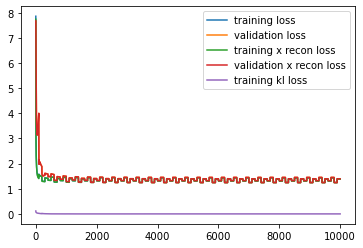

In [8]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_a_ep)
# plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,5))
# plt.xlim((0,1000))
plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [11]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.argmin(val_loss_x_ep[:])
# val_loss_a_ep[1040]

8611

In [9]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s]
    adj_label=adj_list[s]
    features=featureslist[s+'X_'+training_sample_X]
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw']
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if 'dca' in model_str:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if 'dca' in model_str:
        features_raw=features_raw.cpu()
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))



   

disease13
test results loss_test: 2.8612 loss_x_test: 1.4405 loss_a_test: 1.4207
control13
test results loss_test: 2.7135 loss_x_test: 1.3466 loss_a_test: 1.3669
disease8
test results loss_test: 2.6999 loss_x_test: 1.2694 loss_a_test: 1.4305
control8
test results loss_test: 2.7142 loss_x_test: 1.3702 loss_a_test: 1.3440


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [32]:
# model.pi.weight[:8,:8]
model_str

'gcn_vae_xa_e2_d1_dca'